In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-07-07 19:24:44.555195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1892] Ignoring visible gpu device (device: 0, name: Quadro K2000, pci bus id: 0000:05:00.0, compute capability: 3.0) with Cuda compute capability 3.0. The minimum required Cuda capability is 3.5.


# Load data

In [2]:
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']


In [3]:
data_path = os.path.abspath("turing_model_2.npy")
with open(data_path, 'rb') as f:
    data2 = np.load(f)
    
data_path = os.path.abspath("turing_t_model_2.npy")
with open(data_path, 'rb') as f:
    t_star2 = np.load(f) 
    
T2 = t_star2.shape[0]    
    
L2 = 50
x_size2 = data2.shape[1]
y_size2 = data2.shape[2]
N2 = x_size2*y_size2

model_params2 = {'training_data_size': T2*N2,#T*32,
                'pde_data_size': (T2*N2)//(32),
                'boundary_data_size':((x_size2 + y_size2)*T2)//(8)}

dataset2 = create_dataset(data2, t_star2, N2, T2, L2, **model_params2)
lb2 = dataset['lb']
ub2 = dataset['ub']
obs_X2 = dataset2['obs_input']
obs_Y2 = dataset2['obs_output']
pde_X2 = dataset2['pde']

# Test 

In [4]:
class Non_zero_params(Loss):
    def __init__(self,
                 loss_obj:ASDM,
                 print_precision=".5f"):
        super().__init__(name=f"Non-zero params for {loss_obj.name}", print_precision=print_precision)
        self.loss_obj = loss_obj
        #self._trainables_ = loss_obj.trainables()
    
    @tf.function
    def loss(self, pinn, x):
        # Lennard-Jones potential
        #params = tf.stack(self.loss_obj.trainables())
        #epsilon = params.shape[0]
        #twelve = 13*tf.ones_like(params, dtype=pinn.dtype)
        #six = 7*tf.ones_like(params, dtype=pinn.dtype)
        # min height -1e-6
        # wall 1e-6
        #return tf.reduce_sum((4e-6/epsilon)*(-tf.pow(1e-6/(params+1e-10), twelve)/13 + tf.pow(1e-6/(params+1e-10), six))/7)        
        D_a = self.loss_obj.D_a
        D_s = self.loss_obj.D_s
        #def LJ(x):
        #    return (4e-6/2)*((1e-6/(x+1e-10))**12 - (1e-6/(x+1e-10))**6)
        D_a_loss = (4e-6/2)*((1e-6/(D_a+1e-10))**12 - (1e-6/(D_a+1e-10))**6)
        D_s_loss = (4e-6/2)*((1e-6/(D_s+1e-10))**12 - (1e-6/(D_s+1e-10))**6)
        
        return D_a_loss + D_s_loss
        
        
        
        
    

In [5]:
layers = [3, 64, 64, 64, 64, 2]

pinn = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_loss = ASDM(dtype=tf.float64)

    
non_zero_loss = Non_zero_params(pde_loss)

def step_callback(step, epoch, loss_extra_batch):
    print(epoch, step, [item.numpy() for item in loss_extra_batch])
    
def epoch_callback(epoch):    
    print()
    

In [6]:
model = tu.TINN(pinn, 
                pde_loss, 
                extra_loss = [non_zero_loss], 
                #optimizer = keras.optimizers.SGD(learning_rate=1e-4),
                alpha = 0.5, 
                print_precision=".8f")

In [7]:
#tf.executing_eagerly()
results = model.train(epochs = 100,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True,                      
                step_callback=step_callback#,
               #epoch_callback=epoch_callback
                     )


Start of epoch 0
0 0 [array([-4.e-48])]
0 1 [array([-4.00027175e-48])]
0 2 [array([-4.00170017e-48])]
0 3 [array([-4.00238838e-48])]
0 4 [array([-4.00279913e-48])]
0 5 [array([-4.00323493e-48])]
0 6 [array([-4.00361019e-48])]
0 7 [array([-4.00382363e-48])]
0 8 [array([-4.00393374e-48])]
0 9 [array([-4.00401007e-48])]
0 10 [array([-4.0038491e-48])]
0 11 [array([-4.00363623e-48])]
0 12 [array([-4.00345353e-48])]
0 13 [array([-4.00332447e-48])]
0 14 [array([-4.00323655e-48])]
0 15 [array([-4.00314829e-48])]
0 16 [array([-4.00310021e-48])]
0 17 [array([-4.00283454e-48])]
0 18 [array([-4.00239673e-48])]
0 19 [array([-4.00165632e-48])]
0 20 [array([-4.00082509e-48])]
0 21 [array([-4.0000399e-48])]
0 22 [array([-3.99935718e-48])]
0 23 [array([-3.99875971e-48])]
0 24 [array([-3.99822456e-48])]
0 25 [array([-3.99773132e-48])]
0 26 [array([-3.99724392e-48])]
0 27 [array([-3.99673707e-48])]
0 28 [array([-3.99617922e-48])]
0 29 [array([-3.99554471e-48])]
0 30 [array([-3.99481345e-48])]
0 31 [arra

0 253 [array([-3.72070486e-48])]
0 254 [array([-3.71960653e-48])]
0 255 [array([-3.7185078e-48])]
0 256 [array([-3.7174068e-48])]
0 257 [array([-3.7163004e-48])]
0 258 [array([-3.71519166e-48])]
0 259 [array([-3.71408401e-48])]
0 260 [array([-3.71297643e-48])]
0 261 [array([-3.7118661e-48])]
0 262 [array([-3.7107578e-48])]
0 263 [array([-3.70965065e-48])]
0 264 [array([-3.70854521e-48])]
0 265 [array([-3.70743708e-48])]
0 266 [array([-3.70632442e-48])]
0 267 [array([-3.70521011e-48])]
0 268 [array([-3.70409551e-48])]
0 269 [array([-3.70298207e-48])]
0 270 [array([-3.70187092e-48])]
0 271 [array([-3.70075886e-48])]
0 272 [array([-3.69964548e-48])]
0 273 [array([-3.69853189e-48])]
0 274 [array([-3.69741429e-48])]
0 275 [array([-3.69629352e-48])]
0 276 [array([-3.69517175e-48])]
0 277 [array([-3.69405398e-48])]
0 278 [array([-3.69293766e-48])]
0 279 [array([-3.6918193e-48])]
0 280 [array([-3.69070158e-48])]
0 281 [array([-3.68957944e-48])]
0 282 [array([-3.68845797e-48])]
0 283 [array([-3

0 505 [array([-3.41792781e-48])]
0 506 [array([-3.41687908e-48])]
0 507 [array([-3.41584497e-48])]
0 508 [array([-3.41481067e-48])]
0 509 [array([-3.4137866e-48])]
0 510 [array([-3.41276266e-48])]
0 511 [array([-3.41175447e-48])]
0 512 [array([-3.41075631e-48])]
0 513 [array([-3.40975649e-48])]
0 514 [array([-3.40876443e-48])]
0 515 [array([-3.40778924e-48])]
0 516 [array([-3.40682026e-48])]
0 517 [array([-3.40585423e-48])]
0 518 [array([-3.40487739e-48])]
0 519 [array([-3.40391488e-48])]
0 520 [array([-3.40297007e-48])]
0 521 [array([-3.40204376e-48])]
0 522 [array([-3.40110954e-48])]
0 523 [array([-3.40015797e-48])]
0 524 [array([-3.39921329e-48])]
0 525 [array([-3.39829466e-48])]
0 526 [array([-3.39738915e-48])]
0 527 [array([-3.39649232e-48])]
0 528 [array([-3.39560732e-48])]
0 529 [array([-3.3947284e-48])]
0 530 [array([-3.39385751e-48])]
0 531 [array([-3.39299753e-48])]
0 532 [array([-3.39214136e-48])]
0 533 [array([-3.39127788e-48])]
0 534 [array([-3.39041006e-48])]
0 535 [array

0 761 [array([-3.3052802e-48])]
0 762 [array([-3.30520609e-48])]
0 763 [array([-3.3051384e-48])]
0 764 [array([-3.30507388e-48])]
0 765 [array([-3.30499759e-48])]
0 766 [array([-3.30492393e-48])]
0 767 [array([-3.30485905e-48])]
0 768 [array([-3.30478472e-48])]
0 769 [array([-3.30471375e-48])]
0 770 [array([-3.30464605e-48])]
0 771 [array([-3.30457788e-48])]
0 772 [array([-3.30450754e-48])]
0 773 [array([-3.30443683e-48])]
0 774 [array([-3.30436607e-48])]
0 775 [array([-3.30429827e-48])]
0 776 [array([-3.30424305e-48])]
0 777 [array([-3.30419547e-48])]
0 778 [array([-3.30414763e-48])]
0 779 [array([-3.30409077e-48])]
0 780 [array([-3.30403236e-48])]
0 781 [array([-3.30397569e-48])]
0 782 [array([-3.30392363e-48])]
0 783 [array([-3.30386515e-48])]
0 784 [array([-3.30380254e-48])]
0 785 [array([-3.30373832e-48])]
0 786 [array([-3.30368794e-48])]
0 787 [array([-3.30364524e-48])]
0 788 [array([-3.30360322e-48])]
0 789 [array([-3.30354824e-48])]
0 790 [array([-3.30347533e-48])]
0 791 [array

0 1017 [array([-3.32124459e-48])]
0 1018 [array([-3.32140938e-48])]
0 1019 [array([-3.32157985e-48])]
0 1020 [array([-3.32175095e-48])]
0 1021 [array([-3.32192339e-48])]
0 1022 [array([-3.32209384e-48])]
0 1023 [array([-3.32227247e-48])]
Training observations acc over epoch: 8.28878689
total loss: 36932.50960817, total regularisd loss: 36932.50960817
obs u loss: 586.37427237, obs v loss: 16389.05831121
pde u loss: 948.80201005, pde v loss: 19008.27501455
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
D_a: 9.67022 D_s: 11.47350 sigma_a: 10.02509 sigma_s: 9.20663 
mu_a: 9.83948 rho_a: 10.62342 rho_s: 11.02014 kappa_a: 8.93721 

extra loss Non-zero params for Loss_ASDM: -0.00000000
Time taken: 51.90s

Start of epoch 1
1 0 [array([-3.32245187e-48])]
1 1 [array([-3.32264191e-48])]
1 2 [array([-3.32282921e-48])]
1 3 [array([-3.32301038e-48])]
1 4 [array([-3.32318574e-48])]
1 5 [array([-3.32335657e-48])]
1 6 [array([-3.32353229e-48])]
1 7

1 230 [array([-3.37848293e-48])]
1 231 [array([-3.3787749e-48])]
1 232 [array([-3.37911477e-48])]
1 233 [array([-3.37943422e-48])]
1 234 [array([-3.3797287e-48])]
1 235 [array([-3.38001838e-48])]
1 236 [array([-3.3803537e-48])]
1 237 [array([-3.38064066e-48])]
1 238 [array([-3.38088785e-48])]
1 239 [array([-3.38116468e-48])]
1 240 [array([-3.38149916e-48])]
1 241 [array([-3.38179315e-48])]
1 242 [array([-3.38203652e-48])]
1 243 [array([-3.38231876e-48])]
1 244 [array([-3.3826549e-48])]
1 245 [array([-3.38296209e-48])]
1 246 [array([-3.38323048e-48])]
1 247 [array([-3.38354472e-48])]
1 248 [array([-3.38391452e-48])]
1 249 [array([-3.38425054e-48])]
1 250 [array([-3.38453107e-48])]
1 251 [array([-3.38482933e-48])]
1 252 [array([-3.38515648e-48])]
1 253 [array([-3.38545713e-48])]
1 254 [array([-3.38571899e-48])]
1 255 [array([-3.3860002e-48])]
1 256 [array([-3.38632364e-48])]
1 257 [array([-3.38663247e-48])]
1 258 [array([-3.38688449e-48])]
1 259 [array([-3.38713597e-48])]
1 260 [array([-

1 482 [array([-3.45766691e-48])]
1 483 [array([-3.45791979e-48])]
1 484 [array([-3.45824679e-48])]
1 485 [array([-3.45867669e-48])]
1 486 [array([-3.4590294e-48])]
1 487 [array([-3.45929556e-48])]
1 488 [array([-3.4596561e-48])]
1 489 [array([-3.46006575e-48])]
1 490 [array([-3.4603769e-48])]
1 491 [array([-3.46062556e-48])]
1 492 [array([-3.46098073e-48])]
1 493 [array([-3.46132955e-48])]
1 494 [array([-3.46157639e-48])]
1 495 [array([-3.46185476e-48])]
1 496 [array([-3.46227275e-48])]
1 497 [array([-3.46258613e-48])]
1 498 [array([-3.46281001e-48])]
1 499 [array([-3.46317145e-48])]
1 500 [array([-3.4635719e-48])]
1 501 [array([-3.46389666e-48])]
1 502 [array([-3.46418366e-48])]
1 503 [array([-3.46449157e-48])]
1 504 [array([-3.46480178e-48])]
1 505 [array([-3.46506263e-48])]
1 506 [array([-3.46535659e-48])]
1 507 [array([-3.46568826e-48])]
1 508 [array([-3.46598768e-48])]
1 509 [array([-3.46623767e-48])]
1 510 [array([-3.46651619e-48])]
1 511 [array([-3.46682006e-48])]
1 512 [array([

1 733 [array([-3.53902896e-48])]
1 734 [array([-3.53932526e-48])]
1 735 [array([-3.53959523e-48])]
1 736 [array([-3.53993015e-48])]
1 737 [array([-3.54024902e-48])]
1 738 [array([-3.5405296e-48])]
1 739 [array([-3.54082605e-48])]
1 740 [array([-3.54109359e-48])]
1 741 [array([-3.54141466e-48])]
1 742 [array([-3.54174875e-48])]
1 743 [array([-3.54206671e-48])]
1 744 [array([-3.54244274e-48])]
1 745 [array([-3.5428014e-48])]
1 746 [array([-3.54311386e-48])]
1 747 [array([-3.54339517e-48])]
1 748 [array([-3.54372167e-48])]
1 749 [array([-3.54402416e-48])]
1 750 [array([-3.54434386e-48])]
1 751 [array([-3.54467251e-48])]
1 752 [array([-3.54495183e-48])]
1 753 [array([-3.54525903e-48])]
1 754 [array([-3.5455981e-48])]
1 755 [array([-3.54594192e-48])]
1 756 [array([-3.5463038e-48])]
1 757 [array([-3.54661761e-48])]
1 758 [array([-3.54692475e-48])]
1 759 [array([-3.54728013e-48])]
1 760 [array([-3.54768062e-48])]
1 761 [array([-3.54806095e-48])]
1 762 [array([-3.54847583e-48])]
1 763 [array([

1 989 [array([-3.64114262e-48])]
1 990 [array([-3.64149737e-48])]
1 991 [array([-3.64219187e-48])]
1 992 [array([-3.64278661e-48])]
1 993 [array([-3.64316141e-48])]
1 994 [array([-3.64366198e-48])]
1 995 [array([-3.64401004e-48])]
1 996 [array([-3.64477119e-48])]
1 997 [array([-3.64544038e-48])]
1 998 [array([-3.64591807e-48])]
1 999 [array([-3.64637853e-48])]
1 1000 [array([-3.64684805e-48])]
1 1001 [array([-3.64752393e-48])]
1 1002 [array([-3.64819298e-48])]
1 1003 [array([-3.64853249e-48])]
1 1004 [array([-3.64894143e-48])]
1 1005 [array([-3.6493521e-48])]
1 1006 [array([-3.65018851e-48])]
1 1007 [array([-3.65070304e-48])]
1 1008 [array([-3.6512876e-48])]
1 1009 [array([-3.65171893e-48])]
1 1010 [array([-3.65253267e-48])]
1 1011 [array([-3.65334767e-48])]
1 1012 [array([-3.65411549e-48])]
1 1013 [array([-3.65456092e-48])]
1 1014 [array([-3.65509584e-48])]
1 1015 [array([-3.65564109e-48])]
1 1016 [array([-3.65634855e-48])]
1 1017 [array([-3.65684515e-48])]
1 1018 [array([-3.65741187e

2 202 [array([-4.4096593e-48])]
2 203 [array([-4.41732909e-48])]
2 204 [array([-4.42454689e-48])]
2 205 [array([-4.43028045e-48])]
2 206 [array([-4.43260574e-48])]
2 207 [array([-4.43181124e-48])]
2 208 [array([-4.42959049e-48])]
2 209 [array([-4.42812316e-48])]
2 210 [array([-4.43074634e-48])]
2 211 [array([-4.43594184e-48])]
2 212 [array([-4.44232358e-48])]
2 213 [array([-4.44873813e-48])]
2 214 [array([-4.45299865e-48])]
2 215 [array([-4.45480992e-48])]
2 216 [array([-4.45440765e-48])]
2 217 [array([-4.45351519e-48])]
2 218 [array([-4.45344324e-48])]
2 219 [array([-4.45469176e-48])]
2 220 [array([-4.45700897e-48])]
2 221 [array([-4.4593983e-48])]
2 222 [array([-4.46149427e-48])]
2 223 [array([-4.46344969e-48])]
2 224 [array([-4.46546167e-48])]
2 225 [array([-4.46770181e-48])]
2 226 [array([-4.47037546e-48])]
2 227 [array([-4.47312193e-48])]
2 228 [array([-4.47553002e-48])]
2 229 [array([-4.47689836e-48])]
2 230 [array([-4.47702351e-48])]
2 231 [array([-4.47700832e-48])]
2 232 [array

2 454 [array([-4.92520088e-48])]
2 455 [array([-4.92710637e-48])]
2 456 [array([-4.92902883e-48])]
2 457 [array([-4.93129307e-48])]
2 458 [array([-4.93345982e-48])]
2 459 [array([-4.93509124e-48])]
2 460 [array([-4.93643346e-48])]
2 461 [array([-4.93808655e-48])]
2 462 [array([-4.93977438e-48])]
2 463 [array([-4.94176339e-48])]
2 464 [array([-4.94488701e-48])]
2 465 [array([-4.94788413e-48])]
2 466 [array([-4.9504114e-48])]
2 467 [array([-4.95297697e-48])]
2 468 [array([-4.95518079e-48])]
2 469 [array([-4.95710028e-48])]
2 470 [array([-4.95899637e-48])]
2 471 [array([-4.96088971e-48])]
2 472 [array([-4.96223845e-48])]
2 473 [array([-4.96283432e-48])]
2 474 [array([-4.9623383e-48])]
2 475 [array([-4.96088651e-48])]
2 476 [array([-4.96051227e-48])]
2 477 [array([-4.96130011e-48])]
2 478 [array([-4.96315078e-48])]
2 479 [array([-4.96561337e-48])]
2 480 [array([-4.9684895e-48])]
2 481 [array([-4.97163275e-48])]
2 482 [array([-4.97419518e-48])]
2 483 [array([-4.97642021e-48])]
2 484 [array(

2 709 [array([-5.40267338e-48])]
2 710 [array([-5.40392737e-48])]
2 711 [array([-5.40526066e-48])]
2 712 [array([-5.40668163e-48])]
2 713 [array([-5.40814663e-48])]
2 714 [array([-5.40969475e-48])]
2 715 [array([-5.41129914e-48])]
2 716 [array([-5.41294904e-48])]
2 717 [array([-5.41476755e-48])]
2 718 [array([-5.41680568e-48])]
2 719 [array([-5.41908234e-48])]
2 720 [array([-5.421551e-48])]
2 721 [array([-5.42412692e-48])]
2 722 [array([-5.42672072e-48])]
2 723 [array([-5.42931726e-48])]
2 724 [array([-5.43212419e-48])]
2 725 [array([-5.43496849e-48])]
2 726 [array([-5.43786734e-48])]
2 727 [array([-5.44088444e-48])]
2 728 [array([-5.44386138e-48])]
2 729 [array([-5.44693101e-48])]
2 730 [array([-5.44989833e-48])]
2 731 [array([-5.45276531e-48])]
2 732 [array([-5.45544521e-48])]
2 733 [array([-5.45787288e-48])]
2 734 [array([-5.46035017e-48])]
2 735 [array([-5.46269775e-48])]
2 736 [array([-5.46490931e-48])]
2 737 [array([-5.46725678e-48])]
2 738 [array([-5.4694063e-48])]
2 739 [array(

2 965 [array([-5.78624526e-48])]
2 966 [array([-5.78768983e-48])]
2 967 [array([-5.78959446e-48])]
2 968 [array([-5.79131851e-48])]
2 969 [array([-5.79291352e-48])]
2 970 [array([-5.79477694e-48])]
2 971 [array([-5.79649137e-48])]
2 972 [array([-5.79802427e-48])]
2 973 [array([-5.79973486e-48])]
2 974 [array([-5.80105783e-48])]
2 975 [array([-5.80227666e-48])]
2 976 [array([-5.80365584e-48])]
2 977 [array([-5.80480561e-48])]
2 978 [array([-5.80598569e-48])]
2 979 [array([-5.80736821e-48])]
2 980 [array([-5.80871941e-48])]
2 981 [array([-5.81012406e-48])]
2 982 [array([-5.81171663e-48])]
2 983 [array([-5.81334981e-48])]
2 984 [array([-5.8152014e-48])]
2 985 [array([-5.81738866e-48])]
2 986 [array([-5.81965911e-48])]
2 987 [array([-5.82211029e-48])]
2 988 [array([-5.82480234e-48])]
2 989 [array([-5.82748361e-48])]
2 990 [array([-5.83024614e-48])]
2 991 [array([-5.83299435e-48])]
2 992 [array([-5.83551761e-48])]
2 993 [array([-5.838034e-48])]
2 994 [array([-5.8405124e-48])]
2 995 [array([

3 183 [array([-6.42186125e-48])]
3 184 [array([-6.42793209e-48])]
3 185 [array([-6.43363209e-48])]
3 186 [array([-6.43906289e-48])]
3 187 [array([-6.44412217e-48])]
3 188 [array([-6.44888305e-48])]
3 189 [array([-6.45335117e-48])]
3 190 [array([-6.45762098e-48])]
3 191 [array([-6.46187294e-48])]
3 192 [array([-6.4661144e-48])]
3 193 [array([-6.47030454e-48])]
3 194 [array([-6.47454497e-48])]
3 195 [array([-6.47889616e-48])]
3 196 [array([-6.48334087e-48])]
3 197 [array([-6.48785279e-48])]
3 198 [array([-6.49254185e-48])]
3 199 [array([-6.49732048e-48])]
3 200 [array([-6.502276e-48])]
3 201 [array([-6.50728684e-48])]
3 202 [array([-6.51245291e-48])]
3 203 [array([-6.51784794e-48])]
3 204 [array([-6.52329281e-48])]
3 205 [array([-6.52867727e-48])]
3 206 [array([-6.53396462e-48])]
3 207 [array([-6.53929738e-48])]
3 208 [array([-6.54456627e-48])]
3 209 [array([-6.54961922e-48])]
3 210 [array([-6.55441588e-48])]
3 211 [array([-6.55894495e-48])]
3 212 [array([-6.56331358e-48])]
3 213 [array(

3 434 [array([-7.72196992e-48])]
3 435 [array([-7.72561199e-48])]
3 436 [array([-7.72887696e-48])]
3 437 [array([-7.73181538e-48])]
3 438 [array([-7.73471576e-48])]
3 439 [array([-7.73782377e-48])]
3 440 [array([-7.74098666e-48])]
3 441 [array([-7.74402028e-48])]
3 442 [array([-7.74708058e-48])]
3 443 [array([-7.75029751e-48])]
3 444 [array([-7.75375086e-48])]
3 445 [array([-7.75709608e-48])]
3 446 [array([-7.76043806e-48])]
3 447 [array([-7.76405358e-48])]
3 448 [array([-7.76799357e-48])]
3 449 [array([-7.77215601e-48])]
3 450 [array([-7.77613635e-48])]
3 451 [array([-7.7800316e-48])]
3 452 [array([-7.78414598e-48])]
3 453 [array([-7.78825439e-48])]
3 454 [array([-7.79228353e-48])]
3 455 [array([-7.7964705e-48])]
3 456 [array([-7.80072832e-48])]
3 457 [array([-7.80518814e-48])]
3 458 [array([-7.80971465e-48])]
3 459 [array([-7.81409048e-48])]
3 460 [array([-7.81831993e-48])]
3 461 [array([-7.82260866e-48])]
3 462 [array([-7.82688406e-48])]
3 463 [array([-7.83128688e-48])]
3 464 [array

3 689 [array([-8.56748344e-48])]
3 690 [array([-8.56969394e-48])]
3 691 [array([-8.57176064e-48])]
3 692 [array([-8.57395297e-48])]
3 693 [array([-8.57634679e-48])]
3 694 [array([-8.57881304e-48])]
3 695 [array([-8.58122449e-48])]
3 696 [array([-8.58355595e-48])]
3 697 [array([-8.58591524e-48])]
3 698 [array([-8.58845354e-48])]
3 699 [array([-8.59109336e-48])]
3 700 [array([-8.59373863e-48])]
3 701 [array([-8.59626421e-48])]
3 702 [array([-8.59920612e-48])]
3 703 [array([-8.60199307e-48])]
3 704 [array([-8.60430302e-48])]
3 705 [array([-8.60633356e-48])]
3 706 [array([-8.6084073e-48])]
3 707 [array([-8.61039937e-48])]
3 708 [array([-8.61232653e-48])]
3 709 [array([-8.61426279e-48])]
3 710 [array([-8.61649771e-48])]
3 711 [array([-8.61889341e-48])]
3 712 [array([-8.62153193e-48])]
3 713 [array([-8.62437244e-48])]
3 714 [array([-8.62725003e-48])]
3 715 [array([-8.63026367e-48])]
3 716 [array([-8.63322823e-48])]
3 717 [array([-8.63618016e-48])]
3 718 [array([-8.63903809e-48])]
3 719 [arra

3 945 [array([-9.05758836e-48])]
3 946 [array([-9.05848037e-48])]
3 947 [array([-9.05958189e-48])]
3 948 [array([-9.06066648e-48])]
3 949 [array([-9.06177742e-48])]
3 950 [array([-9.06289091e-48])]
3 951 [array([-9.06423757e-48])]
3 952 [array([-9.06587319e-48])]
3 953 [array([-9.06749581e-48])]
3 954 [array([-9.06893863e-48])]
3 955 [array([-9.07052895e-48])]
3 956 [array([-9.07228508e-48])]
3 957 [array([-9.07393231e-48])]
3 958 [array([-9.07546032e-48])]
3 959 [array([-9.07697806e-48])]
3 960 [array([-9.07845522e-48])]
3 961 [array([-9.0798856e-48])]
3 962 [array([-9.08121365e-48])]
3 963 [array([-9.08249802e-48])]
3 964 [array([-9.08374687e-48])]
3 965 [array([-9.08500253e-48])]
3 966 [array([-9.08613429e-48])]
3 967 [array([-9.08721104e-48])]
3 968 [array([-9.08834088e-48])]
3 969 [array([-9.08935162e-48])]
3 970 [array([-9.09031049e-48])]
3 971 [array([-9.09154638e-48])]
3 972 [array([-9.0928688e-48])]
3 973 [array([-9.09434319e-48])]
3 974 [array([-9.09610257e-48])]
3 975 [array

4 162 [array([-9.19231371e-48])]
4 163 [array([-9.19258496e-48])]
4 164 [array([-9.19302673e-48])]
4 165 [array([-9.19351274e-48])]
4 166 [array([-9.19397504e-48])]
4 167 [array([-9.19424454e-48])]
4 168 [array([-9.19440836e-48])]
4 169 [array([-9.19444308e-48])]
4 170 [array([-9.19433846e-48])]
4 171 [array([-9.19406304e-48])]
4 172 [array([-9.19360228e-48])]
4 173 [array([-9.19299645e-48])]
4 174 [array([-9.19227144e-48])]
4 175 [array([-9.19143552e-48])]
4 176 [array([-9.19062138e-48])]
4 177 [array([-9.18961741e-48])]
4 178 [array([-9.18835155e-48])]
4 179 [array([-9.18677419e-48])]
4 180 [array([-9.18507798e-48])]
4 181 [array([-9.18357099e-48])]
4 182 [array([-9.18233249e-48])]
4 183 [array([-9.18110998e-48])]
4 184 [array([-9.17960523e-48])]
4 185 [array([-9.1778511e-48])]
4 186 [array([-9.17590621e-48])]
4 187 [array([-9.17409157e-48])]
4 188 [array([-9.17264926e-48])]
4 189 [array([-9.17163255e-48])]
4 190 [array([-9.17070308e-48])]
4 191 [array([-9.16966103e-48])]
4 192 [arra

4 417 [array([-8.81126852e-48])]
4 418 [array([-8.80974924e-48])]
4 419 [array([-8.80843827e-48])]
4 420 [array([-8.80704655e-48])]
4 421 [array([-8.80537555e-48])]
4 422 [array([-8.80342663e-48])]
4 423 [array([-8.80138761e-48])]
4 424 [array([-8.79951024e-48])]
4 425 [array([-8.79780795e-48])]
4 426 [array([-8.79594885e-48])]
4 427 [array([-8.79375925e-48])]
4 428 [array([-8.79122493e-48])]
4 429 [array([-8.78881229e-48])]
4 430 [array([-8.78687592e-48])]
4 431 [array([-8.78515194e-48])]
4 432 [array([-8.78302243e-48])]
4 433 [array([-8.78020264e-48])]
4 434 [array([-8.77716331e-48])]
4 435 [array([-8.77412444e-48])]
4 436 [array([-8.77126726e-48])]
4 437 [array([-8.76854196e-48])]
4 438 [array([-8.76582945e-48])]
4 439 [array([-8.76288618e-48])]
4 440 [array([-8.75976095e-48])]
4 441 [array([-8.75668245e-48])]
4 442 [array([-8.75386563e-48])]
4 443 [array([-8.75140817e-48])]
4 444 [array([-8.74913538e-48])]
4 445 [array([-8.74678443e-48])]
4 446 [array([-8.74438807e-48])]
4 447 [arr

4 671 [array([-8.16237519e-48])]
4 672 [array([-8.1588902e-48])]
4 673 [array([-8.15500027e-48])]
4 674 [array([-8.15118657e-48])]
4 675 [array([-8.14784358e-48])]
4 676 [array([-8.14476942e-48])]
4 677 [array([-8.14158582e-48])]
4 678 [array([-8.13808509e-48])]
4 679 [array([-8.13454518e-48])]
4 680 [array([-8.1312862e-48])]
4 681 [array([-8.12817548e-48])]
4 682 [array([-8.12494411e-48])]
4 683 [array([-8.12162731e-48])]
4 684 [array([-8.11807988e-48])]
4 685 [array([-8.11458432e-48])]
4 686 [array([-8.11108057e-48])]
4 687 [array([-8.10755611e-48])]
4 688 [array([-8.10404543e-48])]
4 689 [array([-8.10071038e-48])]
4 690 [array([-8.09748279e-48])]
4 691 [array([-8.09422251e-48])]
4 692 [array([-8.09095501e-48])]
4 693 [array([-8.08774644e-48])]
4 694 [array([-8.08460642e-48])]
4 695 [array([-8.08156178e-48])]
4 696 [array([-8.07840324e-48])]
4 697 [array([-8.07522512e-48])]
4 698 [array([-8.07201351e-48])]
4 699 [array([-8.06907659e-48])]
4 700 [array([-8.06632183e-48])]
4 701 [array

4 927 [array([-7.28663953e-48])]
4 928 [array([-7.28262733e-48])]
4 929 [array([-7.27853687e-48])]
4 930 [array([-7.27427303e-48])]
4 931 [array([-7.27014208e-48])]
4 932 [array([-7.26611867e-48])]
4 933 [array([-7.26217361e-48])]
4 934 [array([-7.25846573e-48])]
4 935 [array([-7.25494618e-48])]
4 936 [array([-7.25155518e-48])]
4 937 [array([-7.24800101e-48])]
4 938 [array([-7.24443694e-48])]
4 939 [array([-7.24094566e-48])]
4 940 [array([-7.2375694e-48])]
4 941 [array([-7.23425687e-48])]
4 942 [array([-7.23104195e-48])]
4 943 [array([-7.22770598e-48])]
4 944 [array([-7.22416765e-48])]
4 945 [array([-7.22057682e-48])]
4 946 [array([-7.21732512e-48])]
4 947 [array([-7.21403959e-48])]
4 948 [array([-7.21050793e-48])]
4 949 [array([-7.20668901e-48])]
4 950 [array([-7.2028632e-48])]
4 951 [array([-7.19923601e-48])]
4 952 [array([-7.1957764e-48])]
4 953 [array([-7.19238382e-48])]
4 954 [array([-7.18866538e-48])]
4 955 [array([-7.18495412e-48])]
4 956 [array([-7.18184816e-48])]
4 957 [array(

5 143 [array([-5.82679229e-48])]
5 144 [array([-5.82142626e-48])]
5 145 [array([-5.81584491e-48])]
5 146 [array([-5.81001652e-48])]
5 147 [array([-5.80416475e-48])]
5 148 [array([-5.79838421e-48])]
5 149 [array([-5.79271516e-48])]
5 150 [array([-5.78712579e-48])]
5 151 [array([-5.78154099e-48])]
5 152 [array([-5.77573831e-48])]
5 153 [array([-5.76983109e-48])]
5 154 [array([-5.76387961e-48])]
5 155 [array([-5.75810523e-48])]
5 156 [array([-5.75241955e-48])]
5 157 [array([-5.74672122e-48])]
5 158 [array([-5.74093488e-48])]
5 159 [array([-5.73513923e-48])]
5 160 [array([-5.72944859e-48])]
5 161 [array([-5.72398603e-48])]
5 162 [array([-5.71880101e-48])]
5 163 [array([-5.71378021e-48])]
5 164 [array([-5.70866917e-48])]
5 165 [array([-5.70342168e-48])]
5 166 [array([-5.69812433e-48])]
5 167 [array([-5.69294112e-48])]
5 168 [array([-5.68786625e-48])]
5 169 [array([-5.68292521e-48])]
5 170 [array([-5.67802554e-48])]
5 171 [array([-5.67299137e-48])]
5 172 [array([-5.66779046e-48])]
5 173 [arr

5 396 [array([-4.72179987e-48])]
5 397 [array([-4.71850077e-48])]
5 398 [array([-4.71510869e-48])]
5 399 [array([-4.71174205e-48])]
5 400 [array([-4.70844157e-48])]
5 401 [array([-4.7051512e-48])]
5 402 [array([-4.70180449e-48])]
5 403 [array([-4.69849953e-48])]
5 404 [array([-4.69521919e-48])]
5 405 [array([-4.69193719e-48])]
5 406 [array([-4.68867035e-48])]
5 407 [array([-4.68545308e-48])]
5 408 [array([-4.68231378e-48])]
5 409 [array([-4.6792067e-48])]
5 410 [array([-4.67614604e-48])]
5 411 [array([-4.67313116e-48])]
5 412 [array([-4.67014809e-48])]
5 413 [array([-4.66715904e-48])]
5 414 [array([-4.66417605e-48])]
5 415 [array([-4.66129034e-48])]
5 416 [array([-4.65844312e-48])]
5 417 [array([-4.65550833e-48])]
5 418 [array([-4.65265621e-48])]
5 419 [array([-4.64988383e-48])]
5 420 [array([-4.64714039e-48])]
5 421 [array([-4.64434826e-48])]
5 422 [array([-4.6414425e-48])]
5 423 [array([-4.63846632e-48])]
5 424 [array([-4.63550363e-48])]
5 425 [array([-4.63263305e-48])]
5 426 [array(

5 652 [array([-4.06919417e-48])]
5 653 [array([-4.06704773e-48])]
5 654 [array([-4.06497178e-48])]
5 655 [array([-4.06300864e-48])]
5 656 [array([-4.06106205e-48])]
5 657 [array([-4.05900978e-48])]
5 658 [array([-4.05683825e-48])]
5 659 [array([-4.05470663e-48])]
5 660 [array([-4.05268505e-48])]
5 661 [array([-4.05079476e-48])]
5 662 [array([-4.04887973e-48])]
5 663 [array([-4.04689496e-48])]
5 664 [array([-4.04478066e-48])]
5 665 [array([-4.04264059e-48])]
5 666 [array([-4.04061644e-48])]
5 667 [array([-4.03879334e-48])]
5 668 [array([-4.03703968e-48])]
5 669 [array([-4.03515934e-48])]
5 670 [array([-4.03305211e-48])]
5 671 [array([-4.03090215e-48])]
5 672 [array([-4.02883739e-48])]
5 673 [array([-4.02694133e-48])]
5 674 [array([-4.02508499e-48])]
5 675 [array([-4.02308654e-48])]
5 676 [array([-4.02100222e-48])]
5 677 [array([-4.01887399e-48])]
5 678 [array([-4.01680162e-48])]
5 679 [array([-4.01487471e-48])]
5 680 [array([-4.01304747e-48])]
5 681 [array([-4.01120325e-48])]
5 682 [arr

5 908 [array([-3.60705974e-48])]
5 909 [array([-3.60557538e-48])]
5 910 [array([-3.60416091e-48])]
5 911 [array([-3.60276529e-48])]
5 912 [array([-3.60136569e-48])]
5 913 [array([-3.59985783e-48])]
5 914 [array([-3.59832393e-48])]
5 915 [array([-3.59683173e-48])]
5 916 [array([-3.59542895e-48])]
5 917 [array([-3.59404807e-48])]
5 918 [array([-3.59260882e-48])]
5 919 [array([-3.59109946e-48])]
5 920 [array([-3.58961867e-48])]
5 921 [array([-3.58822389e-48])]
5 922 [array([-3.58681773e-48])]
5 923 [array([-3.58529979e-48])]
5 924 [array([-3.58376284e-48])]
5 925 [array([-3.58224516e-48])]
5 926 [array([-3.5807246e-48])]
5 927 [array([-3.57916443e-48])]
5 928 [array([-3.57747251e-48])]
5 929 [array([-3.57568144e-48])]
5 930 [array([-3.57385751e-48])]
5 931 [array([-3.5720504e-48])]
5 932 [array([-3.57023021e-48])]
5 933 [array([-3.56842261e-48])]
5 934 [array([-3.56661291e-48])]
5 935 [array([-3.56487709e-48])]
5 936 [array([-3.56314356e-48])]
5 937 [array([-3.56137032e-48])]
5 938 [array

6 120 [array([-3.19887037e-48])]
6 121 [array([-3.19718379e-48])]
6 122 [array([-3.19552068e-48])]
6 123 [array([-3.19397166e-48])]
6 124 [array([-3.1925164e-48])]
6 125 [array([-3.19106497e-48])]
6 126 [array([-3.18950379e-48])]
6 127 [array([-3.18792697e-48])]
6 128 [array([-3.18637653e-48])]
6 129 [array([-3.18485106e-48])]
6 130 [array([-3.18339572e-48])]
6 131 [array([-3.1819434e-48])]
6 132 [array([-3.18048677e-48])]
6 133 [array([-3.17895067e-48])]
6 134 [array([-3.17737937e-48])]
6 135 [array([-3.17586345e-48])]
6 136 [array([-3.17444178e-48])]
6 137 [array([-3.17306868e-48])]
6 138 [array([-3.1716568e-48])]
6 139 [array([-3.17019439e-48])]
6 140 [array([-3.1686879e-48])]
6 141 [array([-3.16719259e-48])]
6 142 [array([-3.16574083e-48])]
6 143 [array([-3.16437735e-48])]
6 144 [array([-3.16303056e-48])]
6 145 [array([-3.16167971e-48])]
6 146 [array([-3.16029003e-48])]
6 147 [array([-3.15887859e-48])]
6 148 [array([-3.15749017e-48])]
6 149 [array([-3.15607928e-48])]
6 150 [array([

6 372 [array([-2.90629463e-48])]
6 373 [array([-2.90539524e-48])]
6 374 [array([-2.90439499e-48])]
6 375 [array([-2.9033624e-48])]
6 376 [array([-2.9023296e-48])]
6 377 [array([-2.90141403e-48])]
6 378 [array([-2.90060353e-48])]
6 379 [array([-2.89981893e-48])]
6 380 [array([-2.89899467e-48])]
6 381 [array([-2.89814092e-48])]
6 382 [array([-2.89728165e-48])]
6 383 [array([-2.89647514e-48])]
6 384 [array([-2.89574777e-48])]
6 385 [array([-2.89507407e-48])]
6 386 [array([-2.89436004e-48])]
6 387 [array([-2.89356869e-48])]
6 388 [array([-2.89273223e-48])]
6 389 [array([-2.89188674e-48])]
6 390 [array([-2.89108446e-48])]
6 391 [array([-2.8903388e-48])]
6 392 [array([-2.88959383e-48])]
6 393 [array([-2.88881478e-48])]
6 394 [array([-2.8879804e-48])]
6 395 [array([-2.88713277e-48])]
6 396 [array([-2.88623925e-48])]
6 397 [array([-2.88536616e-48])]
6 398 [array([-2.88451424e-48])]
6 399 [array([-2.88364377e-48])]
6 400 [array([-2.88278101e-48])]
6 401 [array([-2.88194224e-48])]
6 402 [array([

6 624 [array([-2.70371257e-48])]
6 625 [array([-2.70307259e-48])]
6 626 [array([-2.7024018e-48])]
6 627 [array([-2.70166183e-48])]
6 628 [array([-2.70088755e-48])]
6 629 [array([-2.70012807e-48])]
6 630 [array([-2.69940247e-48])]
6 631 [array([-2.69870952e-48])]
6 632 [array([-2.69798516e-48])]
6 633 [array([-2.6972238e-48])]
6 634 [array([-2.69642972e-48])]
6 635 [array([-2.69558206e-48])]
6 636 [array([-2.6947445e-48])]
6 637 [array([-2.69396726e-48])]
6 638 [array([-2.69323635e-48])]
6 639 [array([-2.69250375e-48])]
6 640 [array([-2.691745e-48])]
6 641 [array([-2.69094055e-48])]
6 642 [array([-2.69011194e-48])]
6 643 [array([-2.68931408e-48])]
6 644 [array([-2.688555e-48])]
6 645 [array([-2.68784241e-48])]
6 646 [array([-2.68712807e-48])]
6 647 [array([-2.68640769e-48])]
6 648 [array([-2.68565998e-48])]
6 649 [array([-2.68490079e-48])]
6 650 [array([-2.6841775e-48])]
6 651 [array([-2.68344741e-48])]
6 652 [array([-2.68270838e-48])]
6 653 [array([-2.68193715e-48])]
6 654 [array([-2.6

6 880 [array([-2.53063676e-48])]
6 881 [array([-2.52984614e-48])]
6 882 [array([-2.5290317e-48])]
6 883 [array([-2.52822746e-48])]
6 884 [array([-2.52744691e-48])]
6 885 [array([-2.5267031e-48])]
6 886 [array([-2.52599802e-48])]
6 887 [array([-2.52533727e-48])]
6 888 [array([-2.5246836e-48])]
6 889 [array([-2.52402451e-48])]
6 890 [array([-2.52335205e-48])]
6 891 [array([-2.52271067e-48])]
6 892 [array([-2.52213929e-48])]
6 893 [array([-2.52161765e-48])]
6 894 [array([-2.52109414e-48])]
6 895 [array([-2.52051915e-48])]
6 896 [array([-2.5198903e-48])]
6 897 [array([-2.5192433e-48])]
6 898 [array([-2.51860491e-48])]
6 899 [array([-2.51797091e-48])]
6 900 [array([-2.51732309e-48])]
6 901 [array([-2.51667312e-48])]
6 902 [array([-2.51598036e-48])]
6 903 [array([-2.51526251e-48])]
6 904 [array([-2.51455223e-48])]
6 905 [array([-2.51385344e-48])]
6 906 [array([-2.51314728e-48])]
6 907 [array([-2.5124273e-48])]
6 908 [array([-2.51172497e-48])]
6 909 [array([-2.51103558e-48])]
6 910 [array([-2

7 95 [array([-2.32685865e-48])]
7 96 [array([-2.32560459e-48])]
7 97 [array([-2.32443597e-48])]
7 98 [array([-2.32327532e-48])]
7 99 [array([-2.32205385e-48])]
7 100 [array([-2.32084168e-48])]
7 101 [array([-2.31967344e-48])]
7 102 [array([-2.31851481e-48])]
7 103 [array([-2.3173243e-48])]
7 104 [array([-2.31610129e-48])]
7 105 [array([-2.31491975e-48])]
7 106 [array([-2.31377371e-48])]
7 107 [array([-2.31260663e-48])]
7 108 [array([-2.31136994e-48])]
7 109 [array([-2.31004363e-48])]
7 110 [array([-2.30872035e-48])]
7 111 [array([-2.30749295e-48])]
7 112 [array([-2.30627798e-48])]
7 113 [array([-2.30499624e-48])]
7 114 [array([-2.30369035e-48])]
7 115 [array([-2.3024262e-48])]
7 116 [array([-2.30126142e-48])]
7 117 [array([-2.30017533e-48])]
7 118 [array([-2.29907994e-48])]
7 119 [array([-2.2979274e-48])]
7 120 [array([-2.29672934e-48])]
7 121 [array([-2.29558586e-48])]
7 122 [array([-2.29453585e-48])]
7 123 [array([-2.29353844e-48])]
7 124 [array([-2.29253222e-48])]
7 125 [array([-2.2

7 352 [array([-2.04414582e-48])]
7 353 [array([-2.04293436e-48])]
7 354 [array([-2.04174991e-48])]
7 355 [array([-2.04056815e-48])]
7 356 [array([-2.03941541e-48])]
7 357 [array([-2.03828983e-48])]
7 358 [array([-2.03717466e-48])]
7 359 [array([-2.03608818e-48])]
7 360 [array([-2.03500899e-48])]
7 361 [array([-2.03393728e-48])]
7 362 [array([-2.03279835e-48])]
7 363 [array([-2.03167703e-48])]
7 364 [array([-2.03056035e-48])]
7 365 [array([-2.02947387e-48])]
7 366 [array([-2.02843448e-48])]
7 367 [array([-2.02742353e-48])]
7 368 [array([-2.02648825e-48])]
7 369 [array([-2.02553838e-48])]
7 370 [array([-2.02457599e-48])]
7 371 [array([-2.02360787e-48])]
7 372 [array([-2.02266882e-48])]
7 373 [array([-2.02173739e-48])]
7 374 [array([-2.02082867e-48])]
7 375 [array([-2.01990462e-48])]
7 376 [array([-2.01895754e-48])]
7 377 [array([-2.01798295e-48])]
7 378 [array([-2.01697799e-48])]
7 379 [array([-2.01589755e-48])]
7 380 [array([-2.01484564e-48])]
7 381 [array([-2.01384115e-48])]
7 382 [arr

7 609 [array([-1.77770372e-48])]
7 610 [array([-1.7767002e-48])]
7 611 [array([-1.77574355e-48])]
7 612 [array([-1.77483342e-48])]
7 613 [array([-1.77391474e-48])]
7 614 [array([-1.77303087e-48])]
7 615 [array([-1.77214449e-48])]
7 616 [array([-1.77127726e-48])]
7 617 [array([-1.77046825e-48])]
7 618 [array([-1.76965251e-48])]
7 619 [array([-1.76877408e-48])]
7 620 [array([-1.76787319e-48])]
7 621 [array([-1.76697858e-48])]
7 622 [array([-1.76609565e-48])]
7 623 [array([-1.76517835e-48])]
7 624 [array([-1.76427411e-48])]
7 625 [array([-1.76338053e-48])]
7 626 [array([-1.76244876e-48])]
7 627 [array([-1.76150508e-48])]
7 628 [array([-1.76058164e-48])]
7 629 [array([-1.7596939e-48])]
7 630 [array([-1.7588435e-48])]
7 631 [array([-1.75799244e-48])]
7 632 [array([-1.75711665e-48])]
7 633 [array([-1.75625652e-48])]
7 634 [array([-1.75538551e-48])]
7 635 [array([-1.75444719e-48])]
7 636 [array([-1.75349186e-48])]
7 637 [array([-1.75257306e-48])]
7 638 [array([-1.75169913e-48])]
7 639 [array(

7 863 [array([-1.5411155e-48])]
7 864 [array([-1.54021488e-48])]
7 865 [array([-1.53928635e-48])]
7 866 [array([-1.53834468e-48])]
7 867 [array([-1.53732052e-48])]
7 868 [array([-1.53630224e-48])]
7 869 [array([-1.53529095e-48])]
7 870 [array([-1.53430065e-48])]
7 871 [array([-1.53333118e-48])]
7 872 [array([-1.5322737e-48])]
7 873 [array([-1.53119605e-48])]
7 874 [array([-1.53009421e-48])]
7 875 [array([-1.52903236e-48])]
7 876 [array([-1.52798695e-48])]
7 877 [array([-1.52695243e-48])]
7 878 [array([-1.52593303e-48])]
7 879 [array([-1.52490109e-48])]
7 880 [array([-1.52388827e-48])]
7 881 [array([-1.52292734e-48])]
7 882 [array([-1.52198928e-48])]
7 883 [array([-1.52107651e-48])]
7 884 [array([-1.5201613e-48])]
7 885 [array([-1.51925633e-48])]
7 886 [array([-1.51837752e-48])]
7 887 [array([-1.51752232e-48])]
7 888 [array([-1.51664067e-48])]
7 889 [array([-1.51576458e-48])]
7 890 [array([-1.51490592e-48])]
7 891 [array([-1.51402509e-48])]
7 892 [array([-1.51310202e-48])]
7 893 [array(

8 80 [array([-1.32933455e-48])]
8 81 [array([-1.32865457e-48])]
8 82 [array([-1.32800669e-48])]
8 83 [array([-1.32734267e-48])]
8 84 [array([-1.3266198e-48])]
8 85 [array([-1.32590546e-48])]
8 86 [array([-1.32513158e-48])]
8 87 [array([-1.32433552e-48])]
8 88 [array([-1.32352323e-48])]
8 89 [array([-1.32270352e-48])]
8 90 [array([-1.32190504e-48])]
8 91 [array([-1.32112985e-48])]
8 92 [array([-1.32034402e-48])]
8 93 [array([-1.31955066e-48])]
8 94 [array([-1.31875043e-48])]
8 95 [array([-1.31794732e-48])]
8 96 [array([-1.31716046e-48])]
8 97 [array([-1.31640912e-48])]
8 98 [array([-1.31567419e-48])]
8 99 [array([-1.31486025e-48])]
8 100 [array([-1.31401775e-48])]
8 101 [array([-1.31312937e-48])]
8 102 [array([-1.31221007e-48])]
8 103 [array([-1.3112917e-48])]
8 104 [array([-1.31043458e-48])]
8 105 [array([-1.30959866e-48])]
8 106 [array([-1.3088201e-48])]
8 107 [array([-1.30803381e-48])]
8 108 [array([-1.30724308e-48])]
8 109 [array([-1.3065321e-48])]
8 110 [array([-1.30587398e-48])]
8

8 336 [array([-1.12470244e-48])]
8 337 [array([-1.12405877e-48])]
8 338 [array([-1.12336569e-48])]
8 339 [array([-1.12267768e-48])]
8 340 [array([-1.12193348e-48])]
8 341 [array([-1.1211269e-48])]
8 342 [array([-1.12034185e-48])]
8 343 [array([-1.11959712e-48])]
8 344 [array([-1.11890148e-48])]
8 345 [array([-1.11823554e-48])]
8 346 [array([-1.11756724e-48])]
8 347 [array([-1.11686034e-48])]
8 348 [array([-1.11615495e-48])]
8 349 [array([-1.11545874e-48])]
8 350 [array([-1.11474377e-48])]
8 351 [array([-1.11394714e-48])]
8 352 [array([-1.11309528e-48])]
8 353 [array([-1.11227023e-48])]
8 354 [array([-1.11146492e-48])]
8 355 [array([-1.11065072e-48])]
8 356 [array([-1.10980613e-48])]
8 357 [array([-1.10895289e-48])]
8 358 [array([-1.1081381e-48])]
8 359 [array([-1.1073614e-48])]
8 360 [array([-1.10660582e-48])]
8 361 [array([-1.10588092e-48])]
8 362 [array([-1.10516046e-48])]
8 363 [array([-1.10438005e-48])]
8 364 [array([-1.10360303e-48])]
8 365 [array([-1.10285009e-48])]
8 366 [array(

8 592 [array([-9.41291308e-49])]
8 593 [array([-9.40734e-49])]
8 594 [array([-9.4014661e-49])]
8 595 [array([-9.39504457e-49])]
8 596 [array([-9.38845339e-49])]
8 597 [array([-9.38193164e-49])]
8 598 [array([-9.37556157e-49])]
8 599 [array([-9.36956324e-49])]
8 600 [array([-9.36364981e-49])]
8 601 [array([-9.35716205e-49])]
8 602 [array([-9.35025035e-49])]
8 603 [array([-9.34315803e-49])]
8 604 [array([-9.33633431e-49])]
8 605 [array([-9.32970099e-49])]
8 606 [array([-9.32347979e-49])]
8 607 [array([-9.31707308e-49])]
8 608 [array([-9.31091829e-49])]
8 609 [array([-9.30475165e-49])]
8 610 [array([-9.29822534e-49])]
8 611 [array([-9.29196172e-49])]
8 612 [array([-9.28524994e-49])]
8 613 [array([-9.27880402e-49])]
8 614 [array([-9.27278011e-49])]
8 615 [array([-9.26714841e-49])]
8 616 [array([-9.26199017e-49])]
8 617 [array([-9.25733284e-49])]
8 618 [array([-9.25268093e-49])]
8 619 [array([-9.24780422e-49])]
8 620 [array([-9.24317725e-49])]
8 621 [array([-9.23862138e-49])]
8 622 [array([

8 849 [array([-8.02798693e-49])]
8 850 [array([-8.02295232e-49])]
8 851 [array([-8.01779845e-49])]
8 852 [array([-8.01281812e-49])]
8 853 [array([-8.00741927e-49])]
8 854 [array([-8.00174802e-49])]
8 855 [array([-7.9961459e-49])]
8 856 [array([-7.9907396e-49])]
8 857 [array([-7.98538747e-49])]
8 858 [array([-7.98026936e-49])]
8 859 [array([-7.97489765e-49])]
8 860 [array([-7.96931611e-49])]
8 861 [array([-7.96372463e-49])]
8 862 [array([-7.95827413e-49])]
8 863 [array([-7.95256224e-49])]
8 864 [array([-7.94685383e-49])]
8 865 [array([-7.94096183e-49])]
8 866 [array([-7.93513479e-49])]
8 867 [array([-7.9295767e-49])]
8 868 [array([-7.9239976e-49])]
8 869 [array([-7.91888479e-49])]
8 870 [array([-7.91411725e-49])]
8 871 [array([-7.90935373e-49])]
8 872 [array([-7.90409306e-49])]
8 873 [array([-7.8987467e-49])]
8 874 [array([-7.89308813e-49])]
8 875 [array([-7.88740042e-49])]
8 876 [array([-7.88228262e-49])]
8 877 [array([-7.87745107e-49])]
8 878 [array([-7.87278602e-49])]
8 879 [array([-

9 64 [array([-7.04653062e-49])]
9 65 [array([-7.04395552e-49])]
9 66 [array([-7.04124978e-49])]
9 67 [array([-7.03855486e-49])]
9 68 [array([-7.03550184e-49])]
9 69 [array([-7.03188581e-49])]
9 70 [array([-7.02839943e-49])]
9 71 [array([-7.02523928e-49])]
9 72 [array([-7.02243831e-49])]
9 73 [array([-7.01984967e-49])]
9 74 [array([-7.01731996e-49])]
9 75 [array([-7.01488093e-49])]
9 76 [array([-7.01244627e-49])]
9 77 [array([-7.00997561e-49])]
9 78 [array([-7.00761377e-49])]
9 79 [array([-7.00506034e-49])]
9 80 [array([-7.00233308e-49])]
9 81 [array([-6.99927903e-49])]
9 82 [array([-6.99559139e-49])]
9 83 [array([-6.99189414e-49])]
9 84 [array([-6.98840044e-49])]
9 85 [array([-6.98514137e-49])]
9 86 [array([-6.98218904e-49])]
9 87 [array([-6.97927732e-49])]
9 88 [array([-6.97653588e-49])]
9 89 [array([-6.97384056e-49])]
9 90 [array([-6.97095337e-49])]
9 91 [array([-6.96799145e-49])]
9 92 [array([-6.96479819e-49])]
9 93 [array([-6.96145087e-49])]
9 94 [array([-6.9579814e-49])]
9 95 [arr

9 317 [array([-6.31663477e-49])]
9 318 [array([-6.31503519e-49])]
9 319 [array([-6.31320284e-49])]
9 320 [array([-6.3113307e-49])]
9 321 [array([-6.30907829e-49])]
9 322 [array([-6.30663583e-49])]
9 323 [array([-6.30368857e-49])]
9 324 [array([-6.30110808e-49])]
9 325 [array([-6.29882341e-49])]
9 326 [array([-6.29692739e-49])]
9 327 [array([-6.2953135e-49])]
9 328 [array([-6.29375305e-49])]
9 329 [array([-6.29196006e-49])]
9 330 [array([-6.28999395e-49])]
9 331 [array([-6.28785509e-49])]
9 332 [array([-6.2857837e-49])]
9 333 [array([-6.28387998e-49])]
9 334 [array([-6.28211178e-49])]
9 335 [array([-6.28042472e-49])]
9 336 [array([-6.27884164e-49])]
9 337 [array([-6.27741794e-49])]
9 338 [array([-6.27548644e-49])]
9 339 [array([-6.27365394e-49])]
9 340 [array([-6.27182454e-49])]
9 341 [array([-6.27014113e-49])]
9 342 [array([-6.26845487e-49])]
9 343 [array([-6.26666789e-49])]
9 344 [array([-6.26462636e-49])]
9 345 [array([-6.26228614e-49])]
9 346 [array([-6.25954324e-49])]
9 347 [array(

9 574 [array([-5.84529519e-49])]
9 575 [array([-5.84408668e-49])]
9 576 [array([-5.84272414e-49])]
9 577 [array([-5.84145216e-49])]
9 578 [array([-5.84021511e-49])]
9 579 [array([-5.83897465e-49])]
9 580 [array([-5.83754828e-49])]
9 581 [array([-5.8360184e-49])]
9 582 [array([-5.8346257e-49])]
9 583 [array([-5.83338978e-49])]
9 584 [array([-5.83236667e-49])]
9 585 [array([-5.8313381e-49])]
9 586 [array([-5.8302428e-49])]
9 587 [array([-5.82908084e-49])]
9 588 [array([-5.82792671e-49])]
9 589 [array([-5.82669922e-49])]
9 590 [array([-5.82562873e-49])]
9 591 [array([-5.82475806e-49])]
9 592 [array([-5.824015e-49])]
9 593 [array([-5.82317946e-49])]
9 594 [array([-5.82205321e-49])]
9 595 [array([-5.82095314e-49])]
9 596 [array([-5.81997615e-49])]
9 597 [array([-5.81925821e-49])]
9 598 [array([-5.81875774e-49])]
9 599 [array([-5.81821703e-49])]
9 600 [array([-5.81756118e-49])]
9 601 [array([-5.81659107e-49])]
9 602 [array([-5.81544773e-49])]
9 603 [array([-5.81408558e-49])]
9 604 [array([-5

9 826 [array([-5.47385939e-49])]
9 827 [array([-5.47191088e-49])]
9 828 [array([-5.46977389e-49])]
9 829 [array([-5.46782974e-49])]
9 830 [array([-5.46599471e-49])]
9 831 [array([-5.46406064e-49])]
9 832 [array([-5.46202127e-49])]
9 833 [array([-5.45998359e-49])]
9 834 [array([-5.4578734e-49])]
9 835 [array([-5.45601848e-49])]
9 836 [array([-5.45431316e-49])]
9 837 [array([-5.45286361e-49])]
9 838 [array([-5.45159786e-49])]
9 839 [array([-5.45048626e-49])]
9 840 [array([-5.44942118e-49])]
9 841 [array([-5.44822451e-49])]
9 842 [array([-5.44682563e-49])]
9 843 [array([-5.44559357e-49])]
9 844 [array([-5.44462885e-49])]
9 845 [array([-5.44389293e-49])]
9 846 [array([-5.4431956e-49])]
9 847 [array([-5.44235735e-49])]
9 848 [array([-5.44106645e-49])]
9 849 [array([-5.43955509e-49])]
9 850 [array([-5.43789268e-49])]
9 851 [array([-5.43623402e-49])]
9 852 [array([-5.43472415e-49])]
9 853 [array([-5.43342752e-49])]
9 854 [array([-5.43238986e-49])]
9 855 [array([-5.43132516e-49])]
9 856 [array

10 37 [array([-5.25190399e-49])]
10 38 [array([-5.25131255e-49])]
10 39 [array([-5.25062981e-49])]
10 40 [array([-5.25009104e-49])]
10 41 [array([-5.24975279e-49])]
10 42 [array([-5.24960804e-49])]
10 43 [array([-5.24953174e-49])]
10 44 [array([-5.24932144e-49])]
10 45 [array([-5.24894518e-49])]
10 46 [array([-5.24846443e-49])]
10 47 [array([-5.24792073e-49])]
10 48 [array([-5.24729443e-49])]
10 49 [array([-5.24670553e-49])]
10 50 [array([-5.24598946e-49])]
10 51 [array([-5.24525e-49])]
10 52 [array([-5.24450103e-49])]
10 53 [array([-5.24385867e-49])]
10 54 [array([-5.24326605e-49])]
10 55 [array([-5.24270535e-49])]
10 56 [array([-5.24221458e-49])]
10 57 [array([-5.24181564e-49])]
10 58 [array([-5.2414982e-49])]
10 59 [array([-5.24086583e-49])]
10 60 [array([-5.23993508e-49])]
10 61 [array([-5.23885821e-49])]
10 62 [array([-5.23779395e-49])]
10 63 [array([-5.23672013e-49])]
10 64 [array([-5.23558313e-49])]
10 65 [array([-5.23444801e-49])]
10 66 [array([-5.23336016e-49])]
10 67 [array([

10 284 [array([-5.14526732e-49])]
10 285 [array([-5.14491517e-49])]
10 286 [array([-5.14449899e-49])]
10 287 [array([-5.1440377e-49])]
10 288 [array([-5.14340393e-49])]
10 289 [array([-5.1426565e-49])]
10 290 [array([-5.14173598e-49])]
10 291 [array([-5.14074281e-49])]
10 292 [array([-5.13976769e-49])]
10 293 [array([-5.1388325e-49])]
10 294 [array([-5.13798213e-49])]
10 295 [array([-5.13728253e-49])]
10 296 [array([-5.13686972e-49])]
10 297 [array([-5.13666679e-49])]
10 298 [array([-5.13656613e-49])]
10 299 [array([-5.13662575e-49])]
10 300 [array([-5.1366648e-49])]
10 301 [array([-5.13666028e-49])]
10 302 [array([-5.13662917e-49])]
10 303 [array([-5.1367186e-49])]
10 304 [array([-5.13685238e-49])]
10 305 [array([-5.13724431e-49])]
10 306 [array([-5.1377091e-49])]
10 307 [array([-5.13822897e-49])]
10 308 [array([-5.13856893e-49])]
10 309 [array([-5.13868151e-49])]
10 310 [array([-5.13856064e-49])]
10 311 [array([-5.13800373e-49])]
10 312 [array([-5.13739235e-49])]
10 313 [array([-5.13

10 528 [array([-5.0723045e-49])]
10 529 [array([-5.07180955e-49])]
10 530 [array([-5.0715968e-49])]
10 531 [array([-5.07189837e-49])]
10 532 [array([-5.0724872e-49])]
10 533 [array([-5.07311498e-49])]
10 534 [array([-5.0738138e-49])]
10 535 [array([-5.07441269e-49])]
10 536 [array([-5.07485955e-49])]
10 537 [array([-5.0751589e-49])]
10 538 [array([-5.07544822e-49])]
10 539 [array([-5.07575352e-49])]
10 540 [array([-5.07615801e-49])]
10 541 [array([-5.0767096e-49])]
10 542 [array([-5.07726406e-49])]
10 543 [array([-5.07767165e-49])]
10 544 [array([-5.07780432e-49])]
10 545 [array([-5.07769961e-49])]
10 546 [array([-5.07718701e-49])]
10 547 [array([-5.07661575e-49])]
10 548 [array([-5.0760008e-49])]
10 549 [array([-5.07552775e-49])]
10 550 [array([-5.07537735e-49])]
10 551 [array([-5.07550828e-49])]
10 552 [array([-5.0757628e-49])]
10 553 [array([-5.07604358e-49])]
10 554 [array([-5.07599995e-49])]
10 555 [array([-5.07585089e-49])]
10 556 [array([-5.07541225e-49])]
10 557 [array([-5.0749

10 772 [array([-5.04170211e-49])]
10 773 [array([-5.04220104e-49])]
10 774 [array([-5.04280422e-49])]
10 775 [array([-5.04337863e-49])]
10 776 [array([-5.0438511e-49])]
10 777 [array([-5.04415386e-49])]
10 778 [array([-5.04429042e-49])]
10 779 [array([-5.0442381e-49])]
10 780 [array([-5.04413394e-49])]
10 781 [array([-5.04389796e-49])]
10 782 [array([-5.04355834e-49])]
10 783 [array([-5.04323683e-49])]
10 784 [array([-5.04285368e-49])]
10 785 [array([-5.04223536e-49])]
10 786 [array([-5.04153787e-49])]
10 787 [array([-5.04101666e-49])]
10 788 [array([-5.04061571e-49])]
10 789 [array([-5.0405152e-49])]
10 790 [array([-5.04060051e-49])]
10 791 [array([-5.0407404e-49])]
10 792 [array([-5.04087165e-49])]
10 793 [array([-5.0411543e-49])]
10 794 [array([-5.04149555e-49])]
10 795 [array([-5.04193425e-49])]
10 796 [array([-5.0423135e-49])]
10 797 [array([-5.04265602e-49])]
10 798 [array([-5.04292002e-49])]
10 799 [array([-5.04321391e-49])]
10 800 [array([-5.04356326e-49])]
10 801 [array([-5.04

10 1019 [array([-5.05450669e-49])]
10 1020 [array([-5.05546797e-49])]
10 1021 [array([-5.05620365e-49])]
10 1022 [array([-5.05652811e-49])]
10 1023 [array([-5.05675433e-49])]
Training observations acc over epoch: 0.13119203
total loss: 614.52063681, total regularisd loss: 862.48042376
obs u loss: 233.24327849, obs v loss: 35.43789913
pde u loss: 317.21190761, pde v loss: 28.62755157
lambda obs u: 3.73006527, lambda obs v: 0.15387042
lambda pde u: 0.07224270, lambda pde v: 0.04382162
D_a: 13.05636 D_s: 16.42256 sigma_a: 8.39449 sigma_s: 4.52138 
mu_a: 11.19831 rho_a: 9.49736 rho_s: 15.18380 kappa_a: 3.71434 

extra loss Non-zero params for Loss_ASDM: -0.00000000
Time taken: 28.25s

Start of epoch 11
11 0 [array([-5.05685815e-49])]
11 1 [array([-5.05709489e-49])]
11 2 [array([-5.05777e-49])]
11 3 [array([-5.05886074e-49])]
11 4 [array([-5.05997798e-49])]
11 5 [array([-5.06073217e-49])]
11 6 [array([-5.06093082e-49])]
11 7 [array([-5.06080626e-49])]
11 8 [array([-5.06083001e-49])]
11 9 [a

11 231 [array([-5.05652324e-49])]
11 232 [array([-5.05599042e-49])]
11 233 [array([-5.05551799e-49])]
11 234 [array([-5.05503231e-49])]
11 235 [array([-5.0545816e-49])]
11 236 [array([-5.0543807e-49])]
11 237 [array([-5.0540042e-49])]
11 238 [array([-5.05368464e-49])]
11 239 [array([-5.05329612e-49])]
11 240 [array([-5.05281474e-49])]
11 241 [array([-5.05235824e-49])]
11 242 [array([-5.05193563e-49])]
11 243 [array([-5.05136289e-49])]
11 244 [array([-5.05095173e-49])]
11 245 [array([-5.05056648e-49])]
11 246 [array([-5.05030357e-49])]
11 247 [array([-5.04997838e-49])]
11 248 [array([-5.04920636e-49])]
11 249 [array([-5.0484687e-49])]
11 250 [array([-5.04739258e-49])]
11 251 [array([-5.04649042e-49])]
11 252 [array([-5.04596114e-49])]
11 253 [array([-5.04570272e-49])]
11 254 [array([-5.04598848e-49])]
11 255 [array([-5.04658436e-49])]
11 256 [array([-5.04736031e-49])]
11 257 [array([-5.04831925e-49])]
11 258 [array([-5.04934397e-49])]
11 259 [array([-5.05032949e-49])]
11 260 [array([-5.

11 479 [array([-5.01628706e-49])]
11 480 [array([-5.01598678e-49])]
11 481 [array([-5.01626284e-49])]
11 482 [array([-5.016765e-49])]
11 483 [array([-5.01725864e-49])]
11 484 [array([-5.01761248e-49])]
11 485 [array([-5.01780854e-49])]
11 486 [array([-5.0182196e-49])]
11 487 [array([-5.01890178e-49])]
11 488 [array([-5.01942529e-49])]
11 489 [array([-5.0193315e-49])]
11 490 [array([-5.01868575e-49])]
11 491 [array([-5.01768795e-49])]
11 492 [array([-5.01684414e-49])]
11 493 [array([-5.01635373e-49])]
11 494 [array([-5.01630524e-49])]
11 495 [array([-5.01653095e-49])]
11 496 [array([-5.01702325e-49])]
11 497 [array([-5.01767968e-49])]
11 498 [array([-5.01854605e-49])]
11 499 [array([-5.0196037e-49])]
11 500 [array([-5.02078863e-49])]
11 501 [array([-5.02188191e-49])]
11 502 [array([-5.02285782e-49])]
11 503 [array([-5.02354778e-49])]
11 504 [array([-5.02406586e-49])]
11 505 [array([-5.0241628e-49])]
11 506 [array([-5.0242271e-49])]
11 507 [array([-5.02438091e-49])]
11 508 [array([-5.024

11 726 [array([-4.98116016e-49])]
11 727 [array([-4.98181325e-49])]
11 728 [array([-4.98230168e-49])]
11 729 [array([-4.98269322e-49])]
11 730 [array([-4.98315491e-49])]
11 731 [array([-4.98365883e-49])]
11 732 [array([-4.9841935e-49])]
11 733 [array([-4.98469746e-49])]
11 734 [array([-4.98513635e-49])]
11 735 [array([-4.98583001e-49])]
11 736 [array([-4.98650766e-49])]
11 737 [array([-4.98742257e-49])]
11 738 [array([-4.98839026e-49])]
11 739 [array([-4.98902561e-49])]
11 740 [array([-4.98930092e-49])]
11 741 [array([-4.98925994e-49])]
11 742 [array([-4.98910377e-49])]
11 743 [array([-4.98895938e-49])]
11 744 [array([-4.98895346e-49])]
11 745 [array([-4.98903314e-49])]
11 746 [array([-4.98910732e-49])]
11 747 [array([-4.98905576e-49])]
11 748 [array([-4.98902031e-49])]
11 749 [array([-4.98888402e-49])]
11 750 [array([-4.9884822e-49])]
11 751 [array([-4.98809133e-49])]
11 752 [array([-4.98781498e-49])]
11 753 [array([-4.98806177e-49])]
11 754 [array([-4.98855762e-49])]
11 755 [array([-

11 973 [array([-5.04825215e-49])]
11 974 [array([-5.04837545e-49])]
11 975 [array([-5.04836845e-49])]
11 976 [array([-5.04846957e-49])]
11 977 [array([-5.04871014e-49])]
11 978 [array([-5.04936128e-49])]
11 979 [array([-5.05013436e-49])]
11 980 [array([-5.05105363e-49])]
11 981 [array([-5.05180089e-49])]
11 982 [array([-5.05226997e-49])]
11 983 [array([-5.05264978e-49])]
11 984 [array([-5.05297269e-49])]
11 985 [array([-5.05312728e-49])]
11 986 [array([-5.05331916e-49])]
11 987 [array([-5.05360613e-49])]
11 988 [array([-5.05359737e-49])]
11 989 [array([-5.05328871e-49])]
11 990 [array([-5.05305992e-49])]
11 991 [array([-5.05301245e-49])]
11 992 [array([-5.05294552e-49])]
11 993 [array([-5.05274937e-49])]
11 994 [array([-5.0525251e-49])]
11 995 [array([-5.05212428e-49])]
11 996 [array([-5.05182986e-49])]
11 997 [array([-5.0517618e-49])]
11 998 [array([-5.05197499e-49])]
11 999 [array([-5.05269205e-49])]
11 1000 [array([-5.05364222e-49])]
11 1001 [array([-5.05464553e-49])]
11 1002 [array

12 184 [array([-5.11091563e-49])]
12 185 [array([-5.11076412e-49])]
12 186 [array([-5.11082206e-49])]
12 187 [array([-5.11106106e-49])]
12 188 [array([-5.11138214e-49])]
12 189 [array([-5.11179145e-49])]
12 190 [array([-5.11233051e-49])]
12 191 [array([-5.11293482e-49])]
12 192 [array([-5.11351164e-49])]
12 193 [array([-5.11391908e-49])]
12 194 [array([-5.11424873e-49])]
12 195 [array([-5.11450753e-49])]
12 196 [array([-5.11473442e-49])]
12 197 [array([-5.11496259e-49])]
12 198 [array([-5.11517636e-49])]
12 199 [array([-5.11524884e-49])]
12 200 [array([-5.11513001e-49])]
12 201 [array([-5.11515655e-49])]
12 202 [array([-5.11550286e-49])]
12 203 [array([-5.11656028e-49])]
12 204 [array([-5.11792577e-49])]
12 205 [array([-5.11932088e-49])]
12 206 [array([-5.12056173e-49])]
12 207 [array([-5.1211017e-49])]
12 208 [array([-5.12116755e-49])]
12 209 [array([-5.1210136e-49])]
12 210 [array([-5.12088122e-49])]
12 211 [array([-5.12080006e-49])]
12 212 [array([-5.12084967e-49])]
12 213 [array([-

12 429 [array([-5.23457661e-49])]
12 430 [array([-5.2352563e-49])]
12 431 [array([-5.23566682e-49])]
12 432 [array([-5.23572523e-49])]
12 433 [array([-5.23573872e-49])]
12 434 [array([-5.23603507e-49])]
12 435 [array([-5.23646644e-49])]
12 436 [array([-5.23709829e-49])]
12 437 [array([-5.23765981e-49])]
12 438 [array([-5.23806591e-49])]
12 439 [array([-5.23835164e-49])]
12 440 [array([-5.2387458e-49])]
12 441 [array([-5.2390778e-49])]
12 442 [array([-5.23941839e-49])]
12 443 [array([-5.23976491e-49])]
12 444 [array([-5.24035364e-49])]
12 445 [array([-5.24111256e-49])]
12 446 [array([-5.24228777e-49])]
12 447 [array([-5.24347306e-49])]
12 448 [array([-5.24465302e-49])]
12 449 [array([-5.24590167e-49])]
12 450 [array([-5.24702612e-49])]
12 451 [array([-5.24793423e-49])]
12 452 [array([-5.2487913e-49])]
12 453 [array([-5.24960386e-49])]
12 454 [array([-5.25034726e-49])]
12 455 [array([-5.25102265e-49])]
12 456 [array([-5.25160451e-49])]
12 457 [array([-5.25213148e-49])]
12 458 [array([-5.

12 677 [array([-5.41307691e-49])]
12 678 [array([-5.41388241e-49])]
12 679 [array([-5.41490134e-49])]
12 680 [array([-5.41606909e-49])]
12 681 [array([-5.4171643e-49])]
12 682 [array([-5.41814257e-49])]
12 683 [array([-5.41884296e-49])]
12 684 [array([-5.41952816e-49])]
12 685 [array([-5.41996344e-49])]
12 686 [array([-5.42032732e-49])]
12 687 [array([-5.42096373e-49])]
12 688 [array([-5.42162357e-49])]
12 689 [array([-5.42214733e-49])]
12 690 [array([-5.42257749e-49])]
12 691 [array([-5.42274046e-49])]
12 692 [array([-5.42289395e-49])]
12 693 [array([-5.42291705e-49])]
12 694 [array([-5.42297971e-49])]
12 695 [array([-5.42338087e-49])]
12 696 [array([-5.42421661e-49])]
12 697 [array([-5.42552342e-49])]
12 698 [array([-5.42713003e-49])]
12 699 [array([-5.42879923e-49])]
12 700 [array([-5.43052064e-49])]
12 701 [array([-5.43217386e-49])]
12 702 [array([-5.43372013e-49])]
12 703 [array([-5.43495407e-49])]
12 704 [array([-5.43576728e-49])]
12 705 [array([-5.43607781e-49])]
12 706 [array([

12 925 [array([-5.66638509e-49])]
12 926 [array([-5.66732742e-49])]
12 927 [array([-5.66820569e-49])]
12 928 [array([-5.66920829e-49])]
12 929 [array([-5.67056761e-49])]
12 930 [array([-5.67204384e-49])]
12 931 [array([-5.67350394e-49])]
12 932 [array([-5.67481982e-49])]
12 933 [array([-5.67607145e-49])]
12 934 [array([-5.67728771e-49])]
12 935 [array([-5.67859142e-49])]
12 936 [array([-5.68011516e-49])]
12 937 [array([-5.68155934e-49])]
12 938 [array([-5.68274133e-49])]
12 939 [array([-5.68386513e-49])]
12 940 [array([-5.68483079e-49])]
12 941 [array([-5.68603008e-49])]
12 942 [array([-5.68759589e-49])]
12 943 [array([-5.68935492e-49])]
12 944 [array([-5.69103201e-49])]
12 945 [array([-5.69263887e-49])]
12 946 [array([-5.69423639e-49])]
12 947 [array([-5.69592876e-49])]
12 948 [array([-5.69764593e-49])]
12 949 [array([-5.6991339e-49])]
12 950 [array([-5.70051863e-49])]
12 951 [array([-5.70168691e-49])]
12 952 [array([-5.70269691e-49])]
12 953 [array([-5.7032843e-49])]
12 954 [array([-

13 136 [array([-5.948173e-49])]
13 137 [array([-5.94985863e-49])]
13 138 [array([-5.95103652e-49])]
13 139 [array([-5.95223122e-49])]
13 140 [array([-5.95342498e-49])]
13 141 [array([-5.95462414e-49])]
13 142 [array([-5.95571468e-49])]
13 143 [array([-5.95693907e-49])]
13 144 [array([-5.95841113e-49])]
13 145 [array([-5.96018649e-49])]
13 146 [array([-5.96212698e-49])]
13 147 [array([-5.96414903e-49])]
13 148 [array([-5.9661801e-49])]
13 149 [array([-5.96789621e-49])]
13 150 [array([-5.96941729e-49])]
13 151 [array([-5.9709703e-49])]
13 152 [array([-5.972609e-49])]
13 153 [array([-5.97463438e-49])]
13 154 [array([-5.97682335e-49])]
13 155 [array([-5.97904652e-49])]
13 156 [array([-5.98096356e-49])]
13 157 [array([-5.98249489e-49])]
13 158 [array([-5.98375706e-49])]
13 159 [array([-5.98472957e-49])]
13 160 [array([-5.98594652e-49])]
13 161 [array([-5.98747627e-49])]
13 162 [array([-5.98910344e-49])]
13 163 [array([-5.99091531e-49])]
13 164 [array([-5.99246018e-49])]
13 165 [array([-5.99

13 380 [array([-6.27197938e-49])]
13 381 [array([-6.27403175e-49])]
13 382 [array([-6.27589981e-49])]
13 383 [array([-6.27721325e-49])]
13 384 [array([-6.27845027e-49])]
13 385 [array([-6.27958862e-49])]
13 386 [array([-6.28077289e-49])]
13 387 [array([-6.28213266e-49])]
13 388 [array([-6.28344484e-49])]
13 389 [array([-6.28457749e-49])]
13 390 [array([-6.28549148e-49])]
13 391 [array([-6.28641936e-49])]
13 392 [array([-6.28728841e-49])]
13 393 [array([-6.28835708e-49])]
13 394 [array([-6.2895615e-49])]
13 395 [array([-6.29078802e-49])]
13 396 [array([-6.29200849e-49])]
13 397 [array([-6.29333728e-49])]
13 398 [array([-6.29487418e-49])]
13 399 [array([-6.2965892e-49])]
13 400 [array([-6.29855759e-49])]
13 401 [array([-6.30087507e-49])]
13 402 [array([-6.30306116e-49])]
13 403 [array([-6.30502842e-49])]
13 404 [array([-6.30680117e-49])]
13 405 [array([-6.30845306e-49])]
13 406 [array([-6.31030137e-49])]
13 407 [array([-6.31226991e-49])]
13 408 [array([-6.31428872e-49])]
13 409 [array([-

13 624 [array([-6.63334729e-49])]
13 625 [array([-6.63578187e-49])]
13 626 [array([-6.63816477e-49])]
13 627 [array([-6.64036807e-49])]
13 628 [array([-6.64251707e-49])]
13 629 [array([-6.64437992e-49])]
13 630 [array([-6.64621353e-49])]
13 631 [array([-6.64821746e-49])]
13 632 [array([-6.65059241e-49])]
13 633 [array([-6.65322095e-49])]
13 634 [array([-6.6557287e-49])]
13 635 [array([-6.65830839e-49])]
13 636 [array([-6.66065069e-49])]
13 637 [array([-6.66280097e-49])]
13 638 [array([-6.66457809e-49])]
13 639 [array([-6.66609157e-49])]
13 640 [array([-6.66724557e-49])]
13 641 [array([-6.66806435e-49])]
13 642 [array([-6.66913719e-49])]
13 643 [array([-6.67023108e-49])]
13 644 [array([-6.67201111e-49])]
13 645 [array([-6.67444569e-49])]
13 646 [array([-6.67707792e-49])]
13 647 [array([-6.67955733e-49])]
13 648 [array([-6.68145665e-49])]
13 649 [array([-6.68316473e-49])]
13 650 [array([-6.68481211e-49])]
13 651 [array([-6.68651619e-49])]
13 652 [array([-6.68833184e-49])]
13 653 [array([

13 871 [array([-7.13763912e-49])]
13 872 [array([-7.13908287e-49])]
13 873 [array([-7.14068842e-49])]
13 874 [array([-7.14263793e-49])]
13 875 [array([-7.14470626e-49])]
13 876 [array([-7.14673471e-49])]
13 877 [array([-7.14879961e-49])]
13 878 [array([-7.15086211e-49])]
13 879 [array([-7.15278727e-49])]
13 880 [array([-7.15473881e-49])]
13 881 [array([-7.1565113e-49])]
13 882 [array([-7.15808421e-49])]
13 883 [array([-7.1595273e-49])]
13 884 [array([-7.16114743e-49])]
13 885 [array([-7.16285675e-49])]
13 886 [array([-7.16468417e-49])]
13 887 [array([-7.16637228e-49])]
13 888 [array([-7.16831212e-49])]
13 889 [array([-7.17037135e-49])]
13 890 [array([-7.17195379e-49])]
13 891 [array([-7.17346705e-49])]
13 892 [array([-7.17481892e-49])]
13 893 [array([-7.17614358e-49])]
13 894 [array([-7.17751835e-49])]
13 895 [array([-7.17858521e-49])]
13 896 [array([-7.17984976e-49])]
13 897 [array([-7.18127891e-49])]
13 898 [array([-7.18304661e-49])]
13 899 [array([-7.18537854e-49])]
13 900 [array([-

14 75 [array([-7.66804463e-49])]
14 76 [array([-7.66967334e-49])]
14 77 [array([-7.67133226e-49])]
14 78 [array([-7.67293036e-49])]
14 79 [array([-7.67467937e-49])]
14 80 [array([-7.67653559e-49])]
14 81 [array([-7.6781829e-49])]
14 82 [array([-7.67973538e-49])]
14 83 [array([-7.68142219e-49])]
14 84 [array([-7.68329219e-49])]
14 85 [array([-7.68575424e-49])]
14 86 [array([-7.68843989e-49])]
14 87 [array([-7.69144255e-49])]
14 88 [array([-7.69419386e-49])]
14 89 [array([-7.69635335e-49])]
14 90 [array([-7.698011e-49])]
14 91 [array([-7.69994234e-49])]
14 92 [array([-7.70262966e-49])]
14 93 [array([-7.70567794e-49])]
14 94 [array([-7.7086005e-49])]
14 95 [array([-7.71179854e-49])]
14 96 [array([-7.71449351e-49])]
14 97 [array([-7.71697863e-49])]
14 98 [array([-7.71936322e-49])]
14 99 [array([-7.72160477e-49])]
14 100 [array([-7.72376568e-49])]
14 101 [array([-7.72579433e-49])]
14 102 [array([-7.72790481e-49])]
14 103 [array([-7.73043701e-49])]
14 104 [array([-7.73300804e-49])]
14 105 [a

14 324 [array([-8.34875347e-49])]
14 325 [array([-8.35105497e-49])]
14 326 [array([-8.35386463e-49])]
14 327 [array([-8.35756986e-49])]
14 328 [array([-8.36206475e-49])]
14 329 [array([-8.3668648e-49])]
14 330 [array([-8.37096615e-49])]
14 331 [array([-8.37442244e-49])]
14 332 [array([-8.37764102e-49])]
14 333 [array([-8.3806315e-49])]
14 334 [array([-8.38359808e-49])]
14 335 [array([-8.38652478e-49])]
14 336 [array([-8.38934176e-49])]
14 337 [array([-8.39199443e-49])]
14 338 [array([-8.39474644e-49])]
14 339 [array([-8.3980095e-49])]
14 340 [array([-8.40145181e-49])]
14 341 [array([-8.40489977e-49])]
14 342 [array([-8.40774563e-49])]
14 343 [array([-8.4100768e-49])]
14 344 [array([-8.4119409e-49])]
14 345 [array([-8.41365064e-49])]
14 346 [array([-8.41487875e-49])]
14 347 [array([-8.41577916e-49])]
14 348 [array([-8.41665312e-49])]
14 349 [array([-8.41790802e-49])]
14 350 [array([-8.41940695e-49])]
14 351 [array([-8.42149169e-49])]
14 352 [array([-8.42383211e-49])]
14 353 [array([-8.4

14 568 [array([-9.04656013e-49])]
14 569 [array([-9.04945971e-49])]
14 570 [array([-9.05236382e-49])]
14 571 [array([-9.05514548e-49])]
14 572 [array([-9.05898888e-49])]
14 573 [array([-9.06333142e-49])]
14 574 [array([-9.06810868e-49])]
14 575 [array([-9.07288487e-49])]
14 576 [array([-9.0776465e-49])]
14 577 [array([-9.08185981e-49])]
14 578 [array([-9.08545976e-49])]
14 579 [array([-9.08826442e-49])]
14 580 [array([-9.09147666e-49])]
14 581 [array([-9.09468397e-49])]
14 582 [array([-9.09834154e-49])]
14 583 [array([-9.10237481e-49])]
14 584 [array([-9.1063563e-49])]
14 585 [array([-9.11058907e-49])]
14 586 [array([-9.11378545e-49])]
14 587 [array([-9.11669635e-49])]
14 588 [array([-9.11959021e-49])]
14 589 [array([-9.1225908e-49])]
14 590 [array([-9.12555594e-49])]
14 591 [array([-9.12815131e-49])]
14 592 [array([-9.1311667e-49])]
14 593 [array([-9.13502735e-49])]
14 594 [array([-9.13963785e-49])]
14 595 [array([-9.14433363e-49])]
14 596 [array([-9.14894808e-49])]
14 597 [array([-9.

14 814 [array([-1.00795145e-48])]
14 815 [array([-1.00852243e-48])]
14 816 [array([-1.00914873e-48])]
14 817 [array([-1.00978684e-48])]
14 818 [array([-1.01042055e-48])]
14 819 [array([-1.01100083e-48])]
14 820 [array([-1.01158724e-48])]
14 821 [array([-1.01211823e-48])]
14 822 [array([-1.01264678e-48])]
14 823 [array([-1.01316491e-48])]
14 824 [array([-1.01362812e-48])]
14 825 [array([-1.01408793e-48])]
14 826 [array([-1.01450635e-48])]
14 827 [array([-1.01497609e-48])]
14 828 [array([-1.01548238e-48])]
14 829 [array([-1.01599597e-48])]
14 830 [array([-1.01650433e-48])]
14 831 [array([-1.01698085e-48])]
14 832 [array([-1.01743464e-48])]
14 833 [array([-1.01784958e-48])]
14 834 [array([-1.01827234e-48])]
14 835 [array([-1.01874093e-48])]
14 836 [array([-1.01924706e-48])]
14 837 [array([-1.01978154e-48])]
14 838 [array([-1.02039231e-48])]
14 839 [array([-1.0209858e-48])]
14 840 [array([-1.02155087e-48])]
14 841 [array([-1.02211515e-48])]
14 842 [array([-1.02266639e-48])]
14 843 [array([

15 19 [array([-1.12345124e-48])]
15 20 [array([-1.12418944e-48])]
15 21 [array([-1.12491531e-48])]
15 22 [array([-1.12565567e-48])]
15 23 [array([-1.12643079e-48])]
15 24 [array([-1.12722412e-48])]
15 25 [array([-1.12799761e-48])]
15 26 [array([-1.12871202e-48])]
15 27 [array([-1.12939845e-48])]
15 28 [array([-1.13007166e-48])]
15 29 [array([-1.13070915e-48])]
15 30 [array([-1.1312993e-48])]
15 31 [array([-1.13182861e-48])]
15 32 [array([-1.1323382e-48])]
15 33 [array([-1.13286081e-48])]
15 34 [array([-1.13339053e-48])]
15 35 [array([-1.13393209e-48])]
15 36 [array([-1.13448156e-48])]
15 37 [array([-1.13503371e-48])]
15 38 [array([-1.13555846e-48])]
15 39 [array([-1.13611941e-48])]
15 40 [array([-1.13669289e-48])]
15 41 [array([-1.137235e-48])]
15 42 [array([-1.13782885e-48])]
15 43 [array([-1.13844557e-48])]
15 44 [array([-1.1390956e-48])]
15 45 [array([-1.13980283e-48])]
15 46 [array([-1.14055001e-48])]
15 47 [array([-1.14133575e-48])]
15 48 [array([-1.14210188e-48])]
15 49 [array([-

15 263 [array([-1.24720094e-48])]
15 264 [array([-1.2480058e-48])]
15 265 [array([-1.24880064e-48])]
15 266 [array([-1.2495692e-48])]
15 267 [array([-1.2502992e-48])]
15 268 [array([-1.25088605e-48])]
15 269 [array([-1.25135825e-48])]
15 270 [array([-1.25178065e-48])]
15 271 [array([-1.25223581e-48])]
15 272 [array([-1.25284851e-48])]
15 273 [array([-1.25352545e-48])]
15 274 [array([-1.25426546e-48])]
15 275 [array([-1.25497683e-48])]
15 276 [array([-1.25568519e-48])]
15 277 [array([-1.2563615e-48])]
15 278 [array([-1.25701163e-48])]
15 279 [array([-1.2575866e-48])]
15 280 [array([-1.25807882e-48])]
15 281 [array([-1.2584804e-48])]
15 282 [array([-1.25879675e-48])]
15 283 [array([-1.25913727e-48])]
15 284 [array([-1.25953983e-48])]
15 285 [array([-1.25998602e-48])]
15 286 [array([-1.2604105e-48])]
15 287 [array([-1.26087919e-48])]
15 288 [array([-1.26137337e-48])]
15 289 [array([-1.26189255e-48])]
15 290 [array([-1.26239105e-48])]
15 291 [array([-1.26284109e-48])]
15 292 [array([-1.263

15 511 [array([-1.37864439e-48])]
15 512 [array([-1.37917659e-48])]
15 513 [array([-1.37973158e-48])]
15 514 [array([-1.38028391e-48])]
15 515 [array([-1.38078846e-48])]
15 516 [array([-1.38123464e-48])]
15 517 [array([-1.38163422e-48])]
15 518 [array([-1.38208883e-48])]
15 519 [array([-1.38255394e-48])]
15 520 [array([-1.38304657e-48])]
15 521 [array([-1.38360917e-48])]
15 522 [array([-1.38426111e-48])]
15 523 [array([-1.38492455e-48])]
15 524 [array([-1.38563537e-48])]
15 525 [array([-1.38637628e-48])]
15 526 [array([-1.38707986e-48])]
15 527 [array([-1.3877277e-48])]
15 528 [array([-1.38835502e-48])]
15 529 [array([-1.38895611e-48])]
15 530 [array([-1.38957692e-48])]
15 531 [array([-1.39017964e-48])]
15 532 [array([-1.39080021e-48])]
15 533 [array([-1.39141562e-48])]
15 534 [array([-1.39201169e-48])]
15 535 [array([-1.39270005e-48])]
15 536 [array([-1.39346633e-48])]
15 537 [array([-1.39427466e-48])]
15 538 [array([-1.39502909e-48])]
15 539 [array([-1.39565126e-48])]
15 540 [array([

15 759 [array([-1.54986994e-48])]
15 760 [array([-1.55058754e-48])]
15 761 [array([-1.55129804e-48])]
15 762 [array([-1.5519229e-48])]
15 763 [array([-1.55254622e-48])]
15 764 [array([-1.55318237e-48])]
15 765 [array([-1.55383634e-48])]
15 766 [array([-1.55451092e-48])]
15 767 [array([-1.55518998e-48])]
15 768 [array([-1.55586648e-48])]
15 769 [array([-1.5564971e-48])]
15 770 [array([-1.55704933e-48])]
15 771 [array([-1.5575579e-48])]
15 772 [array([-1.5580587e-48])]
15 773 [array([-1.55860909e-48])]
15 774 [array([-1.55922146e-48])]
15 775 [array([-1.55987772e-48])]
15 776 [array([-1.56065227e-48])]
15 777 [array([-1.56148872e-48])]
15 778 [array([-1.56237466e-48])]
15 779 [array([-1.56323934e-48])]
15 780 [array([-1.56405013e-48])]
15 781 [array([-1.56485319e-48])]
15 782 [array([-1.56566776e-48])]
15 783 [array([-1.56655513e-48])]
15 784 [array([-1.56742746e-48])]
15 785 [array([-1.56816413e-48])]
15 786 [array([-1.56876102e-48])]
15 787 [array([-1.56935024e-48])]
15 788 [array([-1.

15 1007 [array([-1.75264283e-48])]
15 1008 [array([-1.75363255e-48])]
15 1009 [array([-1.75468464e-48])]
15 1010 [array([-1.75576661e-48])]
15 1011 [array([-1.75680261e-48])]
15 1012 [array([-1.75779431e-48])]
15 1013 [array([-1.75863362e-48])]
15 1014 [array([-1.75939479e-48])]
15 1015 [array([-1.76013616e-48])]
15 1016 [array([-1.76091048e-48])]
15 1017 [array([-1.76171962e-48])]
15 1018 [array([-1.76260255e-48])]
15 1019 [array([-1.76350206e-48])]
15 1020 [array([-1.76440528e-48])]
15 1021 [array([-1.76530717e-48])]
15 1022 [array([-1.7662406e-48])]
15 1023 [array([-1.7672238e-48])]
Training observations acc over epoch: 0.12456173
total loss: 637.41998740, total regularisd loss: 833.07117545
obs u loss: 211.38211716, obs v loss: 43.72040627
pde u loss: 276.27601013, pde v loss: 106.04145384
lambda obs u: 3.68841436, lambda obs v: 0.09405654
lambda pde u: 0.13862950, lambda pde v: 0.07889960
D_a: 10.39956 D_s: 14.84144 sigma_a: 7.66741 sigma_s: 4.27902 
mu_a: 10.56952 rho_a: 10.08119

16 218 [array([-1.96860306e-48])]
16 219 [array([-1.96935974e-48])]
16 220 [array([-1.97026788e-48])]
16 221 [array([-1.97126049e-48])]
16 222 [array([-1.97231837e-48])]
16 223 [array([-1.97347358e-48])]
16 224 [array([-1.97460148e-48])]
16 225 [array([-1.97556669e-48])]
16 226 [array([-1.97651035e-48])]
16 227 [array([-1.97736732e-48])]
16 228 [array([-1.97823027e-48])]
16 229 [array([-1.97902549e-48])]
16 230 [array([-1.9798815e-48])]
16 231 [array([-1.98072951e-48])]
16 232 [array([-1.98154835e-48])]
16 233 [array([-1.98229082e-48])]
16 234 [array([-1.98293093e-48])]
16 235 [array([-1.98348305e-48])]
16 236 [array([-1.98410736e-48])]
16 237 [array([-1.9848284e-48])]
16 238 [array([-1.98573628e-48])]
16 239 [array([-1.98676052e-48])]
16 240 [array([-1.98806374e-48])]
16 241 [array([-1.98938862e-48])]
16 242 [array([-1.99062595e-48])]
16 243 [array([-1.991754e-48])]
16 244 [array([-1.99286198e-48])]
16 245 [array([-1.9938095e-48])]
16 246 [array([-1.99459202e-48])]
16 247 [array([-1.9

16 466 [array([-2.21553405e-48])]
16 467 [array([-2.21680186e-48])]
16 468 [array([-2.21789194e-48])]
16 469 [array([-2.21887016e-48])]
16 470 [array([-2.21982247e-48])]
16 471 [array([-2.22073272e-48])]
16 472 [array([-2.2216763e-48])]
16 473 [array([-2.22269075e-48])]
16 474 [array([-2.22379514e-48])]
16 475 [array([-2.2250306e-48])]
16 476 [array([-2.22650397e-48])]
16 477 [array([-2.22823869e-48])]
16 478 [array([-2.22997167e-48])]
16 479 [array([-2.23162498e-48])]
16 480 [array([-2.23319463e-48])]
16 481 [array([-2.23453185e-48])]
16 482 [array([-2.23580659e-48])]
16 483 [array([-2.23710737e-48])]
16 484 [array([-2.23847311e-48])]
16 485 [array([-2.23977749e-48])]
16 486 [array([-2.241113e-48])]
16 487 [array([-2.24250709e-48])]
16 488 [array([-2.24387453e-48])]
16 489 [array([-2.2452308e-48])]
16 490 [array([-2.24656457e-48])]
16 491 [array([-2.24773489e-48])]
16 492 [array([-2.24892115e-48])]
16 493 [array([-2.2500331e-48])]
16 494 [array([-2.25120892e-48])]
16 495 [array([-2.25

16 714 [array([-2.6043882e-48])]
16 715 [array([-2.60627893e-48])]
16 716 [array([-2.60823988e-48])]
16 717 [array([-2.61024697e-48])]
16 718 [array([-2.61227728e-48])]
16 719 [array([-2.614368e-48])]
16 720 [array([-2.61636104e-48])]
16 721 [array([-2.61838729e-48])]
16 722 [array([-2.62040937e-48])]
16 723 [array([-2.62241418e-48])]
16 724 [array([-2.62446292e-48])]
16 725 [array([-2.62670438e-48])]
16 726 [array([-2.6288876e-48])]
16 727 [array([-2.63097911e-48])]
16 728 [array([-2.63297154e-48])]
16 729 [array([-2.63490115e-48])]
16 730 [array([-2.6368381e-48])]
16 731 [array([-2.63869765e-48])]
16 732 [array([-2.64045419e-48])]
16 733 [array([-2.64198624e-48])]
16 734 [array([-2.6435512e-48])]
16 735 [array([-2.64513091e-48])]
16 736 [array([-2.64677116e-48])]
16 737 [array([-2.64845664e-48])]
16 738 [array([-2.65033762e-48])]
16 739 [array([-2.65252584e-48])]
16 740 [array([-2.65488819e-48])]
16 741 [array([-2.65736996e-48])]
16 742 [array([-2.65991777e-48])]
16 743 [array([-2.66

16 962 [array([-3.09767045e-48])]
16 963 [array([-3.09983817e-48])]
16 964 [array([-3.10209545e-48])]
16 965 [array([-3.10444391e-48])]
16 966 [array([-3.10684322e-48])]
16 967 [array([-3.10923901e-48])]
16 968 [array([-3.11163447e-48])]
16 969 [array([-3.11397608e-48])]
16 970 [array([-3.11619152e-48])]
16 971 [array([-3.11830979e-48])]
16 972 [array([-3.1204222e-48])]
16 973 [array([-3.12253219e-48])]
16 974 [array([-3.12471162e-48])]
16 975 [array([-3.12693972e-48])]
16 976 [array([-3.12915405e-48])]
16 977 [array([-3.13143375e-48])]
16 978 [array([-3.13381299e-48])]
16 979 [array([-3.13648519e-48])]
16 980 [array([-3.13928055e-48])]
16 981 [array([-3.14207387e-48])]
16 982 [array([-3.14477438e-48])]
16 983 [array([-3.14734469e-48])]
16 984 [array([-3.14973865e-48])]
16 985 [array([-3.15216167e-48])]
16 986 [array([-3.15451128e-48])]
16 987 [array([-3.15690363e-48])]
16 988 [array([-3.15914382e-48])]
16 989 [array([-3.16143627e-48])]
16 990 [array([-3.1639022e-48])]
16 991 [array([-

17 174 [array([-3.61408273e-48])]
17 175 [array([-3.61608101e-48])]
17 176 [array([-3.61823743e-48])]
17 177 [array([-3.62031228e-48])]
17 178 [array([-3.62235745e-48])]
17 179 [array([-3.62435373e-48])]
17 180 [array([-3.62630108e-48])]
17 181 [array([-3.62814994e-48])]
17 182 [array([-3.63001716e-48])]
17 183 [array([-3.63208067e-48])]
17 184 [array([-3.63431933e-48])]
17 185 [array([-3.63665113e-48])]
17 186 [array([-3.63905494e-48])]
17 187 [array([-3.64150271e-48])]
17 188 [array([-3.64373213e-48])]
17 189 [array([-3.64561467e-48])]
17 190 [array([-3.64730125e-48])]
17 191 [array([-3.64878105e-48])]
17 192 [array([-3.65021687e-48])]
17 193 [array([-3.65175985e-48])]
17 194 [array([-3.65344931e-48])]
17 195 [array([-3.65520616e-48])]
17 196 [array([-3.65717191e-48])]
17 197 [array([-3.65920062e-48])]
17 198 [array([-3.66115458e-48])]
17 199 [array([-3.66326549e-48])]
17 200 [array([-3.66542231e-48])]
17 201 [array([-3.66763294e-48])]
17 202 [array([-3.67000426e-48])]
17 203 [array(

17 420 [array([-4.15605597e-48])]
17 421 [array([-4.15762467e-48])]
17 422 [array([-4.1597176e-48])]
17 423 [array([-4.16188399e-48])]
17 424 [array([-4.16405634e-48])]
17 425 [array([-4.16634264e-48])]
17 426 [array([-4.16854961e-48])]
17 427 [array([-4.17080407e-48])]
17 428 [array([-4.17283433e-48])]
17 429 [array([-4.17462413e-48])]
17 430 [array([-4.17654031e-48])]
17 431 [array([-4.17876388e-48])]
17 432 [array([-4.18064646e-48])]
17 433 [array([-4.18249046e-48])]
17 434 [array([-4.18441128e-48])]
17 435 [array([-4.18634161e-48])]
17 436 [array([-4.18808267e-48])]
17 437 [array([-4.18978585e-48])]
17 438 [array([-4.19174462e-48])]
17 439 [array([-4.19399768e-48])]
17 440 [array([-4.19664196e-48])]
17 441 [array([-4.19929288e-48])]
17 442 [array([-4.20196974e-48])]
17 443 [array([-4.20439812e-48])]
17 444 [array([-4.20667111e-48])]
17 445 [array([-4.20865712e-48])]
17 446 [array([-4.21045685e-48])]
17 447 [array([-4.21238142e-48])]
17 448 [array([-4.21460679e-48])]
17 449 [array([

17 668 [array([-4.75180289e-48])]
17 669 [array([-4.75445811e-48])]
17 670 [array([-4.75727695e-48])]
17 671 [array([-4.76012222e-48])]
17 672 [array([-4.76323347e-48])]
17 673 [array([-4.7665928e-48])]
17 674 [array([-4.76986899e-48])]
17 675 [array([-4.7731031e-48])]
17 676 [array([-4.77624339e-48])]
17 677 [array([-4.77902288e-48])]
17 678 [array([-4.78184605e-48])]
17 679 [array([-4.78493689e-48])]
17 680 [array([-4.78834918e-48])]
17 681 [array([-4.79183123e-48])]
17 682 [array([-4.79540067e-48])]
17 683 [array([-4.7985186e-48])]
17 684 [array([-4.80177368e-48])]
17 685 [array([-4.80504933e-48])]
17 686 [array([-4.80819379e-48])]
17 687 [array([-4.81094345e-48])]
17 688 [array([-4.81350802e-48])]
17 689 [array([-4.81620796e-48])]
17 690 [array([-4.81889824e-48])]
17 691 [array([-4.82194412e-48])]
17 692 [array([-4.82509777e-48])]
17 693 [array([-4.82821024e-48])]
17 694 [array([-4.83103783e-48])]
17 695 [array([-4.83377164e-48])]
17 696 [array([-4.83620817e-48])]
17 697 [array([-4

17 913 [array([-5.44465748e-48])]
17 914 [array([-5.44759358e-48])]
17 915 [array([-5.45044587e-48])]
17 916 [array([-5.45382715e-48])]
17 917 [array([-5.45722447e-48])]
17 918 [array([-5.46074332e-48])]
17 919 [array([-5.46436954e-48])]
17 920 [array([-5.46797374e-48])]
17 921 [array([-5.47154308e-48])]
17 922 [array([-5.47501481e-48])]
17 923 [array([-5.47895278e-48])]
17 924 [array([-5.48291669e-48])]
17 925 [array([-5.48650516e-48])]
17 926 [array([-5.48991363e-48])]
17 927 [array([-5.49323382e-48])]
17 928 [array([-5.4967198e-48])]
17 929 [array([-5.50002386e-48])]
17 930 [array([-5.50345555e-48])]
17 931 [array([-5.50661466e-48])]
17 932 [array([-5.50953276e-48])]
17 933 [array([-5.51229656e-48])]
17 934 [array([-5.5148758e-48])]
17 935 [array([-5.51753695e-48])]
17 936 [array([-5.52011956e-48])]
17 937 [array([-5.52278646e-48])]
17 938 [array([-5.5255818e-48])]
17 939 [array([-5.52903406e-48])]
17 940 [array([-5.5325929e-48])]
17 941 [array([-5.53631108e-48])]
17 942 [array([-5.

18 124 [array([-6.19856105e-48])]
18 125 [array([-6.20111413e-48])]
18 126 [array([-6.20324292e-48])]
18 127 [array([-6.2057751e-48])]
18 128 [array([-6.20836985e-48])]
18 129 [array([-6.21109654e-48])]
18 130 [array([-6.2140199e-48])]
18 131 [array([-6.21685819e-48])]
18 132 [array([-6.22002822e-48])]
18 133 [array([-6.22380847e-48])]
18 134 [array([-6.22829515e-48])]
18 135 [array([-6.23299214e-48])]
18 136 [array([-6.23752786e-48])]
18 137 [array([-6.24188817e-48])]
18 138 [array([-6.24599483e-48])]
18 139 [array([-6.25009345e-48])]
18 140 [array([-6.25413775e-48])]
18 141 [array([-6.25808145e-48])]
18 142 [array([-6.26156987e-48])]
18 143 [array([-6.26488952e-48])]
18 144 [array([-6.26871187e-48])]
18 145 [array([-6.27293207e-48])]
18 146 [array([-6.27721079e-48])]
18 147 [array([-6.2814333e-48])]
18 148 [array([-6.28577245e-48])]
18 149 [array([-6.29039882e-48])]
18 150 [array([-6.29529561e-48])]
18 151 [array([-6.30001684e-48])]
18 152 [array([-6.30397309e-48])]
18 153 [array([-6

18 372 [array([-7.18745137e-48])]
18 373 [array([-7.19171314e-48])]
18 374 [array([-7.19643961e-48])]
18 375 [array([-7.20117457e-48])]
18 376 [array([-7.20624818e-48])]
18 377 [array([-7.21128268e-48])]
18 378 [array([-7.21693821e-48])]
18 379 [array([-7.22275431e-48])]
18 380 [array([-7.22820955e-48])]
18 381 [array([-7.23386256e-48])]
18 382 [array([-7.23924089e-48])]
18 383 [array([-7.24444499e-48])]
18 384 [array([-7.24958594e-48])]
18 385 [array([-7.25449458e-48])]
18 386 [array([-7.25901984e-48])]
18 387 [array([-7.26337241e-48])]
18 388 [array([-7.26783437e-48])]
18 389 [array([-7.27274115e-48])]
18 390 [array([-7.27783688e-48])]
18 391 [array([-7.28290647e-48])]
18 392 [array([-7.28810584e-48])]
18 393 [array([-7.29317653e-48])]
18 394 [array([-7.29826354e-48])]
18 395 [array([-7.30335413e-48])]
18 396 [array([-7.3087045e-48])]
18 397 [array([-7.31356354e-48])]
18 398 [array([-7.31823319e-48])]
18 399 [array([-7.32305035e-48])]
18 400 [array([-7.32775867e-48])]
18 401 [array([

18 620 [array([-8.32779579e-48])]
18 621 [array([-8.33310377e-48])]
18 622 [array([-8.33842297e-48])]
18 623 [array([-8.3436985e-48])]
18 624 [array([-8.3491272e-48])]
18 625 [array([-8.3544281e-48])]
18 626 [array([-8.36023276e-48])]
18 627 [array([-8.36616431e-48])]
18 628 [array([-8.37216434e-48])]
18 629 [array([-8.37789369e-48])]
18 630 [array([-8.38349135e-48])]
18 631 [array([-8.38893771e-48])]
18 632 [array([-8.39453801e-48])]
18 633 [array([-8.40033723e-48])]
18 634 [array([-8.40628355e-48])]
18 635 [array([-8.41239839e-48])]
18 636 [array([-8.41862548e-48])]
18 637 [array([-8.42505178e-48])]
18 638 [array([-8.43168919e-48])]
18 639 [array([-8.43841349e-48])]
18 640 [array([-8.4449343e-48])]
18 641 [array([-8.45149809e-48])]
18 642 [array([-8.45746872e-48])]
18 643 [array([-8.46347776e-48])]
18 644 [array([-8.46930816e-48])]
18 645 [array([-8.47497181e-48])]
18 646 [array([-8.48067112e-48])]
18 647 [array([-8.48620684e-48])]
18 648 [array([-8.49203784e-48])]
18 649 [array([-8.

18 868 [array([-9.83955254e-48])]
18 869 [array([-9.84632776e-48])]
18 870 [array([-9.8536774e-48])]
18 871 [array([-9.86099516e-48])]
18 872 [array([-9.8683562e-48])]
18 873 [array([-9.87548674e-48])]
18 874 [array([-9.88316933e-48])]
18 875 [array([-9.89139887e-48])]
18 876 [array([-9.89970704e-48])]
18 877 [array([-9.90743117e-48])]
18 878 [array([-9.91488807e-48])]
18 879 [array([-9.92149609e-48])]
18 880 [array([-9.92834344e-48])]
18 881 [array([-9.9357053e-48])]
18 882 [array([-9.94303687e-48])]
18 883 [array([-9.95005131e-48])]
18 884 [array([-9.95842335e-48])]
18 885 [array([-9.96748903e-48])]
18 886 [array([-9.97636684e-48])]
18 887 [array([-9.98487949e-48])]
18 888 [array([-9.99247054e-48])]
18 889 [array([-9.99991193e-48])]
18 890 [array([-1.00075442e-47])]
18 891 [array([-1.00154853e-47])]
18 892 [array([-1.00233959e-47])]
18 893 [array([-1.00309809e-47])]
18 894 [array([-1.00381682e-47])]
18 895 [array([-1.00457776e-47])]
18 896 [array([-1.00534183e-47])]
18 897 [array([-1

19 78 [array([-1.17308545e-47])]
19 79 [array([-1.1737162e-47])]
19 80 [array([-1.17428218e-47])]
19 81 [array([-1.17485097e-47])]
19 82 [array([-1.17542803e-47])]
19 83 [array([-1.17602607e-47])]
19 84 [array([-1.17665043e-47])]
19 85 [array([-1.17729747e-47])]
19 86 [array([-1.17789455e-47])]
19 87 [array([-1.1785675e-47])]
19 88 [array([-1.17932848e-47])]
19 89 [array([-1.18010245e-47])]
19 90 [array([-1.18086483e-47])]
19 91 [array([-1.18167815e-47])]
19 92 [array([-1.1824804e-47])]
19 93 [array([-1.18313384e-47])]
19 94 [array([-1.18383458e-47])]
19 95 [array([-1.18456601e-47])]
19 96 [array([-1.18517913e-47])]
19 97 [array([-1.18571614e-47])]
19 98 [array([-1.18631118e-47])]
19 99 [array([-1.18709571e-47])]
19 100 [array([-1.18800806e-47])]
19 101 [array([-1.18892818e-47])]
19 102 [array([-1.18982327e-47])]
19 103 [array([-1.19073537e-47])]
19 104 [array([-1.19151601e-47])]
19 105 [array([-1.1922966e-47])]
19 106 [array([-1.19304276e-47])]
19 107 [array([-1.1937453e-47])]
19 108 

19 323 [array([-1.40402543e-47])]
19 324 [array([-1.40495138e-47])]
19 325 [array([-1.40585206e-47])]
19 326 [array([-1.40679356e-47])]
19 327 [array([-1.40762604e-47])]
19 328 [array([-1.40847807e-47])]
19 329 [array([-1.4093137e-47])]
19 330 [array([-1.41011536e-47])]
19 331 [array([-1.41088681e-47])]
19 332 [array([-1.41158569e-47])]
19 333 [array([-1.41228344e-47])]
19 334 [array([-1.4127928e-47])]
19 335 [array([-1.41319404e-47])]
19 336 [array([-1.41372263e-47])]
19 337 [array([-1.41455119e-47])]
19 338 [array([-1.41544847e-47])]
19 339 [array([-1.41636238e-47])]
19 340 [array([-1.41740883e-47])]
19 341 [array([-1.41841246e-47])]
19 342 [array([-1.41938488e-47])]
19 343 [array([-1.42032165e-47])]
19 344 [array([-1.4211791e-47])]
19 345 [array([-1.42198368e-47])]
19 346 [array([-1.422731e-47])]
19 347 [array([-1.42349427e-47])]
19 348 [array([-1.42426138e-47])]
19 349 [array([-1.42499251e-47])]
19 350 [array([-1.42564301e-47])]
19 351 [array([-1.42634383e-47])]
19 352 [array([-1.4

19 571 [array([-1.67870855e-47])]
19 572 [array([-1.67991165e-47])]
19 573 [array([-1.68118851e-47])]
19 574 [array([-1.68250769e-47])]
19 575 [array([-1.68385891e-47])]
19 576 [array([-1.68539344e-47])]
19 577 [array([-1.68701993e-47])]
19 578 [array([-1.68861578e-47])]
19 579 [array([-1.69025864e-47])]
19 580 [array([-1.69189953e-47])]
19 581 [array([-1.69352931e-47])]
19 582 [array([-1.69516039e-47])]
19 583 [array([-1.69676089e-47])]
19 584 [array([-1.69828462e-47])]
19 585 [array([-1.69973796e-47])]
19 586 [array([-1.70124025e-47])]
19 587 [array([-1.70268287e-47])]
19 588 [array([-1.70406476e-47])]
19 589 [array([-1.70531658e-47])]
19 590 [array([-1.70661645e-47])]
19 591 [array([-1.70793539e-47])]
19 592 [array([-1.70922264e-47])]
19 593 [array([-1.71046781e-47])]
19 594 [array([-1.71171289e-47])]
19 595 [array([-1.7131177e-47])]
19 596 [array([-1.71424085e-47])]
19 597 [array([-1.71539938e-47])]
19 598 [array([-1.71655048e-47])]
19 599 [array([-1.71757078e-47])]
19 600 [array([

19 819 [array([-2.03123118e-47])]
19 820 [array([-2.03308377e-47])]
19 821 [array([-2.03489094e-47])]
19 822 [array([-2.03661565e-47])]
19 823 [array([-2.038532e-47])]
19 824 [array([-2.04058425e-47])]
19 825 [array([-2.04255857e-47])]
19 826 [array([-2.0445451e-47])]
19 827 [array([-2.04648708e-47])]
19 828 [array([-2.04860496e-47])]
19 829 [array([-2.05064889e-47])]
19 830 [array([-2.05281117e-47])]
19 831 [array([-2.05496914e-47])]
19 832 [array([-2.05723505e-47])]
19 833 [array([-2.05925023e-47])]
19 834 [array([-2.06121088e-47])]
19 835 [array([-2.06306235e-47])]
19 836 [array([-2.06478353e-47])]
19 837 [array([-2.06646082e-47])]
19 838 [array([-2.06811452e-47])]
19 839 [array([-2.06958971e-47])]
19 840 [array([-2.07107764e-47])]
19 841 [array([-2.07256724e-47])]
19 842 [array([-2.07412154e-47])]
19 843 [array([-2.07574445e-47])]
19 844 [array([-2.07751006e-47])]
19 845 [array([-2.07945257e-47])]
19 846 [array([-2.08139812e-47])]
19 847 [array([-2.08337515e-47])]
19 848 [array([-2

20 24 [array([-2.45238814e-47])]
20 25 [array([-2.45471267e-47])]
20 26 [array([-2.45695242e-47])]
20 27 [array([-2.45899884e-47])]
20 28 [array([-2.46093798e-47])]
20 29 [array([-2.46284748e-47])]
20 30 [array([-2.46481769e-47])]
20 31 [array([-2.46681186e-47])]
20 32 [array([-2.46883501e-47])]
20 33 [array([-2.47112263e-47])]
20 34 [array([-2.4734091e-47])]
20 35 [array([-2.47535632e-47])]
20 36 [array([-2.47713742e-47])]
20 37 [array([-2.47875505e-47])]
20 38 [array([-2.48045124e-47])]
20 39 [array([-2.48213386e-47])]
20 40 [array([-2.48387445e-47])]
20 41 [array([-2.4856624e-47])]
20 42 [array([-2.48767483e-47])]
20 43 [array([-2.48973481e-47])]
20 44 [array([-2.49179768e-47])]
20 45 [array([-2.49396615e-47])]
20 46 [array([-2.49608691e-47])]
20 47 [array([-2.49824361e-47])]
20 48 [array([-2.500387e-47])]
20 49 [array([-2.50255063e-47])]
20 50 [array([-2.50461994e-47])]
20 51 [array([-2.5064958e-47])]
20 52 [array([-2.5085345e-47])]
20 53 [array([-2.51060714e-47])]
20 54 [array([-2

20 271 [array([-2.97408663e-47])]
20 272 [array([-2.97612812e-47])]
20 273 [array([-2.97829133e-47])]
20 274 [array([-2.98037704e-47])]
20 275 [array([-2.98228287e-47])]
20 276 [array([-2.98417612e-47])]
20 277 [array([-2.98596312e-47])]
20 278 [array([-2.98762611e-47])]
20 279 [array([-2.98930841e-47])]
20 280 [array([-2.99092057e-47])]
20 281 [array([-2.99308474e-47])]
20 282 [array([-2.99541562e-47])]
20 283 [array([-2.99782271e-47])]
20 284 [array([-3.00017472e-47])]
20 285 [array([-3.00242812e-47])]
20 286 [array([-3.00452986e-47])]
20 287 [array([-3.00665555e-47])]
20 288 [array([-3.00867589e-47])]
20 289 [array([-3.01064189e-47])]
20 290 [array([-3.01277203e-47])]
20 291 [array([-3.01522836e-47])]
20 292 [array([-3.01764772e-47])]
20 293 [array([-3.02004777e-47])]
20 294 [array([-3.02229028e-47])]
20 295 [array([-3.02462267e-47])]
20 296 [array([-3.02725546e-47])]
20 297 [array([-3.03001477e-47])]
20 298 [array([-3.03292164e-47])]
20 299 [array([-3.03552899e-47])]
20 300 [array(

20 516 [array([-3.67045187e-47])]
20 517 [array([-3.67424338e-47])]
20 518 [array([-3.67813933e-47])]
20 519 [array([-3.68199662e-47])]
20 520 [array([-3.68586696e-47])]
20 521 [array([-3.68962802e-47])]
20 522 [array([-3.69334411e-47])]
20 523 [array([-3.69705109e-47])]
20 524 [array([-3.70102747e-47])]
20 525 [array([-3.70467618e-47])]
20 526 [array([-3.70819677e-47])]
20 527 [array([-3.71152353e-47])]
20 528 [array([-3.7147743e-47])]
20 529 [array([-3.71771412e-47])]
20 530 [array([-3.72055838e-47])]
20 531 [array([-3.7238175e-47])]
20 532 [array([-3.72726222e-47])]
20 533 [array([-3.73128483e-47])]
20 534 [array([-3.73532299e-47])]
20 535 [array([-3.73902058e-47])]
20 536 [array([-3.74257171e-47])]
20 537 [array([-3.74575073e-47])]
20 538 [array([-3.74905025e-47])]
20 539 [array([-3.75232123e-47])]
20 540 [array([-3.75557401e-47])]
20 541 [array([-3.75882623e-47])]
20 542 [array([-3.76218132e-47])]
20 543 [array([-3.7656264e-47])]
20 544 [array([-3.76914153e-47])]
20 545 [array([-3

20 764 [array([-4.62061176e-47])]
20 765 [array([-4.62560046e-47])]
20 766 [array([-4.63005278e-47])]
20 767 [array([-4.63472048e-47])]
20 768 [array([-4.63877696e-47])]
20 769 [array([-4.64269277e-47])]
20 770 [array([-4.64650673e-47])]
20 771 [array([-4.6503237e-47])]
20 772 [array([-4.65418368e-47])]
20 773 [array([-4.65809084e-47])]
20 774 [array([-4.66279626e-47])]
20 775 [array([-4.66816749e-47])]
20 776 [array([-4.67407345e-47])]
20 777 [array([-4.6798228e-47])]
20 778 [array([-4.68498205e-47])]
20 779 [array([-4.68998508e-47])]
20 780 [array([-4.69446187e-47])]
20 781 [array([-4.69893603e-47])]
20 782 [array([-4.70341815e-47])]
20 783 [array([-4.70805583e-47])]
20 784 [array([-4.71245447e-47])]
20 785 [array([-4.71704254e-47])]
20 786 [array([-4.72155825e-47])]
20 787 [array([-4.72584529e-47])]
20 788 [array([-4.72948692e-47])]
20 789 [array([-4.73328492e-47])]
20 790 [array([-4.73709528e-47])]
20 791 [array([-4.74097409e-47])]
20 792 [array([-4.74545283e-47])]
20 793 [array([-

20 1009 [array([-5.91290366e-47])]
20 1010 [array([-5.91788952e-47])]
20 1011 [array([-5.92278351e-47])]
20 1012 [array([-5.92801986e-47])]
20 1013 [array([-5.93407822e-47])]
20 1014 [array([-5.94115666e-47])]
20 1015 [array([-5.9489687e-47])]
20 1016 [array([-5.95611502e-47])]
20 1017 [array([-5.9629988e-47])]
20 1018 [array([-5.96931522e-47])]
20 1019 [array([-5.9756567e-47])]
20 1020 [array([-5.98149696e-47])]
20 1021 [array([-5.98679319e-47])]
20 1022 [array([-5.99218417e-47])]
20 1023 [array([-5.99785805e-47])]
Training observations acc over epoch: 0.11683721
total loss: 613.47332302, total regularisd loss: 724.60976116
obs u loss: 183.58088167, obs v loss: 55.70167039
pde u loss: 259.13419108, pde v loss: 115.05657988
lambda obs u: 3.45703612, lambda obs v: 0.12379014
lambda pde u: 0.24557585, lambda pde v: 0.17359788
D_a: 5.69617 D_s: 10.50143 sigma_a: 6.38031 sigma_s: 3.92631 
mu_a: 9.66119 rho_a: 11.09601 rho_s: 13.14503 kappa_a: 3.02064 

extra loss Non-zero params for Loss_A

21 216 [array([-7.48519564e-47])]
21 217 [array([-7.49082651e-47])]
21 218 [array([-7.49713371e-47])]
21 219 [array([-7.50374811e-47])]
21 220 [array([-7.51064828e-47])]
21 221 [array([-7.51804779e-47])]
21 222 [array([-7.52586514e-47])]
21 223 [array([-7.53295927e-47])]
21 224 [array([-7.53971088e-47])]
21 225 [array([-7.54675067e-47])]
21 226 [array([-7.55377424e-47])]
21 227 [array([-7.56051503e-47])]
21 228 [array([-7.56699182e-47])]
21 229 [array([-7.57349359e-47])]
21 230 [array([-7.58047802e-47])]
21 231 [array([-7.58778312e-47])]
21 232 [array([-7.59616232e-47])]
21 233 [array([-7.60495048e-47])]
21 234 [array([-7.61378421e-47])]
21 235 [array([-7.62207115e-47])]
21 236 [array([-7.63031341e-47])]
21 237 [array([-7.63805697e-47])]
21 238 [array([-7.64547972e-47])]
21 239 [array([-7.65262445e-47])]
21 240 [array([-7.65934497e-47])]
21 241 [array([-7.66603253e-47])]
21 242 [array([-7.67260632e-47])]
21 243 [array([-7.6797541e-47])]
21 244 [array([-7.68696993e-47])]
21 245 [array([

21 464 [array([-9.35622188e-47])]
21 465 [array([-9.36528975e-47])]
21 466 [array([-9.37492612e-47])]
21 467 [array([-9.38430175e-47])]
21 468 [array([-9.3914554e-47])]
21 469 [array([-9.39808957e-47])]
21 470 [array([-9.4050899e-47])]
21 471 [array([-9.41389347e-47])]
21 472 [array([-9.42369574e-47])]
21 473 [array([-9.43352843e-47])]
21 474 [array([-9.44321845e-47])]
21 475 [array([-9.45307982e-47])]
21 476 [array([-9.46258434e-47])]
21 477 [array([-9.47117621e-47])]
21 478 [array([-9.47851088e-47])]
21 479 [array([-9.48568646e-47])]
21 480 [array([-9.49304143e-47])]
21 481 [array([-9.50012214e-47])]
21 482 [array([-9.50675471e-47])]
21 483 [array([-9.51431177e-47])]
21 484 [array([-9.52263053e-47])]
21 485 [array([-9.53123879e-47])]
21 486 [array([-9.53970609e-47])]
21 487 [array([-9.54823422e-47])]
21 488 [array([-9.55669184e-47])]
21 489 [array([-9.56519232e-47])]
21 490 [array([-9.57374581e-47])]
21 491 [array([-9.58177242e-47])]
21 492 [array([-9.58988576e-47])]
21 493 [array([-

21 711 [array([-1.21475953e-46])]
21 712 [array([-1.21611085e-46])]
21 713 [array([-1.21746646e-46])]
21 714 [array([-1.21890432e-46])]
21 715 [array([-1.22020996e-46])]
21 716 [array([-1.22139302e-46])]
21 717 [array([-1.22249535e-46])]
21 718 [array([-1.22360374e-46])]
21 719 [array([-1.22475316e-46])]
21 720 [array([-1.22594037e-46])]
21 721 [array([-1.22729329e-46])]
21 722 [array([-1.22882713e-46])]
21 723 [array([-1.23039431e-46])]
21 724 [array([-1.23201977e-46])]
21 725 [array([-1.23372124e-46])]
21 726 [array([-1.235381e-46])]
21 727 [array([-1.2370027e-46])]
21 728 [array([-1.23861253e-46])]
21 729 [array([-1.24017981e-46])]
21 730 [array([-1.24170328e-46])]
21 731 [array([-1.24320668e-46])]
21 732 [array([-1.24473969e-46])]
21 733 [array([-1.24621533e-46])]
21 734 [array([-1.24759328e-46])]
21 735 [array([-1.24889332e-46])]
21 736 [array([-1.25010455e-46])]
21 737 [array([-1.25133177e-46])]
21 738 [array([-1.25257109e-46])]
21 739 [array([-1.25385122e-46])]
21 740 [array([-1

21 957 [array([-1.58118668e-46])]
21 958 [array([-1.58284254e-46])]
21 959 [array([-1.58444142e-46])]
21 960 [array([-1.5860487e-46])]
21 961 [array([-1.58768811e-46])]
21 962 [array([-1.58932935e-46])]
21 963 [array([-1.591051e-46])]
21 964 [array([-1.59285049e-46])]
21 965 [array([-1.5947632e-46])]
21 966 [array([-1.5966942e-46])]
21 967 [array([-1.59853223e-46])]
21 968 [array([-1.60038958e-46])]
21 969 [array([-1.60228507e-46])]
21 970 [array([-1.60406856e-46])]
21 971 [array([-1.60584575e-46])]
21 972 [array([-1.60762337e-46])]
21 973 [array([-1.60927354e-46])]
21 974 [array([-1.61080049e-46])]
21 975 [array([-1.61217026e-46])]
21 976 [array([-1.61346503e-46])]
21 977 [array([-1.61479834e-46])]
21 978 [array([-1.6161938e-46])]
21 979 [array([-1.61778552e-46])]
21 980 [array([-1.61943279e-46])]
21 981 [array([-1.6211446e-46])]
21 982 [array([-1.62280056e-46])]
21 983 [array([-1.624573e-46])]
21 984 [array([-1.62619193e-46])]
21 985 [array([-1.62766908e-46])]
21 986 [array([-1.62920

22 167 [array([-2.10216759e-46])]
22 168 [array([-2.1052208e-46])]
22 169 [array([-2.10833732e-46])]
22 170 [array([-2.11147306e-46])]
22 171 [array([-2.11450273e-46])]
22 172 [array([-2.11752094e-46])]
22 173 [array([-2.12041559e-46])]
22 174 [array([-2.12313845e-46])]
22 175 [array([-2.12577665e-46])]
22 176 [array([-2.12841322e-46])]
22 177 [array([-2.13108383e-46])]
22 178 [array([-2.13373195e-46])]
22 179 [array([-2.13652829e-46])]
22 180 [array([-2.13945626e-46])]
22 181 [array([-2.14237073e-46])]
22 182 [array([-2.14506232e-46])]
22 183 [array([-2.14787023e-46])]
22 184 [array([-2.1505518e-46])]
22 185 [array([-2.15311273e-46])]
22 186 [array([-2.15554417e-46])]
22 187 [array([-2.15803147e-46])]
22 188 [array([-2.16062494e-46])]
22 189 [array([-2.16338292e-46])]
22 190 [array([-2.16638957e-46])]
22 191 [array([-2.16962922e-46])]
22 192 [array([-2.17278482e-46])]
22 193 [array([-2.1759334e-46])]
22 194 [array([-2.17900889e-46])]
22 195 [array([-2.18180629e-46])]
22 196 [array([-2

22 414 [array([-2.82537006e-46])]
22 415 [array([-2.82885952e-46])]
22 416 [array([-2.83267821e-46])]
22 417 [array([-2.83690922e-46])]
22 418 [array([-2.84123534e-46])]
22 419 [array([-2.84540962e-46])]
22 420 [array([-2.84941966e-46])]
22 421 [array([-2.85345017e-46])]
22 422 [array([-2.85729726e-46])]
22 423 [array([-2.86116184e-46])]
22 424 [array([-2.86497756e-46])]
22 425 [array([-2.86845156e-46])]
22 426 [array([-2.87186531e-46])]
22 427 [array([-2.87464409e-46])]
22 428 [array([-2.87764928e-46])]
22 429 [array([-2.88076935e-46])]
22 430 [array([-2.88395348e-46])]
22 431 [array([-2.88741717e-46])]
22 432 [array([-2.89126596e-46])]
22 433 [array([-2.89528473e-46])]
22 434 [array([-2.89954461e-46])]
22 435 [array([-2.90414823e-46])]
22 436 [array([-2.90857859e-46])]
22 437 [array([-2.91313056e-46])]
22 438 [array([-2.91731628e-46])]
22 439 [array([-2.92155487e-46])]
22 440 [array([-2.92593005e-46])]
22 441 [array([-2.93042556e-46])]
22 442 [array([-2.93475948e-46])]
22 443 [array(

22 662 [array([-3.93744001e-46])]
22 663 [array([-3.94300536e-46])]
22 664 [array([-3.94858961e-46])]
22 665 [array([-3.95432113e-46])]
22 666 [array([-3.9601108e-46])]
22 667 [array([-3.96593169e-46])]
22 668 [array([-3.97174465e-46])]
22 669 [array([-3.97712132e-46])]
22 670 [array([-3.98249687e-46])]
22 671 [array([-3.98804676e-46])]
22 672 [array([-3.99436171e-46])]
22 673 [array([-4.00104594e-46])]
22 674 [array([-4.0074768e-46])]
22 675 [array([-4.01377238e-46])]
22 676 [array([-4.02001611e-46])]
22 677 [array([-4.02652906e-46])]
22 678 [array([-4.03306294e-46])]
22 679 [array([-4.03947598e-46])]
22 680 [array([-4.04599983e-46])]
22 681 [array([-4.05273279e-46])]
22 682 [array([-4.05924135e-46])]
22 683 [array([-4.06527593e-46])]
22 684 [array([-4.07125031e-46])]
22 685 [array([-4.07678341e-46])]
22 686 [array([-4.08221855e-46])]
22 687 [array([-4.08762554e-46])]
22 688 [array([-4.09347798e-46])]
22 689 [array([-4.09962405e-46])]
22 690 [array([-4.10659643e-46])]
22 691 [array([-

22 910 [array([-5.93755797e-46])]
22 911 [array([-5.94786653e-46])]
22 912 [array([-5.9580936e-46])]
22 913 [array([-5.96813997e-46])]
22 914 [array([-5.97831168e-46])]
22 915 [array([-5.98897119e-46])]
22 916 [array([-6.00059334e-46])]
22 917 [array([-6.01274986e-46])]
22 918 [array([-6.02569795e-46])]
22 919 [array([-6.03785415e-46])]
22 920 [array([-6.04879559e-46])]
22 921 [array([-6.05827672e-46])]
22 922 [array([-6.06758715e-46])]
22 923 [array([-6.07716756e-46])]
22 924 [array([-6.08720146e-46])]
22 925 [array([-6.09772453e-46])]
22 926 [array([-6.10815143e-46])]
22 927 [array([-6.11865809e-46])]
22 928 [array([-6.12867846e-46])]
22 929 [array([-6.13778408e-46])]
22 930 [array([-6.14781412e-46])]
22 931 [array([-6.15823124e-46])]
22 932 [array([-6.16892426e-46])]
22 933 [array([-6.17957578e-46])]
22 934 [array([-6.1908941e-46])]
22 935 [array([-6.20111726e-46])]
22 936 [array([-6.21145897e-46])]
22 937 [array([-6.22240501e-46])]
22 938 [array([-6.2338907e-46])]
22 939 [array([-6

23 121 [array([-9.05394773e-46])]
23 122 [array([-9.06848593e-46])]
23 123 [array([-9.08213233e-46])]
23 124 [array([-9.09555516e-46])]
23 125 [array([-9.10830921e-46])]
23 126 [array([-9.12171443e-46])]
23 127 [array([-9.13602597e-46])]
23 128 [array([-9.15080305e-46])]
23 129 [array([-9.16658879e-46])]
23 130 [array([-9.1828087e-46])]
23 131 [array([-9.19822454e-46])]
23 132 [array([-9.21291861e-46])]
23 133 [array([-9.22818486e-46])]
23 134 [array([-9.24384e-46])]
23 135 [array([-9.26077317e-46])]
23 136 [array([-9.27720377e-46])]
23 137 [array([-9.29468734e-46])]
23 138 [array([-9.31264521e-46])]
23 139 [array([-9.33029404e-46])]
23 140 [array([-9.3477336e-46])]
23 141 [array([-9.36297109e-46])]
23 142 [array([-9.37796496e-46])]
23 143 [array([-9.39277033e-46])]
23 144 [array([-9.4079524e-46])]
23 145 [array([-9.42342138e-46])]
23 146 [array([-9.43881489e-46])]
23 147 [array([-9.45116242e-46])]
23 148 [array([-9.46343757e-46])]
23 149 [array([-9.47510989e-46])]
23 150 [array([-9.48

23 369 [array([-1.27423104e-45])]
23 370 [array([-1.27558817e-45])]
23 371 [array([-1.27703316e-45])]
23 372 [array([-1.27865684e-45])]
23 373 [array([-1.28030493e-45])]
23 374 [array([-1.28213489e-45])]
23 375 [array([-1.28411617e-45])]
23 376 [array([-1.28605403e-45])]
23 377 [array([-1.28801274e-45])]
23 378 [array([-1.289987e-45])]
23 379 [array([-1.29183488e-45])]
23 380 [array([-1.29354624e-45])]
23 381 [array([-1.29529859e-45])]
23 382 [array([-1.29721917e-45])]
23 383 [array([-1.29920185e-45])]
23 384 [array([-1.3013088e-45])]
23 385 [array([-1.30322314e-45])]
23 386 [array([-1.30506537e-45])]
23 387 [array([-1.30674715e-45])]
23 388 [array([-1.30858831e-45])]
23 389 [array([-1.31060909e-45])]
23 390 [array([-1.31281438e-45])]
23 391 [array([-1.31504163e-45])]
23 392 [array([-1.31719371e-45])]
23 393 [array([-1.31932878e-45])]
23 394 [array([-1.32092215e-45])]
23 395 [array([-1.32251467e-45])]
23 396 [array([-1.3239239e-45])]
23 397 [array([-1.32551757e-45])]
23 398 [array([-1.

23 617 [array([-1.7984844e-45])]
23 618 [array([-1.80050234e-45])]
23 619 [array([-1.80259193e-45])]
23 620 [array([-1.80468976e-45])]
23 621 [array([-1.8069913e-45])]
23 622 [array([-1.80967848e-45])]
23 623 [array([-1.81277359e-45])]
23 624 [array([-1.81619844e-45])]
23 625 [array([-1.81978912e-45])]
23 626 [array([-1.82327393e-45])]
23 627 [array([-1.82702401e-45])]
23 628 [array([-1.83074056e-45])]
23 629 [array([-1.8343823e-45])]
23 630 [array([-1.83779768e-45])]
23 631 [array([-1.84103653e-45])]
23 632 [array([-1.84424244e-45])]
23 633 [array([-1.84709533e-45])]
23 634 [array([-1.84980789e-45])]
23 635 [array([-1.85238524e-45])]
23 636 [array([-1.85490868e-45])]
23 637 [array([-1.85773534e-45])]
23 638 [array([-1.86062111e-45])]
23 639 [array([-1.86381996e-45])]
23 640 [array([-1.86701337e-45])]
23 641 [array([-1.87006375e-45])]
23 642 [array([-1.87314892e-45])]
23 643 [array([-1.87618246e-45])]
23 644 [array([-1.879085e-45])]
23 645 [array([-1.88193373e-45])]
23 646 [array([-1.8

23 865 [array([-2.88203006e-45])]
23 866 [array([-2.88929832e-45])]
23 867 [array([-2.89603436e-45])]
23 868 [array([-2.90331165e-45])]
23 869 [array([-2.91093039e-45])]
23 870 [array([-2.91787712e-45])]
23 871 [array([-2.92455266e-45])]
23 872 [array([-2.92962632e-45])]
23 873 [array([-2.93424929e-45])]
23 874 [array([-2.93878675e-45])]
23 875 [array([-2.9432779e-45])]
23 876 [array([-2.948205e-45])]
23 877 [array([-2.95390891e-45])]
23 878 [array([-2.96061809e-45])]
23 879 [array([-2.967727e-45])]
23 880 [array([-2.97473879e-45])]
23 881 [array([-2.98210685e-45])]
23 882 [array([-2.98972589e-45])]
23 883 [array([-2.99671395e-45])]
23 884 [array([-3.00342053e-45])]
23 885 [array([-3.00994708e-45])]
23 886 [array([-3.01658083e-45])]
23 887 [array([-3.02334936e-45])]
23 888 [array([-3.03090186e-45])]
23 889 [array([-3.03833379e-45])]
23 890 [array([-3.04560063e-45])]
23 891 [array([-3.05249925e-45])]
23 892 [array([-3.05950714e-45])]
23 893 [array([-3.06718659e-45])]
23 894 [array([-3.0

24 71 [array([-4.56270698e-45])]
24 72 [array([-4.57409799e-45])]
24 73 [array([-4.58565335e-45])]
24 74 [array([-4.59739008e-45])]
24 75 [array([-4.60939249e-45])]
24 76 [array([-4.62129123e-45])]
24 77 [array([-4.6332554e-45])]
24 78 [array([-4.6453344e-45])]
24 79 [array([-4.65740117e-45])]
24 80 [array([-4.66946945e-45])]
24 81 [array([-4.68155251e-45])]
24 82 [array([-4.69343404e-45])]
24 83 [array([-4.70530607e-45])]
24 84 [array([-4.71725241e-45])]
24 85 [array([-4.72918468e-45])]
24 86 [array([-4.74117775e-45])]
24 87 [array([-4.75302498e-45])]
24 88 [array([-4.76478082e-45])]
24 89 [array([-4.77639094e-45])]
24 90 [array([-4.78820522e-45])]
24 91 [array([-4.80010378e-45])]
24 92 [array([-4.81225603e-45])]
24 93 [array([-4.82437267e-45])]
24 94 [array([-4.83637732e-45])]
24 95 [array([-4.8483694e-45])]
24 96 [array([-4.86024661e-45])]
24 97 [array([-4.87198001e-45])]
24 98 [array([-4.88368514e-45])]
24 99 [array([-4.89542453e-45])]
24 100 [array([-4.90693367e-45])]
24 101 [arra

24 317 [array([-7.29790122e-45])]
24 318 [array([-7.31276675e-45])]
24 319 [array([-7.32243674e-45])]
24 320 [array([-7.33095091e-45])]
24 321 [array([-7.34008069e-45])]
24 322 [array([-7.34954207e-45])]
24 323 [array([-7.359251e-45])]
24 324 [array([-7.36958518e-45])]
24 325 [array([-7.37915314e-45])]
24 326 [array([-7.38852339e-45])]
24 327 [array([-7.39704006e-45])]
24 328 [array([-7.40690434e-45])]
24 329 [array([-7.41539564e-45])]
24 330 [array([-7.42231108e-45])]
24 331 [array([-7.429677e-45])]
24 332 [array([-7.43822006e-45])]
24 333 [array([-7.44579314e-45])]
24 334 [array([-7.45667031e-45])]
24 335 [array([-7.4660169e-45])]
24 336 [array([-7.47651069e-45])]
24 337 [array([-7.48640056e-45])]
24 338 [array([-7.49684956e-45])]
24 339 [array([-7.50831601e-45])]
24 340 [array([-7.5193494e-45])]
24 341 [array([-7.53088619e-45])]
24 342 [array([-7.5425213e-45])]
24 343 [array([-7.55488378e-45])]
24 344 [array([-7.56773155e-45])]
24 345 [array([-7.58108591e-45])]
24 346 [array([-7.593

24 565 [array([-1.29163242e-44])]
24 566 [array([-1.29511265e-44])]
24 567 [array([-1.29850811e-44])]
24 568 [array([-1.30170433e-44])]
24 569 [array([-1.30485959e-44])]
24 570 [array([-1.30758227e-44])]
24 571 [array([-1.31043309e-44])]
24 572 [array([-1.31349471e-44])]
24 573 [array([-1.31689186e-44])]
24 574 [array([-1.31857296e-44])]
24 575 [array([-1.32041661e-44])]
24 576 [array([-1.32248922e-44])]
24 577 [array([-1.32456123e-44])]
24 578 [array([-1.32688801e-44])]
24 579 [array([-1.32934032e-44])]
24 580 [array([-1.3318255e-44])]
24 581 [array([-1.33413406e-44])]
24 582 [array([-1.33598315e-44])]
24 583 [array([-1.33799294e-44])]
24 584 [array([-1.34016586e-44])]
24 585 [array([-1.34239667e-44])]
24 586 [array([-1.34465512e-44])]
24 587 [array([-1.34691763e-44])]
24 588 [array([-1.34930965e-44])]
24 589 [array([-1.35158063e-44])]
24 590 [array([-1.35360692e-44])]
24 591 [array([-1.35577719e-44])]
24 592 [array([-1.35785824e-44])]
24 593 [array([-1.35986254e-44])]
24 594 [array([

24 813 [array([-2.42187984e-44])]
24 814 [array([-2.4286839e-44])]
24 815 [array([-2.43584207e-44])]
24 816 [array([-2.44330246e-44])]
24 817 [array([-2.45106376e-44])]
24 818 [array([-2.45905513e-44])]
24 819 [array([-2.46697082e-44])]
24 820 [array([-2.47504555e-44])]
24 821 [array([-2.48277612e-44])]
24 822 [array([-2.49141865e-44])]
24 823 [array([-2.49939551e-44])]
24 824 [array([-2.50692272e-44])]
24 825 [array([-2.51422188e-44])]
24 826 [array([-2.52134143e-44])]
24 827 [array([-2.52839103e-44])]
24 828 [array([-2.53567938e-44])]
24 829 [array([-2.54364641e-44])]
24 830 [array([-2.55174241e-44])]
24 831 [array([-2.55969717e-44])]
24 832 [array([-2.56805957e-44])]
24 833 [array([-2.57725526e-44])]
24 834 [array([-2.58688474e-44])]
24 835 [array([-2.59627598e-44])]
24 836 [array([-2.60576733e-44])]
24 837 [array([-2.61574378e-44])]
24 838 [array([-2.62530812e-44])]
24 839 [array([-2.63486396e-44])]
24 840 [array([-2.64321511e-44])]
24 841 [array([-2.65127828e-44])]
24 842 [array([

25 16 [array([-4.60209515e-44])]
25 17 [array([-4.61519417e-44])]
25 18 [array([-4.62806604e-44])]
25 19 [array([-4.64017243e-44])]
25 20 [array([-4.65412415e-44])]
25 21 [array([-4.66912983e-44])]
25 22 [array([-4.68611474e-44])]
25 23 [array([-4.70438837e-44])]
25 24 [array([-4.72454807e-44])]
25 25 [array([-4.7449484e-44])]
25 26 [array([-4.76558254e-44])]
25 27 [array([-4.78619477e-44])]
25 28 [array([-4.80671636e-44])]
25 29 [array([-4.82788043e-44])]
25 30 [array([-4.84773568e-44])]
25 31 [array([-4.86674407e-44])]
25 32 [array([-4.88490898e-44])]
25 33 [array([-4.90027387e-44])]
25 34 [array([-4.91468859e-44])]
25 35 [array([-4.9294761e-44])]
25 36 [array([-4.944155e-44])]
25 37 [array([-4.95953805e-44])]
25 38 [array([-4.97478367e-44])]
25 39 [array([-4.98906552e-44])]
25 40 [array([-5.00316687e-44])]
25 41 [array([-5.01722439e-44])]
25 42 [array([-5.03217442e-44])]
25 43 [array([-5.0482873e-44])]
25 44 [array([-5.06428537e-44])]
25 45 [array([-5.08056358e-44])]
25 46 [array([-

25 267 [array([-1.02379467e-43])]
25 268 [array([-1.02775513e-43])]
25 269 [array([-1.03129896e-43])]
25 270 [array([-1.03489807e-43])]
25 271 [array([-1.03846847e-43])]
25 272 [array([-1.04207131e-43])]
25 273 [array([-1.04555791e-43])]
25 274 [array([-1.04910064e-43])]
25 275 [array([-1.05295472e-43])]
25 276 [array([-1.05655732e-43])]
25 277 [array([-1.05979812e-43])]
25 278 [array([-1.06305469e-43])]
25 279 [array([-1.06640352e-43])]
25 280 [array([-1.06764645e-43])]
25 281 [array([-1.06858441e-43])]
25 282 [array([-1.06942779e-43])]
25 283 [array([-1.07053113e-43])]
25 284 [array([-1.07126149e-43])]
25 285 [array([-1.07242071e-43])]
25 286 [array([-1.07388253e-43])]
25 287 [array([-1.07577196e-43])]
25 288 [array([-1.07814668e-43])]
25 289 [array([-1.08090253e-43])]
25 290 [array([-1.08372077e-43])]
25 291 [array([-1.08671921e-43])]
25 292 [array([-1.08988928e-43])]
25 293 [array([-1.0932118e-43])]
25 294 [array([-1.09662578e-43])]
25 295 [array([-1.10048499e-43])]
25 296 [array([

25 515 [array([-2.40987958e-43])]
25 516 [array([-2.4199201e-43])]
25 517 [array([-2.42920557e-43])]
25 518 [array([-2.43924928e-43])]
25 519 [array([-2.44948149e-43])]
25 520 [array([-2.45860521e-43])]
25 521 [array([-2.46655731e-43])]
25 522 [array([-2.47474534e-43])]
25 523 [array([-2.48302972e-43])]
25 524 [array([-2.49056921e-43])]
25 525 [array([-2.49882672e-43])]
25 526 [array([-2.50716957e-43])]
25 527 [array([-2.51557382e-43])]
25 528 [array([-2.52354837e-43])]
25 529 [array([-2.53203141e-43])]
25 530 [array([-2.54016259e-43])]
25 531 [array([-2.54786327e-43])]
25 532 [array([-2.55583e-43])]
25 533 [array([-2.56417842e-43])]
25 534 [array([-2.57203869e-43])]
25 535 [array([-2.58053934e-43])]
25 536 [array([-2.58896775e-43])]
25 537 [array([-2.59826632e-43])]
25 538 [array([-2.60849127e-43])]
25 539 [array([-2.61812742e-43])]
25 540 [array([-2.62777195e-43])]
25 541 [array([-2.63711117e-43])]
25 542 [array([-2.64594208e-43])]
25 543 [array([-2.6555341e-43])]
25 544 [array([-2.6

25 763 [array([-4.91142861e-43])]
25 764 [array([-4.93419453e-43])]
25 765 [array([-4.95778981e-43])]
25 766 [array([-4.98273166e-43])]
25 767 [array([-5.00857259e-43])]
25 768 [array([-5.03375432e-43])]
25 769 [array([-5.05960819e-43])]
25 770 [array([-5.0821865e-43])]
25 771 [array([-5.10490621e-43])]
25 772 [array([-5.12627826e-43])]
25 773 [array([-5.14838425e-43])]
25 774 [array([-5.17088043e-43])]
25 775 [array([-5.19346877e-43])]
25 776 [array([-5.21672744e-43])]
25 777 [array([-5.24066539e-43])]
25 778 [array([-5.26382257e-43])]
25 779 [array([-5.28688552e-43])]
25 780 [array([-5.30775585e-43])]
25 781 [array([-5.32956845e-43])]
25 782 [array([-5.35390416e-43])]
25 783 [array([-5.37894714e-43])]
25 784 [array([-5.40523542e-43])]
25 785 [array([-5.4321772e-43])]
25 786 [array([-5.46060688e-43])]
25 787 [array([-5.48920333e-43])]
25 788 [array([-5.52046148e-43])]
25 789 [array([-5.55244585e-43])]
25 790 [array([-5.58688216e-43])]
25 791 [array([-5.61928317e-43])]
25 792 [array([-

25 1011 [array([-1.52676855e-42])]
25 1012 [array([-1.53741516e-42])]
25 1013 [array([-1.54753619e-42])]
25 1014 [array([-1.55785074e-42])]
25 1015 [array([-1.56756974e-42])]
25 1016 [array([-1.57739139e-42])]
25 1017 [array([-1.58710859e-42])]
25 1018 [array([-1.59703013e-42])]
25 1019 [array([-1.60750161e-42])]
25 1020 [array([-1.61806269e-42])]
25 1021 [array([-1.62897439e-42])]
25 1022 [array([-1.64024098e-42])]
25 1023 [array([-1.65180684e-42])]
Training observations acc over epoch: 0.11300615
total loss: 560.62737276, total regularisd loss: 630.61212116
obs u loss: 160.53544963, obs v loss: 70.90109351
pde u loss: 191.91665734, pde v loss: 137.27417228
lambda obs u: 3.16534551, lambda obs v: 0.17672868
lambda pde u: 0.31365948, lambda pde v: 0.34426633
D_a: 1.03121 D_s: 5.87860 sigma_a: 4.31401 sigma_s: 3.03141 
mu_a: 8.32686 rho_a: 12.68102 rho_s: 9.44562 kappa_a: 2.65563 

extra loss Non-zero params for Loss_ASDM: -0.00000000
Time taken: 27.78s

Start of epoch 26
26 0 [array([-

26 217 [array([-6.83136068e-42])]
26 218 [array([-6.87023596e-42])]
26 219 [array([-6.90965616e-42])]
26 220 [array([-6.94925122e-42])]
26 221 [array([-6.98601495e-42])]
26 222 [array([-7.02337083e-42])]
26 223 [array([-7.05676899e-42])]
26 224 [array([-7.09325208e-42])]
26 225 [array([-7.12855858e-42])]
26 226 [array([-7.16692489e-42])]
26 227 [array([-7.20335423e-42])]
26 228 [array([-7.24035785e-42])]
26 229 [array([-7.27771805e-42])]
26 230 [array([-7.31426604e-42])]
26 231 [array([-7.33902267e-42])]
26 232 [array([-7.36225787e-42])]
26 233 [array([-7.38968522e-42])]
26 234 [array([-7.42119538e-42])]
26 235 [array([-7.45362766e-42])]
26 236 [array([-7.48813232e-42])]
26 237 [array([-7.52312227e-42])]
26 238 [array([-7.55899784e-42])]
26 239 [array([-7.59715979e-42])]
26 240 [array([-7.63496947e-42])]
26 241 [array([-7.67147689e-42])]
26 242 [array([-7.71237829e-42])]
26 243 [array([-7.75373584e-42])]
26 244 [array([-7.79730167e-42])]
26 245 [array([-7.8451429e-42])]
26 246 [array([

26 461 [array([-2.37502047e-41])]
26 462 [array([-2.38940702e-41])]
26 463 [array([-2.39870216e-41])]
26 464 [array([-2.41126182e-41])]
26 465 [array([-2.42541001e-41])]
26 466 [array([-2.44076648e-41])]
26 467 [array([-2.45608631e-41])]
26 468 [array([-2.47159139e-41])]
26 469 [array([-2.48716961e-41])]
26 470 [array([-2.50436799e-41])]
26 471 [array([-2.52178062e-41])]
26 472 [array([-2.53766399e-41])]
26 473 [array([-2.55419142e-41])]
26 474 [array([-2.57103428e-41])]
26 475 [array([-2.5885896e-41])]
26 476 [array([-2.60780827e-41])]
26 477 [array([-2.62290028e-41])]
26 478 [array([-2.638038e-41])]
26 479 [array([-2.65320031e-41])]
26 480 [array([-2.66882613e-41])]
26 481 [array([-2.68459135e-41])]
26 482 [array([-2.70235838e-41])]
26 483 [array([-2.72000574e-41])]
26 484 [array([-2.73675378e-41])]
26 485 [array([-2.7544594e-41])]
26 486 [array([-2.76960024e-41])]
26 487 [array([-2.78592263e-41])]
26 488 [array([-2.80139954e-41])]
26 489 [array([-2.80963747e-41])]
26 490 [array([-2.

26 709 [array([-4.58928137e-41])]
26 710 [array([-4.58514868e-41])]
26 711 [array([-4.58349209e-41])]
26 712 [array([-4.58802828e-41])]
26 713 [array([-4.5991794e-41])]
26 714 [array([-4.59460972e-41])]
26 715 [array([-4.59328e-41])]
26 716 [array([-4.59472736e-41])]
26 717 [array([-4.60231277e-41])]
26 718 [array([-4.61139605e-41])]
26 719 [array([-4.62388672e-41])]
26 720 [array([-4.64235519e-41])]
26 721 [array([-4.65703758e-41])]
26 722 [array([-4.67685738e-41])]
26 723 [array([-4.69914864e-41])]
26 724 [array([-4.72296042e-41])]
26 725 [array([-4.75082531e-41])]
26 726 [array([-4.78049986e-41])]
26 727 [array([-4.80342553e-41])]
26 728 [array([-4.83194909e-41])]
26 729 [array([-4.8658977e-41])]
26 730 [array([-4.90431945e-41])]
26 731 [array([-4.93988953e-41])]
26 732 [array([-4.97154324e-41])]
26 733 [array([-5.00101522e-41])]
26 734 [array([-5.03357666e-41])]
26 735 [array([-5.06683035e-41])]
26 736 [array([-5.09840427e-41])]
26 737 [array([-5.13260774e-41])]
26 738 [array([-5.1

26 957 [array([-4.46334113e-40])]
26 958 [array([-4.46766872e-40])]
26 959 [array([-4.4755479e-40])]
26 960 [array([-4.4831566e-40])]
26 961 [array([-4.49950978e-40])]
26 962 [array([-4.50839642e-40])]
26 963 [array([-4.51565032e-40])]
26 964 [array([-4.51576117e-40])]
26 965 [array([-4.50893294e-40])]
26 966 [array([-4.50043437e-40])]
26 967 [array([-4.47921553e-40])]
26 968 [array([-4.46226608e-40])]
26 969 [array([-4.46243153e-40])]
26 970 [array([-4.47145317e-40])]
26 971 [array([-4.48861015e-40])]
26 972 [array([-4.50916821e-40])]
26 973 [array([-4.53927213e-40])]
26 974 [array([-4.56899615e-40])]
26 975 [array([-4.60180187e-40])]
26 976 [array([-4.62696159e-40])]
26 977 [array([-4.63305397e-40])]
26 978 [array([-4.62444019e-40])]
26 979 [array([-4.61714034e-40])]
26 980 [array([-4.60023892e-40])]
26 981 [array([-4.58015558e-40])]
26 982 [array([-4.56547684e-40])]
26 983 [array([-4.55030629e-40])]
26 984 [array([-4.54739901e-40])]
26 985 [array([-4.55051076e-40])]
26 986 [array([-

27 163 [array([-7.44760655e-40])]
27 164 [array([-7.53534717e-40])]
27 165 [array([-7.61201653e-40])]
27 166 [array([-7.68729053e-40])]
27 167 [array([-7.77435722e-40])]
27 168 [array([-7.86669271e-40])]
27 169 [array([-7.96330687e-40])]
27 170 [array([-8.05019967e-40])]
27 171 [array([-8.14270875e-40])]
27 172 [array([-8.22787578e-40])]
27 173 [array([-8.31129088e-40])]
27 174 [array([-8.37251547e-40])]
27 175 [array([-8.42996181e-40])]
27 176 [array([-8.49366657e-40])]
27 177 [array([-8.56299868e-40])]
27 178 [array([-8.61562965e-40])]
27 179 [array([-8.6591494e-40])]
27 180 [array([-8.67208303e-40])]
27 181 [array([-8.64506783e-40])]
27 182 [array([-8.62721802e-40])]
27 183 [array([-8.63165549e-40])]
27 184 [array([-8.63584009e-40])]
27 185 [array([-8.65392357e-40])]
27 186 [array([-8.6630716e-40])]
27 187 [array([-8.6718407e-40])]
27 188 [array([-8.67819051e-40])]
27 189 [array([-8.67746858e-40])]
27 190 [array([-8.67934815e-40])]
27 191 [array([-8.64028134e-40])]
27 192 [array([-8

27 405 [array([-7.88435175e-40])]
27 406 [array([-7.84544861e-40])]
27 407 [array([-7.82302899e-40])]
27 408 [array([-7.80668957e-40])]
27 409 [array([-7.79333052e-40])]
27 410 [array([-7.76310632e-40])]
27 411 [array([-7.71932108e-40])]
27 412 [array([-7.6793748e-40])]
27 413 [array([-7.62538215e-40])]
27 414 [array([-7.6046838e-40])]
27 415 [array([-7.5916445e-40])]
27 416 [array([-7.59398979e-40])]
27 417 [array([-7.61856722e-40])]
27 418 [array([-7.64983312e-40])]
27 419 [array([-7.67912613e-40])]
27 420 [array([-7.71182593e-40])]
27 421 [array([-7.74263151e-40])]
27 422 [array([-7.7811466e-40])]
27 423 [array([-7.78311108e-40])]
27 424 [array([-7.77952962e-40])]
27 425 [array([-7.75818741e-40])]
27 426 [array([-7.75525473e-40])]
27 427 [array([-7.7430757e-40])]
27 428 [array([-7.66726595e-40])]
27 429 [array([-7.61742088e-40])]
27 430 [array([-7.59195363e-40])]
27 431 [array([-7.59531643e-40])]
27 432 [array([-7.61234298e-40])]
27 433 [array([-7.64015022e-40])]
27 434 [array([-7.6

27 649 [array([-1.11118551e-39])]
27 650 [array([-1.11961594e-39])]
27 651 [array([-1.12924136e-39])]
27 652 [array([-1.13714192e-39])]
27 653 [array([-1.14200625e-39])]
27 654 [array([-1.14522691e-39])]
27 655 [array([-1.14788856e-39])]
27 656 [array([-1.15110154e-39])]
27 657 [array([-1.15361809e-39])]
27 658 [array([-1.15543409e-39])]
27 659 [array([-1.15967605e-39])]
27 660 [array([-1.16544163e-39])]
27 661 [array([-1.17166781e-39])]
27 662 [array([-1.17514993e-39])]
27 663 [array([-1.17228582e-39])]
27 664 [array([-1.16936924e-39])]
27 665 [array([-1.16794645e-39])]
27 666 [array([-1.16886619e-39])]
27 667 [array([-1.16968847e-39])]
27 668 [array([-1.17135434e-39])]
27 669 [array([-1.17486501e-39])]
27 670 [array([-1.17999898e-39])]
27 671 [array([-1.18575367e-39])]
27 672 [array([-1.18722275e-39])]
27 673 [array([-1.19032086e-39])]
27 674 [array([-1.19450989e-39])]
27 675 [array([-1.20169122e-39])]
27 676 [array([-1.20665196e-39])]
27 677 [array([-1.21500026e-39])]
27 678 [array(

27 892 [array([-3.26569339e-39])]
27 893 [array([-3.30673798e-39])]
27 894 [array([-3.34187369e-39])]
27 895 [array([-3.3748531e-39])]
27 896 [array([-3.40807439e-39])]
27 897 [array([-3.44730289e-39])]
27 898 [array([-3.48941108e-39])]
27 899 [array([-3.5351122e-39])]
27 900 [array([-3.58747186e-39])]
27 901 [array([-3.64732262e-39])]
27 902 [array([-3.70749307e-39])]
27 903 [array([-3.75800897e-39])]
27 904 [array([-3.80105136e-39])]
27 905 [array([-3.84309763e-39])]
27 906 [array([-3.88519499e-39])]
27 907 [array([-3.92255528e-39])]
27 908 [array([-3.94525235e-39])]
27 909 [array([-3.96345789e-39])]
27 910 [array([-3.95936709e-39])]
27 911 [array([-3.95595448e-39])]
27 912 [array([-3.93874709e-39])]
27 913 [array([-3.93239038e-39])]
27 914 [array([-3.93352105e-39])]
27 915 [array([-3.93423608e-39])]
27 916 [array([-3.94797716e-39])]
27 917 [array([-3.96218377e-39])]
27 918 [array([-3.98297333e-39])]
27 919 [array([-4.00053142e-39])]
27 920 [array([-4.00796243e-39])]
27 921 [array([-

28 103 [array([-6.28059759e-39])]
28 104 [array([-6.33232791e-39])]
28 105 [array([-6.40347783e-39])]
28 106 [array([-6.48238772e-39])]
28 107 [array([-6.57906053e-39])]
28 108 [array([-6.67789929e-39])]
28 109 [array([-6.79217819e-39])]
28 110 [array([-6.89518144e-39])]
28 111 [array([-7.01582453e-39])]
28 112 [array([-7.1437941e-39])]
28 113 [array([-7.27916791e-39])]
28 114 [array([-7.41065679e-39])]
28 115 [array([-7.55882781e-39])]
28 116 [array([-7.67912367e-39])]
28 117 [array([-7.79464573e-39])]
28 118 [array([-7.92173845e-39])]
28 119 [array([-8.06638767e-39])]
28 120 [array([-8.22869319e-39])]
28 121 [array([-8.40655784e-39])]
28 122 [array([-8.59764248e-39])]
28 123 [array([-8.7720014e-39])]
28 124 [array([-8.94176406e-39])]
28 125 [array([-9.10156463e-39])]
28 126 [array([-9.2712251e-39])]
28 127 [array([-9.42376226e-39])]
28 128 [array([-9.53088235e-39])]
28 129 [array([-9.66674224e-39])]
28 130 [array([-9.83112558e-39])]
28 131 [array([-1.00201779e-38])]
28 132 [array([-1

28 351 [array([-9.65844688e-38])]
28 352 [array([-9.72081063e-38])]
28 353 [array([-9.74201022e-38])]
28 354 [array([-9.77981858e-38])]
28 355 [array([-9.72107328e-38])]
28 356 [array([-9.71865461e-38])]
28 357 [array([-9.71368802e-38])]
28 358 [array([-9.7329202e-38])]
28 359 [array([-9.73718308e-38])]
28 360 [array([-9.77193438e-38])]
28 361 [array([-9.85399019e-38])]
28 362 [array([-9.97348549e-38])]
28 363 [array([-1.00849971e-37])]
28 364 [array([-1.02145018e-37])]
28 365 [array([-1.03094549e-37])]
28 366 [array([-1.03950316e-37])]
28 367 [array([-1.05149692e-37])]
28 368 [array([-1.06051332e-37])]
28 369 [array([-1.06291329e-37])]
28 370 [array([-1.05900562e-37])]
28 371 [array([-1.05387639e-37])]
28 372 [array([-1.04486625e-37])]
28 373 [array([-1.03152989e-37])]
28 374 [array([-1.02224697e-37])]
28 375 [array([-1.01075882e-37])]
28 376 [array([-9.96836727e-38])]
28 377 [array([-9.81768314e-38])]
28 378 [array([-9.66192782e-38])]
28 379 [array([-9.53330999e-38])]
28 380 [array([

28 597 [array([-5.88044905e-37])]
28 598 [array([-6.3005298e-37])]
28 599 [array([-6.76025895e-37])]
28 600 [array([-7.26163785e-37])]
28 601 [array([-7.80355174e-37])]
28 602 [array([-8.39251149e-37])]
28 603 [array([-9.04097268e-37])]
28 604 [array([-9.76017728e-37])]
28 605 [array([-1.05527247e-36])]
28 606 [array([-1.14257795e-36])]
28 607 [array([-1.23801003e-36])]
28 608 [array([-1.34127384e-36])]
28 609 [array([-1.45408416e-36])]
28 610 [array([-1.57907728e-36])]
28 611 [array([-1.71696922e-36])]
28 612 [array([-1.86860894e-36])]
28 613 [array([-2.03653468e-36])]
28 614 [array([-2.22126961e-36])]
28 615 [array([-2.42679177e-36])]
28 616 [array([-2.65426677e-36])]
28 617 [array([-2.91297401e-36])]
28 618 [array([-3.20497238e-36])]
28 619 [array([-3.53111862e-36])]
28 620 [array([-3.89303932e-36])]
28 621 [array([-4.30576788e-36])]
28 622 [array([-4.77223752e-36])]
28 623 [array([-5.28857043e-36])]
28 624 [array([-5.8673952e-36])]
28 625 [array([-6.50372286e-36])]
28 626 [array([-

28 840 [array([-1.94685137e-33])]
28 841 [array([-1.94681531e-33])]
28 842 [array([-1.94678284e-33])]
28 843 [array([-1.9467536e-33])]
28 844 [array([-1.94672727e-33])]
28 845 [array([-1.94670357e-33])]
28 846 [array([-1.94668222e-33])]
28 847 [array([-1.946663e-33])]
28 848 [array([-1.9466457e-33])]
28 849 [array([-1.94663011e-33])]
28 850 [array([-1.94661608e-33])]
28 851 [array([-1.94660344e-33])]
28 852 [array([-1.94659207e-33])]
28 853 [array([-1.94658182e-33])]
28 854 [array([-1.9465726e-33])]
28 855 [array([-1.94656429e-33])]
28 856 [array([-1.94655681e-33])]
28 857 [array([-1.94655008e-33])]
28 858 [array([-1.94654401e-33])]
28 859 [array([-1.94653855e-33])]
28 860 [array([-1.94653363e-33])]
28 861 [array([-1.94652921e-33])]
28 862 [array([-1.94652522e-33])]
28 863 [array([-1.94652163e-33])]
28 864 [array([-1.9465184e-33])]
28 865 [array([-1.94651549e-33])]
28 866 [array([-1.94651287e-33])]
28 867 [array([-1.94651051e-33])]
28 868 [array([-1.94650838e-33])]
28 869 [array([-1.94

29 40 [array([-1.94648916e-33])]
29 41 [array([-1.94648916e-33])]
29 42 [array([-1.94648916e-33])]
29 43 [array([-1.94648916e-33])]
29 44 [array([-1.94648916e-33])]
29 45 [array([-1.94648916e-33])]
29 46 [array([-1.94648916e-33])]
29 47 [array([-1.94648916e-33])]
29 48 [array([-1.94648916e-33])]
29 49 [array([-1.94648916e-33])]
29 50 [array([-1.94648916e-33])]
29 51 [array([-1.94648916e-33])]
29 52 [array([-1.94648916e-33])]
29 53 [array([-1.94648916e-33])]
29 54 [array([-1.94648916e-33])]
29 55 [array([-1.94648916e-33])]
29 56 [array([-1.94648916e-33])]
29 57 [array([-1.94648916e-33])]
29 58 [array([-1.94648916e-33])]
29 59 [array([-1.94648916e-33])]
29 60 [array([-1.94648916e-33])]
29 61 [array([-1.94648916e-33])]
29 62 [array([-1.94648916e-33])]
29 63 [array([-1.94648916e-33])]
29 64 [array([-1.94648916e-33])]
29 65 [array([-1.94648916e-33])]
29 66 [array([-1.94648916e-33])]
29 67 [array([-1.94648916e-33])]
29 68 [array([-1.94648916e-33])]
29 69 [array([-1.94648916e-33])]
29 70 [arr

29 287 [array([-1.94648916e-33])]
29 288 [array([-1.94648916e-33])]
29 289 [array([-1.94648916e-33])]
29 290 [array([-1.94648916e-33])]
29 291 [array([-1.94648916e-33])]
29 292 [array([-1.94648916e-33])]
29 293 [array([-1.94648916e-33])]
29 294 [array([-1.94648916e-33])]
29 295 [array([-1.94648916e-33])]
29 296 [array([-1.94648916e-33])]
29 297 [array([-1.94648916e-33])]
29 298 [array([-1.94648916e-33])]
29 299 [array([-1.94648916e-33])]
29 300 [array([-1.94648916e-33])]
29 301 [array([-1.94648916e-33])]
29 302 [array([-1.94648916e-33])]
29 303 [array([-1.94648916e-33])]
29 304 [array([-1.94648916e-33])]
29 305 [array([-1.94648916e-33])]
29 306 [array([-1.94648916e-33])]
29 307 [array([-1.94648916e-33])]
29 308 [array([-1.94648916e-33])]
29 309 [array([-1.94648916e-33])]
29 310 [array([-1.94648916e-33])]
29 311 [array([-1.94648916e-33])]
29 312 [array([-1.94648916e-33])]
29 313 [array([-1.94648916e-33])]
29 314 [array([-1.94648916e-33])]
29 315 [array([-1.94648916e-33])]
29 316 [array(

29 530 [array([-1.94648916e-33])]
29 531 [array([-1.94648916e-33])]
29 532 [array([-1.94648916e-33])]
29 533 [array([-1.94648916e-33])]
29 534 [array([-1.94648916e-33])]
29 535 [array([-1.94648916e-33])]
29 536 [array([-1.94648916e-33])]
29 537 [array([-1.94648916e-33])]
29 538 [array([-1.94648916e-33])]
29 539 [array([-1.94648916e-33])]
29 540 [array([-1.94648916e-33])]
29 541 [array([-1.94648916e-33])]
29 542 [array([-1.94648916e-33])]
29 543 [array([-1.94648916e-33])]
29 544 [array([-1.94648916e-33])]
29 545 [array([-1.94648916e-33])]
29 546 [array([-1.94648916e-33])]
29 547 [array([-1.94648916e-33])]
29 548 [array([-1.94648916e-33])]
29 549 [array([-1.94648916e-33])]
29 550 [array([-1.94648916e-33])]
29 551 [array([-1.94648916e-33])]
29 552 [array([-1.94648916e-33])]
29 553 [array([-1.94648916e-33])]
29 554 [array([-1.94648916e-33])]
29 555 [array([-1.94648916e-33])]
29 556 [array([-1.94648916e-33])]
29 557 [array([-1.94648916e-33])]
29 558 [array([-1.94648916e-33])]
29 559 [array(

29 771 [array([-1.94648916e-33])]
29 772 [array([-1.94648916e-33])]
29 773 [array([-1.94648916e-33])]
29 774 [array([-1.94648916e-33])]
29 775 [array([-1.94648916e-33])]
29 776 [array([-1.94648916e-33])]
29 777 [array([-1.94648916e-33])]
29 778 [array([-1.94648916e-33])]
29 779 [array([-1.94648916e-33])]
29 780 [array([-1.94648916e-33])]
29 781 [array([-1.94648916e-33])]
29 782 [array([-1.94648916e-33])]
29 783 [array([-1.94648916e-33])]
29 784 [array([-1.94648916e-33])]
29 785 [array([-1.94648916e-33])]
29 786 [array([-1.94648916e-33])]
29 787 [array([-1.94648916e-33])]
29 788 [array([-1.94648916e-33])]
29 789 [array([-1.94648916e-33])]
29 790 [array([-1.94648916e-33])]
29 791 [array([-1.94648916e-33])]
29 792 [array([-1.94648916e-33])]
29 793 [array([-1.94648916e-33])]
29 794 [array([-1.94648916e-33])]
29 795 [array([-1.94648916e-33])]
29 796 [array([-1.94648916e-33])]
29 797 [array([-1.94648916e-33])]
29 798 [array([-1.94648916e-33])]
29 799 [array([-1.94648916e-33])]
29 800 [array(

29 1016 [array([-1.94648916e-33])]
29 1017 [array([-1.94648916e-33])]
29 1018 [array([-1.94648916e-33])]
29 1019 [array([-1.94648916e-33])]
29 1020 [array([-1.94648916e-33])]
29 1021 [array([-1.94648916e-33])]
29 1022 [array([-1.94648916e-33])]
29 1023 [array([-1.94648916e-33])]
Training observations acc over epoch: 0.09019347
total loss: 463.06372142, total regularisd loss: 437.32720038
obs u loss: 101.56332535, obs v loss: 83.15291210
pde u loss: 133.53466557, pde v loss: 144.81281840
lambda obs u: 2.58013667, lambda obs v: 0.31087515
lambda pde u: 0.42319732, lambda pde v: 0.68579087
D_a: 0.03177 D_s: 1.21649 sigma_a: 1.72576 sigma_s: 1.75003 
mu_a: 6.59919 rho_a: 14.51281 rho_s: 5.12695 kappa_a: 2.34379 

extra loss Non-zero params for Loss_ASDM: -0.00000000
Time taken: 28.06s

Start of epoch 30
30 0 [array([-1.94648916e-33])]
30 1 [array([-1.94648916e-33])]
30 2 [array([-1.94648916e-33])]
30 3 [array([-1.94648916e-33])]
30 4 [array([-1.94648916e-33])]
30 5 [array([-1.94648916e-33]

30 222 [array([-1.94648916e-33])]
30 223 [array([-1.94648916e-33])]
30 224 [array([-1.94648916e-33])]
30 225 [array([-1.94648916e-33])]
30 226 [array([-1.94648916e-33])]
30 227 [array([-1.94648916e-33])]
30 228 [array([-1.94648916e-33])]
30 229 [array([-1.94648916e-33])]
30 230 [array([-1.94648916e-33])]
30 231 [array([-1.94648916e-33])]
30 232 [array([-1.94648916e-33])]
30 233 [array([-1.94648916e-33])]
30 234 [array([-1.94648916e-33])]
30 235 [array([-1.94648916e-33])]
30 236 [array([-1.94648916e-33])]
30 237 [array([-1.94648916e-33])]
30 238 [array([-1.94648916e-33])]
30 239 [array([-1.94648916e-33])]
30 240 [array([-1.94648916e-33])]
30 241 [array([-1.94648916e-33])]
30 242 [array([-1.94648916e-33])]
30 243 [array([-1.94648916e-33])]
30 244 [array([-1.94648916e-33])]
30 245 [array([-1.94648916e-33])]
30 246 [array([-1.94648916e-33])]
30 247 [array([-1.94648916e-33])]
30 248 [array([-1.94648916e-33])]
30 249 [array([-1.94648916e-33])]
30 250 [array([-1.94648916e-33])]
30 251 [array(

30 467 [array([-1.94648919e-33])]
30 468 [array([-1.94648919e-33])]
30 469 [array([-1.94648919e-33])]
30 470 [array([-1.94648919e-33])]
30 471 [array([-1.94648919e-33])]
30 472 [array([-1.94648919e-33])]
30 473 [array([-1.94648919e-33])]
30 474 [array([-1.94648919e-33])]
30 475 [array([-1.94648919e-33])]
30 476 [array([-1.94648919e-33])]
30 477 [array([-1.94648919e-33])]
30 478 [array([-1.94648919e-33])]
30 479 [array([-1.94648919e-33])]
30 480 [array([-1.94648919e-33])]
30 481 [array([-1.94648919e-33])]
30 482 [array([-1.94648919e-33])]
30 483 [array([-1.94648919e-33])]
30 484 [array([-1.94648919e-33])]
30 485 [array([-1.94648919e-33])]
30 486 [array([-1.94648919e-33])]
30 487 [array([-1.94648919e-33])]
30 488 [array([-1.94648919e-33])]
30 489 [array([-1.94648919e-33])]
30 490 [array([-1.94648919e-33])]
30 491 [array([-1.94648919e-33])]
30 492 [array([-1.94648919e-33])]
30 493 [array([-1.94648919e-33])]
30 494 [array([-1.94648919e-33])]
30 495 [array([-1.94648919e-33])]
30 496 [array(

30 713 [array([-1.94648942e-33])]
30 714 [array([-1.94648942e-33])]
30 715 [array([-1.94648942e-33])]
30 716 [array([-1.94648942e-33])]
30 717 [array([-1.94648943e-33])]
30 718 [array([-1.94648943e-33])]
30 719 [array([-1.94648944e-33])]
30 720 [array([-1.94648944e-33])]
30 721 [array([-1.94648944e-33])]
30 722 [array([-1.94648945e-33])]
30 723 [array([-1.94648945e-33])]
30 724 [array([-1.94648945e-33])]
30 725 [array([-1.94648946e-33])]
30 726 [array([-1.94648946e-33])]
30 727 [array([-1.94648946e-33])]
30 728 [array([-1.94648947e-33])]
30 729 [array([-1.94648947e-33])]
30 730 [array([-1.94648947e-33])]
30 731 [array([-1.94648948e-33])]
30 732 [array([-1.94648948e-33])]
30 733 [array([-1.94648949e-33])]
30 734 [array([-1.94648949e-33])]
30 735 [array([-1.94648949e-33])]
30 736 [array([-1.9464895e-33])]
30 737 [array([-1.9464895e-33])]
30 738 [array([-1.94648951e-33])]
30 739 [array([-1.94648951e-33])]
30 740 [array([-1.94648952e-33])]
30 741 [array([-1.94648952e-33])]
30 742 [array([-

30 961 [array([-1.94649157e-33])]
30 962 [array([-1.94649158e-33])]
30 963 [array([-1.94649159e-33])]
30 964 [array([-1.9464916e-33])]
30 965 [array([-1.94649162e-33])]
30 966 [array([-1.94649164e-33])]
30 967 [array([-1.94649167e-33])]
30 968 [array([-1.94649169e-33])]
30 969 [array([-1.9464917e-33])]
30 970 [array([-1.94649172e-33])]
30 971 [array([-1.94649174e-33])]
30 972 [array([-1.94649176e-33])]
30 973 [array([-1.94649178e-33])]
30 974 [array([-1.9464918e-33])]
30 975 [array([-1.94649182e-33])]
30 976 [array([-1.94649185e-33])]
30 977 [array([-1.94649188e-33])]
30 978 [array([-1.94649192e-33])]
30 979 [array([-1.94649196e-33])]
30 980 [array([-1.946492e-33])]
30 981 [array([-1.94649205e-33])]
30 982 [array([-1.94649211e-33])]
30 983 [array([-1.94649217e-33])]
30 984 [array([-1.94649221e-33])]
30 985 [array([-1.94649226e-33])]
30 986 [array([-1.94649232e-33])]
30 987 [array([-1.94649236e-33])]
30 988 [array([-1.94649241e-33])]
30 989 [array([-1.94649245e-33])]
30 990 [array([-1.9

31 173 [array([-1.94650098e-33])]
31 174 [array([-1.94650096e-33])]
31 175 [array([-1.94650094e-33])]
31 176 [array([-1.94650092e-33])]
31 177 [array([-1.94650089e-33])]
31 178 [array([-1.94650085e-33])]
31 179 [array([-1.94650085e-33])]
31 180 [array([-1.94650086e-33])]
31 181 [array([-1.94650087e-33])]
31 182 [array([-1.9465009e-33])]
31 183 [array([-1.94650092e-33])]
31 184 [array([-1.94650101e-33])]
31 185 [array([-1.94650112e-33])]
31 186 [array([-1.94650125e-33])]
31 187 [array([-1.94650138e-33])]
31 188 [array([-1.94650154e-33])]
31 189 [array([-1.94650168e-33])]
31 190 [array([-1.94650176e-33])]
31 191 [array([-1.94650185e-33])]
31 192 [array([-1.94650192e-33])]
31 193 [array([-1.94650198e-33])]
31 194 [array([-1.94650209e-33])]
31 195 [array([-1.94650223e-33])]
31 196 [array([-1.94650231e-33])]
31 197 [array([-1.94650241e-33])]
31 198 [array([-1.94650256e-33])]
31 199 [array([-1.94650269e-33])]
31 200 [array([-1.94650282e-33])]
31 201 [array([-1.94650298e-33])]
31 202 [array([

KeyboardInterrupt: 

In [9]:
#model.optimizer.learning_rate = 1e-3
model.optimizer = keras.optimizers.SGD(learning_rate=1e-4)

In [10]:
results2 = model.train(epochs = 100,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.11756840
total loss: 606.06920389, total regularisd loss: 712.40163265
obs u loss: 180.21608184, obs v loss: 60.56410206
pde u loss: 231.67069245, pde v loss: 133.61832754
lambda obs u: 3.43359089, lambda obs v: 0.11752043
lambda pde u: 0.27042756, lambda pde v: 0.17846113
D_a: 2.81965 D_s: 9.38956 sigma_a: 5.94704 sigma_s: 3.91656 
mu_a: 9.39278 rho_a: 11.32663 rho_s: 12.80126 kappa_a: 2.84655 

extra loss Non-zero params for Loss_ASDM: -0.00000000
Time taken: 26.32s

Start of epoch 1
Training observations acc over epoch: 0.11731668
total loss: 649.34009140, total regularisd loss: 696.29589177
obs u loss: 172.81628571, obs v loss: 67.44828308
pde u loss: 239.05285555, pde v loss: 170.02266706
lambda obs u: 3.29715153, lambda obs v: 0.12812732
lambda pde u: 0.28875436, lambda pde v: 0.28596679
D_a: 1.78599 D_s: 8.40221 sigma_a: 5.51702 sigma_s: 3.73184 
mu_a: 9.11822 rho_a: 11.66623 rho_s: 12.03442 kappa_a: 2.74094 

extra loss 

KeyboardInterrupt: 

In [ ]:
D_a:0: 1.00704, D_s:0: 7.27774, sigma_a:0: 5.38952, sigma_s:0: 3.58445, 
mu_a:0: 8.92832, rho_a:0: 11.27094, rho_s:0: 11.21005, kappa_a:0: 2.69116

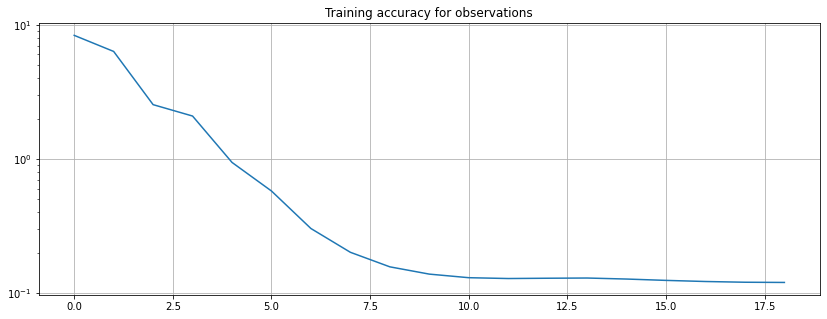

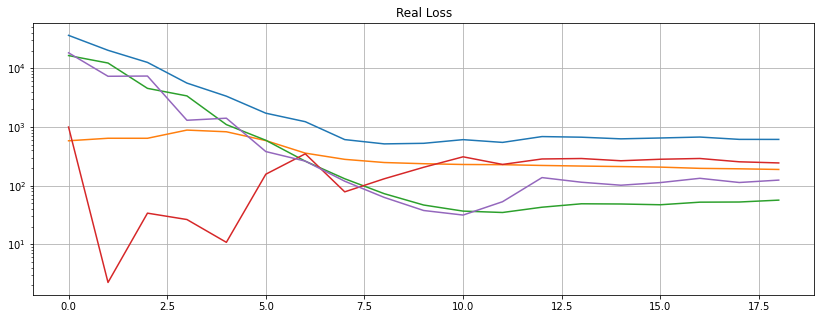

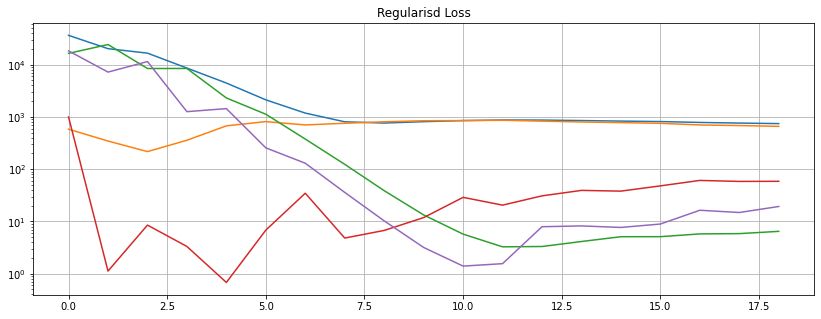

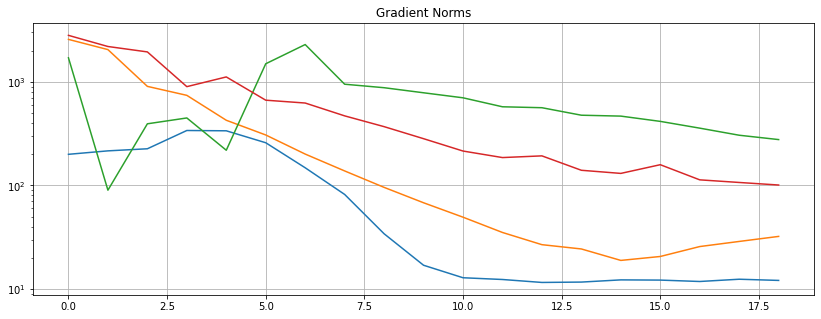

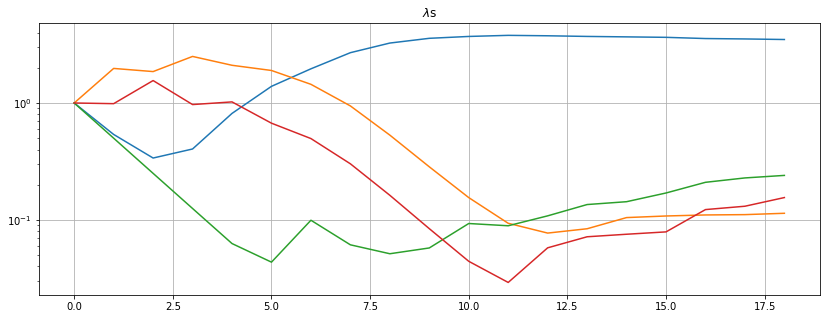

In [8]:
#plot_result(merge_dict(results, results2, results3))
plot_result(results)

In [11]:
results = model.train(epochs = 500,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 3.71528149
total loss: 25352.01068011, total regularisd loss: 25352.01068011
obs u loss: 579.76889571, obs v loss: 13613.77178540
pde u loss: 471.44719073, pde v loss: 10687.02280826
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
D_a:0: 9.71731, D_s:0: 12.36267, sigma_a:0: 10.02123, sigma_s:0: 8.43384, mu_a:0: 9.79264, rho_a:0: 10.34118, rho_s:0: 11.85975, kappa_a:0: 8.04046
extra loss: -0.00000000
Time taken: 86.64s

Start of epoch 1
Training observations acc over epoch: 4.10286665
total loss: 11704.80731901, total regularisd loss: 11704.80731901
obs u loss: 587.54160297, obs v loss: 7815.12431373
pde u loss: 0.85487465, pde v loss: 3301.28652765
lambda obs u: 0.55802689, lambda obs v: 2.16515375
lambda pde u: 0.50000044, lambda pde v: 0.77681892
D_a:0: 9.53462, D_s:0: 13.30064, sigma_a:0: 10.06413, sigma_s:0: 7.61515, mu_a:0: 9.69538, rho_a:0: 10.49950, rho_s:0: 12.66910, ka

Training observations acc over epoch: 0.12332802
total loss: 3159.54073240, total regularisd loss: 795.24611331
obs u loss: 202.18911986, obs v loss: 50.38656176
pde u loss: 252.78854739, pde v loss: 110.58108629
lambda obs u: 3.61190369, lambda obs v: 0.09995834
lambda pde u: 0.18299844, lambda pde v: 0.10513953
D_a:0: 7.18809, D_s:0: 12.75139, sigma_a:0: 7.38985, sigma_s:0: 4.24527, mu_a:0: 10.23133, rho_a:0: 9.74464, rho_s:0: 14.69670, kappa_a:0: 3.17640
extra loss: -0.00000000
Time taken: 43.66s

Start of epoch 17
Training observations acc over epoch: 0.12019077
total loss: 3563.93568061, total regularisd loss: 775.68672294
obs u loss: 193.72863832, obs v loss: 52.42208778
pde u loss: 307.61321866, pde v loss: 137.19649498
lambda obs u: 3.51067611, lambda obs v: 0.10303197
lambda pde u: 0.24365534, lambda pde v: 0.14263658
D_a:0: 6.08241, D_s:0: 11.75627, sigma_a:0: 7.12027, sigma_s:0: 4.15685, mu_a:0: 10.04199, rho_a:0: 9.96416, rho_s:0: 14.20637, kappa_a:0: 3.09671
extra loss: -0

Training observations acc over epoch: 0.03942436
total loss: 307.90124007, total regularisd loss: 151.81950126
obs u loss: 24.89673607, obs v loss: 55.84436793
pde u loss: 78.78326232, pde v loss: 28.94866743
lambda obs u: 1.26048779, lambda obs v: 1.28253641
lambda pde u: 0.62348482, lambda pde v: 0.83349099
D_a:0: 0.03177, D_s:0: 0.04401, sigma_a:0: 0.03177, sigma_s:0: 0.36797, mu_a:0: 4.64677, rho_a:0: 14.90568, rho_s:0: 1.20450, kappa_a:0: 2.64421
extra loss: -0.00000000
Time taken: 43.71s

Start of epoch 33
Training observations acc over epoch: 0.03835144
total loss: 167.76929704, total regularisd loss: 145.13170866
obs u loss: 30.13717103, obs v loss: 48.40661978
pde u loss: 58.39967468, pde v loss: 10.37756868
lambda obs u: 1.01483975, lambda obs v: 1.71581581
lambda pde u: 0.69590958, lambda pde v: 0.57343487
D_a:0: 0.03177, D_s:0: 0.02956, sigma_a:0: 0.03177, sigma_s:0: 0.20187, mu_a:0: 4.75255, rho_a:0: 14.36789, rho_s:0: 0.63238, kappa_a:0: 2.50569
extra loss: -0.00000000
Ti

Training observations acc over epoch: 0.00880038
total loss: 79.99869500, total regularisd loss: 39.99955794
obs u loss: 8.93940973, obs v loss: 9.08376426
pde u loss: 16.54310908, pde v loss: 0.11000157
lambda obs u: 1.69769533, lambda obs v: 1.76530923
lambda pde u: 0.53420747, lambda pde v: 0.00278797
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00544, mu_a:0: 6.10879, rho_a:0: 10.37966, rho_s:0: 0.00860, kappa_a:0: 0.91203
extra loss: -0.00000000
Time taken: 44.33s

Start of epoch 49
Training observations acc over epoch: 0.00864510
total loss: 79.45113278, total regularisd loss: 39.12584075
obs u loss: 8.84040541, obs v loss: 8.86475534
pde u loss: 15.85186356, pde v loss: 0.11026019
lambda obs u: 1.67072844, lambda obs v: 1.78903832
lambda pde u: 0.53744622, lambda pde v: 0.00278702
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00524, mu_a:0: 6.08967, rho_a:0: 10.26899, rho_s:0: 0.00861, kappa_a:0: 0.90008
extra loss: -0.00000000
Time taken: 

Training observations acc over epoch: 0.00741376
total loss: 105.29513682, total regularisd loss: 32.72537575
obs u loss: 8.06502481, obs v loss: 7.11836055
pde u loss: 12.19143053, pde v loss: 0.15259672
lambda obs u: 1.57566584, lambda obs v: 1.89636773
lambda pde u: 0.52594566, lambda pde v: 0.00202077
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00701, mu_a:0: 5.50953, rho_a:0: 8.91080, rho_s:0: 0.01114, kappa_a:0: 0.83032
extra loss: -0.00000000
Time taken: 43.48s

Start of epoch 65
Training observations acc over epoch: 0.00726092
total loss: 120.45698766, total regularisd loss: 32.26606275
obs u loss: 7.90418038, obs v loss: 6.96619460
pde u loss: 12.55051741, pde v loss: 0.17763481
lambda obs u: 1.57086336, lambda obs v: 1.87916649
lambda pde u: 0.54778621, lambda pde v: 0.00218394
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00644, mu_a:0: 5.46129, rho_a:0: 8.82325, rho_s:0: 0.00906, kappa_a:0: 0.82869
extra loss: -0.00000000
Time taken: 

Training observations acc over epoch: 0.00662405
total loss: 74.12060693, total regularisd loss: 28.93902146
obs u loss: 7.23976659, obs v loss: 6.32628700
pde u loss: 9.96543297, pde v loss: 0.14359749
lambda obs u: 1.51405879, lambda obs v: 1.88984430
lambda pde u: 0.59350696, lambda pde v: 0.00258996
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00613, mu_a:0: 4.62048, rho_a:0: 7.35909, rho_s:0: 0.00871, kappa_a:0: 0.80820
extra loss: -0.00000000
Time taken: 44.21s

Start of epoch 81
Training observations acc over epoch: 0.00632545
total loss: 141.72918437, total regularisd loss: 28.04923842
obs u loss: 6.77910553, obs v loss: 6.17542579
pde u loss: 10.30130906, pde v loss: 0.30206016
lambda obs u: 1.48452653, lambda obs v: 1.86454679
lambda pde u: 0.64761043, lambda pde v: 0.00331625
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00831, mu_a:0: 4.55666, rho_a:0: 7.24785, rho_s:0: 0.01152, kappa_a:0: 0.80478
extra loss: -0.00000000
Time taken: 43

Training observations acc over epoch: 0.00522387
total loss: 43.75117187, total regularisd loss: 23.27759636
obs u loss: 5.52452519, obs v loss: 5.17396959
pde u loss: 7.84252967, pde v loss: 0.13990553
lambda obs u: 1.31874672, lambda obs v: 1.82090755
lambda pde u: 0.85520777, lambda pde v: 0.00513796
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00658, mu_a:0: 3.23828, rho_a:0: 5.05831, rho_s:0: 0.00941, kappa_a:0: 0.78261
extra loss: -0.00000000
Time taken: 43.93s

Start of epoch 98
Training observations acc over epoch: 0.00522425
total loss: 42.09197684, total regularisd loss: 22.83980768
obs u loss: 5.60644973, obs v loss: 5.09281979
pde u loss: 7.21703471, pde v loss: 0.13669463
lambda obs u: 1.34391553, lambda obs v: 1.80318309
lambda pde u: 0.84770448, lambda pde v: 0.00519690
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00611, mu_a:0: 3.13192, rho_a:0: 4.87571, rho_s:0: 0.00821, kappa_a:0: 0.77733
extra loss: -0.00000000
Time taken: 43.8

Training observations acc over epoch: 0.00083521
total loss: 3.19446024, total regularisd loss: 2.29912258
obs u loss: 1.18636307, obs v loss: 0.52414297
pde u loss: 0.26762830, pde v loss: 0.01802621
lambda obs u: 1.47454166, lambda obs v: 1.14874411
lambda pde u: 1.36171220, lambda pde v: 0.01500204
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00361, mu_a:0: 0.33532, rho_a:0: 0.34206, rho_s:0: 0.00421, kappa_a:0: 0.36266
extra loss: -0.00000000
Time taken: 43.76s

Start of epoch 115
Training observations acc over epoch: 0.00076546
total loss: 2.09208097, total regularisd loss: 2.31883372
obs u loss: 1.12825529, obs v loss: 0.43940016
pde u loss: 0.11031818, pde v loss: 0.01295284
lambda obs u: 1.96145559, lambda obs v: 1.08233348
lambda pde u: 0.93761305, lambda pde v: 0.01859788
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00328, mu_a:0: 0.26050, rho_a:0: 0.24244, rho_s:0: 0.00346, kappa_a:0: 0.30227
extra loss: -0.00000000
Time taken: 43.61s


Training observations acc over epoch: 0.00047538
total loss: 1.13783919, total regularisd loss: 2.13590679
obs u loss: 0.69509834, obs v loss: 0.27847393
pde u loss: 0.06596270, pde v loss: 0.00825020
lambda obs u: 2.68428254, lambda obs v: 0.84180148
lambda pde u: 0.45300008, lambda pde v: 0.02091590
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00336, mu_a:0: 0.20484, rho_a:0: 0.17020, rho_s:0: 0.00294, kappa_a:0: 0.23098
extra loss: -0.00000000
Time taken: 43.92s

Start of epoch 132
Training observations acc over epoch: 0.00048314
total loss: 1.11803657, total regularisd loss: 2.17170654
obs u loss: 0.71035883, obs v loss: 0.27911264
pde u loss: 0.06574060, pde v loss: 0.00787926
lambda obs u: 2.67925501, lambda obs v: 0.83449802
lambda pde u: 0.46435369, lambda pde v: 0.02189328
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00338, mu_a:0: 0.20516, rho_a:0: 0.16960, rho_s:0: 0.00329, kappa_a:0: 0.22985
extra loss: -0.00000000
Time taken: 44.42s


Training observations acc over epoch: 0.00040502
total loss: 0.89643657, total regularisd loss: 1.79864862
obs u loss: 0.60367048, obs v loss: 0.22581913
pde u loss: 0.06235016, pde v loss: 0.00663482
lambda obs u: 2.63822791, lambda obs v: 0.75978839
lambda pde u: 0.57659791, lambda pde v: 0.02538579
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00309, mu_a:0: 0.20057, rho_a:0: 0.16508, rho_s:0: 0.00305, kappa_a:0: 0.22483
extra loss: -0.00000000
Time taken: 43.88s

Start of epoch 149
Training observations acc over epoch: 0.00040531
total loss: 0.88265157, total regularisd loss: 1.80130733
obs u loss: 0.60400436, obs v loss: 0.22607124
pde u loss: 0.06222688, pde v loss: 0.00630183
lambda obs u: 2.63690433, lambda obs v: 0.75392195
lambda pde u: 0.58293489, lambda pde v: 0.02623884
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00290, mu_a:0: 0.20098, rho_a:0: 0.16432, rho_s:0: 0.00299, kappa_a:0: 0.22385
extra loss: -0.00000000
Time taken: 43.67s


Training observations acc over epoch: 0.00035603
total loss: 0.75975243, total regularisd loss: 1.54846719
obs u loss: 0.52833553, obs v loss: 0.20080712
pde u loss: 0.06031395, pde v loss: 0.00539946
lambda obs u: 2.57294708, lambda obs v: 0.73995008
lambda pde u: 0.65895446, lambda pde v: 0.02814838
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00294, mu_a:0: 0.19900, rho_a:0: 0.16266, rho_s:0: 0.00287, kappa_a:0: 0.22042
extra loss: -0.00000000
Time taken: 44.23s

Start of epoch 166
Training observations acc over epoch: 0.00036949
total loss: 0.77557419, total regularisd loss: 1.61181262
obs u loss: 0.55207899, obs v loss: 0.20464465
pde u loss: 0.06034249, pde v loss: 0.00542884
lambda obs u: 2.56093503, lambda obs v: 0.73417483
lambda pde u: 0.67631331, lambda pde v: 0.02857683
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00316, mu_a:0: 0.19909, rho_a:0: 0.16241, rho_s:0: 0.00314, kappa_a:0: 0.22157
extra loss: -0.00000000
Time taken: 44.13s


Training observations acc over epoch: 0.00033368
total loss: 0.70577877, total regularisd loss: 1.42037499
obs u loss: 0.49485828, obs v loss: 0.18851258
pde u loss: 0.05921788, pde v loss: 0.00486222
lambda obs u: 2.49590481, lambda obs v: 0.73062668
lambda pde u: 0.74536093, lambda pde v: 0.02810757
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00307, mu_a:0: 0.19885, rho_a:0: 0.16160, rho_s:0: 0.00287, kappa_a:0: 0.22012
extra loss: -0.00000000
Time taken: 43.59s

Start of epoch 183
Training observations acc over epoch: 0.00032901
total loss: 0.70118589, total regularisd loss: 1.39671555
obs u loss: 0.48728521, obs v loss: 0.18653735
pde u loss: 0.05913046, pde v loss: 0.00481509
lambda obs u: 2.48925309, lambda obs v: 0.73635638
lambda pde u: 0.74555076, lambda pde v: 0.02883977
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00293, mu_a:0: 0.19827, rho_a:0: 0.16144, rho_s:0: 0.00294, kappa_a:0: 0.22024
extra loss: -0.00000000
Time taken: 43.60s


Training observations acc over epoch: 0.00031154
total loss: 0.65980314, total regularisd loss: 1.31608101
obs u loss: 0.46347159, obs v loss: 0.17455326
pde u loss: 0.05855646, pde v loss: 0.00454117
lambda obs u: 2.45270576, lambda obs v: 0.71171247
lambda pde u: 0.80587817, lambda pde v: 0.02970361
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00315, mu_a:0: 0.19845, rho_a:0: 0.16087, rho_s:0: 0.00290, kappa_a:0: 0.21956
extra loss: -0.00000000
Time taken: 43.60s

Start of epoch 200
Training observations acc over epoch: 0.00030758
total loss: 0.65605422, total regularisd loss: 1.28941356
obs u loss: 0.45594773, obs v loss: 0.17398118
pde u loss: 0.05850547, pde v loss: 0.00454779
lambda obs u: 2.43309026, lambda obs v: 0.71271246
lambda pde u: 0.82381419, lambda pde v: 0.03038309
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00295, mu_a:0: 0.19808, rho_a:0: 0.16073, rho_s:0: 0.00306, kappa_a:0: 0.21932
extra loss: -0.00000000
Time taken: 43.45s


Training observations acc over epoch: 0.00028728
total loss: 0.61686410, total regularisd loss: 1.17941653
obs u loss: 0.42374829, obs v loss: 0.16460266
pde u loss: 0.05791945, pde v loss: 0.00445145
lambda obs u: 2.39288311, lambda obs v: 0.70702644
lambda pde u: 0.86812228, lambda pde v: 0.03196817
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00312, mu_a:0: 0.19763, rho_a:0: 0.16028, rho_s:0: 0.00281, kappa_a:0: 0.21813
extra loss: -0.00000000
Time taken: 44.50s

Start of epoch 217
Training observations acc over epoch: 0.00030070
total loss: 0.63094534, total regularisd loss: 1.24105462
obs u loss: 0.44790870, obs v loss: 0.16792910
pde u loss: 0.05804332, pde v loss: 0.00445592
lambda obs u: 2.38841794, lambda obs v: 0.69871669
lambda pde u: 0.88137484, lambda pde v: 0.03149053
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00274, mu_a:0: 0.19750, rho_a:0: 0.16024, rho_s:0: 0.00290, kappa_a:0: 0.21861
extra loss: -0.00000000
Time taken: 44.22s


Training observations acc over epoch: 0.00027981
total loss: 0.60167014, total regularisd loss: 1.12925577
obs u loss: 0.41377303, obs v loss: 0.15928652
pde u loss: 0.05739965, pde v loss: 0.00445432
lambda obs u: 2.32272381, lambda obs v: 0.69524476
lambda pde u: 0.94845281, lambda pde v: 0.03357861
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00306, mu_a:0: 0.19676, rho_a:0: 0.16028, rho_s:0: 0.00275, kappa_a:0: 0.21762
extra loss: -0.00000000
Time taken: 43.96s

Start of epoch 234
Training observations acc over epoch: 0.00027105
total loss: 0.59057352, total regularisd loss: 1.08999186
obs u loss: 0.39908163, obs v loss: 0.15602007
pde u loss: 0.05736964, pde v loss: 0.00449481
lambda obs u: 2.30990904, lambda obs v: 0.70427934
lambda pde u: 0.95260598, lambda pde v: 0.03320564
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00289, mu_a:0: 0.19715, rho_a:0: 0.15981, rho_s:0: 0.00275, kappa_a:0: 0.21818
extra loss: -0.00000000
Time taken: 43.53s


Training observations acc over epoch: 0.00026051
total loss: 0.56851067, total regularisd loss: 1.03478214
obs u loss: 0.38392807, obs v loss: 0.14959101
pde u loss: 0.05603392, pde v loss: 0.00454294
lambda obs u: 2.26736749, lambda obs v: 0.69687393
lambda pde u: 0.99920518, lambda pde v: 0.03655340
D_a:0: 0.03113, D_s:0: 0.03177, sigma_a:0: 0.03176, sigma_s:0: 0.00289, mu_a:0: 0.19629, rho_a:0: 0.15854, rho_s:0: 0.00277, kappa_a:0: 0.21742
extra loss: -0.00000000
Time taken: 44.04s

Start of epoch 251
Training observations acc over epoch: 0.00026581
total loss: 0.57137464, total regularisd loss: 1.05106207
obs u loss: 0.39228351, obs v loss: 0.15208627
pde u loss: 0.05550391, pde v loss: 0.00455357
lambda obs u: 2.30577225, lambda obs v: 0.68208806
lambda pde u: 0.97466361, lambda pde v: 0.03747609
D_a:0: 0.03071, D_s:0: 0.03177, sigma_a:0: 0.03175, sigma_s:0: 0.00343, mu_a:0: 0.19481, rho_a:0: 0.15760, rho_s:0: 0.00271, kappa_a:0: 0.21646
extra loss: -0.00000000
Time taken: 43.84s


Training observations acc over epoch: 0.00025476
total loss: 0.44038924, total regularisd loss: 1.20441351
obs u loss: 0.37779481, obs v loss: 0.14394986
pde u loss: 0.00989034, pde v loss: 0.00438051
lambda obs u: 2.91682185, lambda obs v: 0.85031538
lambda pde u: 0.18554676, lambda pde v: 0.04731600
D_a:0: 0.00199, D_s:0: 0.03176, sigma_a:0: 0.01593, sigma_s:0: 0.00308, mu_a:0: 0.07399, rho_a:0: 0.05533, rho_s:0: 0.00266, kappa_a:0: 0.20176
extra loss: -0.00000000
Time taken: 43.95s

Start of epoch 268
Training observations acc over epoch: 0.00024946
total loss: 0.42195897, total regularisd loss: 1.19597582
obs u loss: 0.36784270, obs v loss: 0.14306108
pde u loss: 0.00640698, pde v loss: 0.00440385
lambda obs u: 2.96161219, lambda obs v: 0.86481299
lambda pde u: 0.12510459, lambda pde v: 0.04847024
D_a:0: 0.00167, D_s:0: 0.03176, sigma_a:0: 0.01253, sigma_s:0: 0.00303, mu_a:0: 0.05884, rho_a:0: 0.04402, rho_s:0: 0.00275, kappa_a:0: 0.20302
extra loss: -0.00000000
Time taken: 44.03s


Training observations acc over epoch: 0.00023551
total loss: 0.68138046, total regularisd loss: 1.19071505
obs u loss: 0.34839435, obs v loss: 0.13393482
pde u loss: 0.00001113, pde v loss: 0.00192126
lambda obs u: 3.07633277, lambda obs v: 0.89965129
lambda pde u: 0.00001887, lambda pde v: 0.02399707
D_a:0: 0.00007, D_s:0: 0.01928, sigma_a:0: 0.00034, sigma_s:0: 0.00204, mu_a:0: 0.00213, rho_a:0: 0.00196, rho_s:0: 0.00200, kappa_a:0: 0.32885
extra loss: -0.00000000
Time taken: 43.75s

Start of epoch 285
Training observations acc over epoch: 0.00023959
total loss: 0.77933540, total regularisd loss: 1.21171717
obs u loss: 0.35386230, obs v loss: 0.13681588
pde u loss: 0.00000860, pde v loss: 0.00135040
lambda obs u: 3.08719385, lambda obs v: 0.89552935
lambda pde u: 0.00001211, lambda pde v: 0.01726469
D_a:0: 0.00008, D_s:0: 0.01569, sigma_a:0: 0.00028, sigma_s:0: 0.00145, mu_a:0: 0.00187, rho_a:0: 0.00174, rho_s:0: 0.00170, kappa_a:0: 0.32947
extra loss: -0.00000000
Time taken: 43.89s


Training observations acc over epoch: 0.00023006
total loss: 2.16390499, total regularisd loss: 1.17154177
obs u loss: 0.34030701, obs v loss: 0.13086445
pde u loss: 0.00000296, pde v loss: 0.00000241
lambda obs u: 3.11294314, lambda obs v: 0.88705148
lambda pde u: 0.00000198, lambda pde v: 0.00000341
D_a:0: 0.00007, D_s:0: 0.00066, sigma_a:0: 0.00009, sigma_s:0: 0.00007, mu_a:0: 0.00083, rho_a:0: 0.00080, rho_s:0: 0.00007, kappa_a:0: 0.32980
extra loss: -0.00000000
Time taken: 43.66s

Start of epoch 302
Training observations acc over epoch: 0.00022444
total loss: 2.28960744, total regularisd loss: 1.14374130
obs u loss: 0.33065534, obs v loss: 0.12900043
pde u loss: 0.00000289, pde v loss: 0.00000196
lambda obs u: 3.11749288, lambda obs v: 0.88250289
lambda pde u: 0.00000195, lambda pde v: 0.00000229
D_a:0: 0.00006, D_s:0: 0.00059, sigma_a:0: 0.00009, sigma_s:0: 0.00006, mu_a:0: 0.00080, rho_a:0: 0.00078, rho_s:0: 0.00007, kappa_a:0: 0.32980
extra loss: -0.00000000
Time taken: 44.28s


Training observations acc over epoch: 0.00024923
total loss: 1.67167190, total regularisd loss: 1.11303305
obs u loss: 0.36051100, obs v loss: 0.14991093
pde u loss: 0.32756211, pde v loss: 0.14871098
lambda obs u: 0.59731648, lambda obs v: 0.19670735
lambda pde u: 2.22044217, lambda pde v: 0.98553400
D_a:0: 0.03177, D_s:0: 0.17925, sigma_a:0: 0.03177, sigma_s:0: 0.02987, mu_a:0: 0.03177, rho_a:0: 0.00704, rho_s:0: 0.01827, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.23s

Start of epoch 318
Training observations acc over epoch: 0.00024655
total loss: 1.63767866, total regularisd loss: 1.10499848
obs u loss: 0.35726062, obs v loss: 0.14767856
pde u loss: 0.32643007, pde v loss: 0.13975396
lambda obs u: 0.59790398, lambda obs v: 0.19869536
lambda pde u: 2.26334493, lambda pde v: 0.94005574
D_a:0: 0.03177, D_s:0: 0.17255, sigma_a:0: 0.03177, sigma_s:0: 0.02873, mu_a:0: 0.03177, rho_a:0: 0.00725, rho_s:0: 0.01755, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.25s


Training observations acc over epoch: 0.00023339
total loss: 1.38516609, total regularisd loss: 1.23707567
obs u loss: 0.34905015, obs v loss: 0.12892953
pde u loss: 0.31158883, pde v loss: 0.00019543
lambda obs u: 0.81696362, lambda obs v: 0.21715400
lambda pde u: 2.96547215, lambda pde v: 0.00041023
D_a:0: 0.03177, D_s:0: 0.00443, sigma_a:0: 0.03177, sigma_s:0: 0.00090, mu_a:0: 0.03177, rho_a:0: 0.00741, rho_s:0: 0.00053, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.31s

Start of epoch 335
Training observations acc over epoch: 0.00023584
total loss: 1.50329086, total regularisd loss: 1.23768782
obs u loss: 0.35272348, obs v loss: 0.13028272
pde u loss: 0.31065343, pde v loss: 0.00015048
lambda obs u: 0.79940252, lambda obs v: 0.21478014
lambda pde u: 2.98559227, lambda pde v: 0.00022508
D_a:0: 0.03177, D_s:0: 0.00380, sigma_a:0: 0.03177, sigma_s:0: 0.00079, mu_a:0: 0.03177, rho_a:0: 0.00718, rho_s:0: 0.00047, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.21s


Training observations acc over epoch: 0.00023048
total loss: 7.41363855, total regularisd loss: 1.18788048
obs u loss: 0.34181775, obs v loss: 0.13019654
pde u loss: 0.29732495, pde v loss: 0.00000372
lambda obs u: 0.81003035, lambda obs v: 0.22403945
lambda pde u: 2.96592963, lambda pde v: 0.00000057
D_a:0: 0.03177, D_s:0: 0.00092, sigma_a:0: 0.03177, sigma_s:0: 0.00007, mu_a:0: 0.03177, rho_a:0: 0.00748, rho_s:0: 0.00005, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 43.95s

Start of epoch 352
Training observations acc over epoch: 0.00023032
total loss: 7.07917696, total regularisd loss: 1.18585022
obs u loss: 0.34227302, obs v loss: 0.12942200
pde u loss: 0.29656909, pde v loss: 0.00000340
lambda obs u: 0.81337975, lambda obs v: 0.22511280
lambda pde u: 2.96150691, lambda pde v: 0.00000054
D_a:0: 0.03177, D_s:0: 0.00088, sigma_a:0: 0.03177, sigma_s:0: 0.00006, mu_a:0: 0.03177, rho_a:0: 0.00765, rho_s:0: 0.00005, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.02s


Training observations acc over epoch: 0.00027591
total loss: 1.80187997, total regularisd loss: 1.19019001
obs u loss: 0.36592382, obs v loss: 0.19913706
pde u loss: 0.29539253, pde v loss: 0.29406470
lambda obs u: 0.52812565, lambda obs v: 0.26741951
lambda pde u: 1.61690686, lambda pde v: 1.58754799
D_a:0: 0.03177, D_s:0: 0.33882, sigma_a:0: 0.03177, sigma_s:0: 0.04282, mu_a:0: 0.03177, rho_a:0: 0.00753, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.30s

Start of epoch 368
Training observations acc over epoch: 0.00027395
total loss: 1.79821786, total regularisd loss: 1.18619184
obs u loss: 0.36119593, obs v loss: 0.19985572
pde u loss: 0.29503692, pde v loss: 0.29286829
lambda obs u: 0.51625997, lambda obs v: 0.26550939
lambda pde u: 1.62572020, lambda pde v: 1.59251044
D_a:0: 0.03177, D_s:0: 0.34113, sigma_a:0: 0.03177, sigma_s:0: 0.04326, mu_a:0: 0.03177, rho_a:0: 0.00733, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.16s


Training observations acc over epoch: 0.00027325
total loss: 1.81372052, total regularisd loss: 1.15611799
obs u loss: 0.36392376, obs v loss: 0.19569681
pde u loss: 0.28862710, pde v loss: 0.28086198
lambda obs u: 0.51312631, lambda obs v: 0.26455268
lambda pde u: 1.64466312, lambda pde v: 1.57765789
D_a:0: 0.03177, D_s:0: 0.34445, sigma_a:0: 0.03177, sigma_s:0: 0.04401, mu_a:0: 0.03177, rho_a:0: 0.00743, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.17s

Start of epoch 385
Training observations acc over epoch: 0.00026268
total loss: 1.75399989, total regularisd loss: 1.14510632
obs u loss: 0.34552581, obs v loss: 0.19245090
pde u loss: 0.28836687, pde v loss: 0.28056031
lambda obs u: 0.52303278, lambda obs v: 0.26755344
lambda pde u: 1.63720319, lambda pde v: 1.57221059
D_a:0: 0.03177, D_s:0: 0.34631, sigma_a:0: 0.03177, sigma_s:0: 0.04324, mu_a:0: 0.03177, rho_a:0: 0.00694, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 43.84s


Training observations acc over epoch: 0.00026129
total loss: 1.73942542, total regularisd loss: 1.12500873
obs u loss: 0.34636374, obs v loss: 0.18875420
pde u loss: 0.28315691, pde v loss: 0.27396998
lambda obs u: 0.50816064, lambda obs v: 0.26228904
lambda pde u: 1.65157453, lambda pde v: 1.57797579
D_a:0: 0.03177, D_s:0: 0.34906, sigma_a:0: 0.03177, sigma_s:0: 0.04355, mu_a:0: 0.03177, rho_a:0: 0.00704, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.02s

Start of epoch 402
Training observations acc over epoch: 0.00026786
total loss: 1.77558783, total regularisd loss: 1.13085234
obs u loss: 0.35808146, obs v loss: 0.19049225
pde u loss: 0.28297919, pde v loss: 0.27349227
lambda obs u: 0.50697167, lambda obs v: 0.26203519
lambda pde u: 1.65286800, lambda pde v: 1.57812514
D_a:0: 0.03177, D_s:0: 0.34850, sigma_a:0: 0.03177, sigma_s:0: 0.04290, mu_a:0: 0.03177, rho_a:0: 0.00740, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 43.76s


Training observations acc over epoch: 0.00026163
total loss: 1.76006800, total regularisd loss: 1.11011797
obs u loss: 0.34884071, obs v loss: 0.18698536
pde u loss: 0.27881945, pde v loss: 0.26856984
lambda obs u: 0.50291044, lambda obs v: 0.26263068
lambda pde u: 1.65712529, lambda pde v: 1.57733359
D_a:0: 0.03177, D_s:0: 0.34916, sigma_a:0: 0.03177, sigma_s:0: 0.04245, mu_a:0: 0.03177, rho_a:0: 0.00727, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.03s

Start of epoch 419
Training observations acc over epoch: 0.00025704
total loss: 1.72455541, total regularisd loss: 1.10499474
obs u loss: 0.33978275, obs v loss: 0.18662756
pde u loss: 0.27854267, pde v loss: 0.26850390
lambda obs u: 0.49819620, lambda obs v: 0.25977601
lambda pde u: 1.66152572, lambda pde v: 1.58050207
D_a:0: 0.03177, D_s:0: 0.35315, sigma_a:0: 0.03177, sigma_s:0: 0.04329, mu_a:0: 0.03177, rho_a:0: 0.00698, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.12s


Training observations acc over epoch: 0.00026119
total loss: 1.72449808, total regularisd loss: 1.09935606
obs u loss: 0.35046703, obs v loss: 0.18445191
pde u loss: 0.27506576, pde v loss: 0.26528343
lambda obs u: 0.49725701, lambda obs v: 0.25750977
lambda pde u: 1.66304918, lambda pde v: 1.58218405
D_a:0: 0.03177, D_s:0: 0.35470, sigma_a:0: 0.03177, sigma_s:0: 0.04332, mu_a:0: 0.03177, rho_a:0: 0.00734, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.44s

Start of epoch 436
Training observations acc over epoch: 0.00025390
total loss: 1.72155930, total regularisd loss: 1.08989625
obs u loss: 0.33653563, obs v loss: 0.18345797
pde u loss: 0.27471959, pde v loss: 0.26446806
lambda obs u: 0.50324562, lambda obs v: 0.26214464
lambda pde u: 1.65785515, lambda pde v: 1.57675458
D_a:0: 0.03177, D_s:0: 0.35816, sigma_a:0: 0.03177, sigma_s:0: 0.04300, mu_a:0: 0.03177, rho_a:0: 0.00712, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 43.90s


Training observations acc over epoch: 0.00025027
total loss: 1.68630579, total regularisd loss: 1.07657388
obs u loss: 0.33242052, obs v loss: 0.18012710
pde u loss: 0.27162640, pde v loss: 0.26152805
lambda obs u: 0.48830334, lambda obs v: 0.26081324
lambda pde u: 1.66574251, lambda pde v: 1.58514091
D_a:0: 0.03177, D_s:0: 0.35745, sigma_a:0: 0.03177, sigma_s:0: 0.04340, mu_a:0: 0.03177, rho_a:0: 0.00764, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.54s

Start of epoch 453
Training observations acc over epoch: 0.00025022
total loss: 1.70064041, total regularisd loss: 1.07498608
obs u loss: 0.33130597, obs v loss: 0.18113689
pde u loss: 0.27140210, pde v loss: 0.26109941
lambda obs u: 0.49143029, lambda obs v: 0.25932608
lambda pde u: 1.66554314, lambda pde v: 1.58370049
D_a:0: 0.03177, D_s:0: 0.35721, sigma_a:0: 0.03177, sigma_s:0: 0.04230, mu_a:0: 0.03177, rho_a:0: 0.00778, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.43s


Training observations acc over epoch: 0.00025264
total loss: 1.69779980, total regularisd loss: 1.07030009
obs u loss: 0.33687335, obs v loss: 0.18053252
pde u loss: 0.26915526, pde v loss: 0.25856048
lambda obs u: 0.49447701, lambda obs v: 0.25578107
lambda pde u: 1.66968010, lambda pde v: 1.58006182
D_a:0: 0.03177, D_s:0: 0.35702, sigma_a:0: 0.03177, sigma_s:0: 0.04299, mu_a:0: 0.03177, rho_a:0: 0.00748, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.23s

Start of epoch 470
Training observations acc over epoch: 0.00024971
total loss: 1.69994589, total regularisd loss: 1.06733163
obs u loss: 0.33072243, obs v loss: 0.18068828
pde u loss: 0.26915246, pde v loss: 0.25833283
lambda obs u: 0.49147213, lambda obs v: 0.25772456
lambda pde u: 1.67010716, lambda pde v: 1.58069615
D_a:0: 0.03177, D_s:0: 0.35425, sigma_a:0: 0.03177, sigma_s:0: 0.04283, mu_a:0: 0.03177, rho_a:0: 0.00753, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.05s


Training observations acc over epoch: 0.00024334
total loss: 1.66041530, total regularisd loss: 1.05384919
obs u loss: 0.32144009, obs v loss: 0.17692117
pde u loss: 0.26722203, pde v loss: 0.25602383
lambda obs u: 0.48434573, lambda obs v: 0.25998138
lambda pde u: 1.67238661, lambda pde v: 1.58328628
D_a:0: 0.03177, D_s:0: 0.36006, sigma_a:0: 0.03177, sigma_s:0: 0.04335, mu_a:0: 0.03177, rho_a:0: 0.00796, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.45s

Start of epoch 487
Training observations acc over epoch: 0.00024363
total loss: 1.66692022, total regularisd loss: 1.05349286
obs u loss: 0.32184708, obs v loss: 0.17709833
pde u loss: 0.26704013, pde v loss: 0.25577876
lambda obs u: 0.47687979, lambda obs v: 0.25933405
lambda pde u: 1.67745487, lambda pde v: 1.58633129
D_a:0: 0.03177, D_s:0: 0.35782, sigma_a:0: 0.03177, sigma_s:0: 0.04338, mu_a:0: 0.03177, rho_a:0: 0.00744, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.11s


In [ ]:
(4e-6/epsilon)*(tf.pow(1e-6/(params+1e-10), twelve) - tf.pow(1e-6/(params+1e-10), six))

In [9]:
def LJ(x):
    return (4e-6/2)*((1e-6/(x+1e-10))**12 - (1e-6/(x+1e-10))**6)

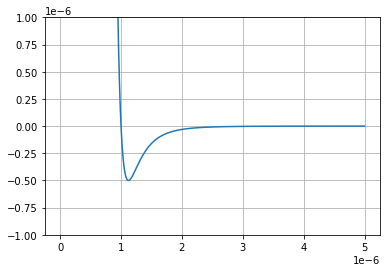

In [10]:
x = np.linspace(0,5e-6, 20000)
plt.plot(x, LJ(x))
#plt.yscale('log')
plt.ylim([-.000001, .000001])
plt.grid()
plt.show()

In [41]:
LJ(.09*1e-6)

1746917.0365552774

In [11]:
LJ(0.000000003177)

1.3041054175600286e+24

In [56]:
LJ(1e-7)

1976153.2866794027